In [141]:
import pandas as pd
import numpy as np
import os
import string
from datetime import timezone,datetime,timedelta,date
os.getcwd()
import glob
import pytz
import seaborn as sns
import re

In [142]:
datetime(year=2021, month=5, day=17, hour=12, minute=0,second=0)+timedelta(days=180)

datetime.datetime(2021, 11, 13, 12, 0)

In [143]:
def convert_mm(value):
    #length in mm transformed to float
    try:
        new_value = value.replace(' mm','')
        return float(new_value)    
    except AttributeError:
        return np.NaN

In [144]:
def convert_exposure(value):
    #length in mm transformed to float
    try:
        list_string=value.split('/')
        if (len(list_string)==1):
            return float(value)
        else:
            return float(list_string[0])/float(list_string[1])
    except AttributeError:
        #print ('WTF',value)
        return np.NaN
    #return float(0)
        

In [145]:
def extract_vatican(source,place,country):
    #all pictures originate from a Pictures folder, remove the full path
    vatican_strings =['Apostolisch',"Vatikan","Petersdom","Santa Maria Maggiore","Lateran","Paolo fuori le Mura",
                     'Scala Scanta','Triclinium Leoninum','Petersplatz','Campo Santo Teutonico',"Sant' Anna",
                     'Sancta Sanctorum','Palazzo Pontifico','Villa Barberini']
    #including Pictures
    if place=="Rom" or place=="Castel Gandolfo":
        for v in vatican_strings:
            if v in source:
                country='Vatican'
    return country

In [146]:
def remove_full_path(value):
    #all pictures originate from a Pictures folder, remove the full path
    #including Pictures
    try:
        list_string=value.split('/Pictures')
        return list_string[1]
    except AttributeError:
        return np.NaN

In [147]:
def extractCityV2(filename):
    m = re.search(r'(?<=\s-\s)\D+?(,)', filename)
    if m==None:
        print("error in",filename)
    else:
        #print("test",m[0][:-1])
        return m[0][:-1]

In [148]:
def funcDayPeriod(filename):
    search_night=["bei Nacht",'Sternenhimmel',"Mondschein","Mond","Ice and Snow/"]
    search_night_special=["Lumiere","euerwerk","Firework","Freudenfeuer"]
    search_twilight=["bei anbrechender Nacht","Abenddaemmerung","Morgendaemmerung","Sonnenaufgang"]
    if any (x in filename for x in search_night):
        return -1
    elif any(x in filename for x in search_night_special):
         return 0
    elif any(x in filename for x in search_twilight):
        return 3
    elif "bei Sonnenuntergang" in filename:
        return 2
    else:
        return 1

In [149]:
def funcComposite(filename):
    if "Panorama." in filename:
        return 1
    else:
        return 0

In [150]:
def funcMovie(filename):
    search_file_names=[".JPG",".jpg",".JPEG",".jpeg"]
    if any(x in filename for x in search_file_names):
        return 0
    else:
        return 1

In [151]:
def funcTimeZoneCorrectionNYCBias(value,filename,modelname,data_min,data_max):
    try:
        if value=='0000:00:00 00:00:00' or value=='missing':
            return np.NaN
        else:
            #date example: Dec 09 Sat ,2006, 17:12:27
            #abrMonth day(number zero-padded) day(abbr name),year, hour(24):minute:second
            #date is ordered by 
            #date_orig = datetime.datetime.strptime(value,"%b %d %a ,%Y, %H:%M:%S") 
            date_val = value
            if modelname=="SP500UZ":
                if(date_val>data_min and date_val<data_max):
                #never changed timezone after getting back from NYC, all messed up
                    date_val=date_val+timedelta(hours=6)
            return date_val
    except AttributeError:
        return np.NaN

In [152]:
def funcTimeZoneCorrection(value,filename,modelname):
    try:
        if value=='0000:00:00 00:00:00' or value=='missing':
            return np.NaN
        else:
            #date example: Dec 09 Sat ,2006, 17:12:27
            #abrMonth day(number zero-padded) day(abbr name),year, hour(24):minute:second
            date_val = value
            search_names_NYC_time_zone=["- Philadelphia,","New York City,","Newark,","Washington Airport"]
            search_names_London_time_zone_CANON600D=["Dublin & Nordirland/P","120830-120909 - Portugal/","Suedengland/","141212-141214 - London/","Greater London"]
            search_names_Istanbul_time_zone_CANON600D=["41023-141027 - Istanbul/","150828-150912 Sankt Petersburg/"]
            search_names_pacific_time_zone_CANON600D=["150613 - Los Angeles/","USA/P818"," - Grand Canyon Village, "," - Boulder City, "," - Las Vegas, "]
            search_names_China_time_zone_CANON80D=["180101 China/","/171230 Shanghai"," - China, "]
            search_names_EastEurope_time_zone_CANON80D=["170603 Athen/","171006 Tallinn ","/170414 Kiev"," - Tuerkei, "," - Irak, "," - Kuwait"," - Qatar, "]
            search_names_London_time_zone_CANON80D=[" - Saudi-Arabien,","/190413-190417 Suedostengland/"," - United Kingdom - ","/171110 Marrakesch/","170915 London/P","/180602 UK/"]
            search_names_Iceland_time_zone_CANON80D=[" - Island, ","/180328 Island/"]
            search_names_Gulf_time_zone_CANON80D=[" - Island, "," - Dubai, "]
            search_names_Pakistan_time_zone_CANON80D=[" - Pakistan, "]
            search_names_Korea_time_zone_CANON80D=[" - Paju, "," - Suwon, "," - Seoul, "," - Busan,"," - Incheon, "," - Gyeongju, "," - Gwanju, "]
            if modelname=="SP500UZ":
                hour_bias=0
                data_max_olympus=datetime.now()
                date_max_olympus=date(2008,9,1)
                if(date_val<date_max_olympus):
                    hour_bias=24
                #no change of default time, thus London time is an hour too late
                if "London/P" in filename:  
                    date_val=date_val-timedelta(hours=1)+timedelta(hours=hour_bias)
                    return date_val
                elif any(x in filename for x in search_names_NYC_time_zone):
                    date_val=date_val-timedelta(hours=6)+timedelta(hours=hour_bias)
                    return date_val
                elif " Chicago - Edit2012/P" in filename:
                    date_val=date_val-timedelta(hours=7)+timedelta(hours=hour_bias)
                    return date_val   
                else:
                    value_new=date_val+timedelta(hours=hour_bias)
                    return value_new
            if modelname=="Canon EOS 600D":
                #all of EOS600D done including 2015
                if any(x in filename for x in search_names_London_time_zone_CANON600D):
                    date_val=date_val-timedelta(hours=1)
                    return date_val
                elif any(x in filename for x in search_names_Istanbul_time_zone_CANON600D):
                    date_val=date_val+timedelta(hours=1) 
                    return date_val
                elif any(x in filename for x in search_names_pacific_time_zone_CANON600D):
                    date_val=date_val-timedelta(hours=9)
                    return date_val
                elif "- Chicago, " in filename:
                    date_val=date_val-timedelta(hours=7)
                    return date_val
                elif " - Washington D.C., " in filename:
                    date_val=date_val-timedelta(hours=6)
                    return date_val
                elif "/160813 - USA/" in filename:
                    #remaining 2016 US trip times
                    date_val=date_val-timedelta(hours=8)
                    return date_val
                elif "161205 - Japan/" in filename:
                    date_val=date_val+timedelta(hours=7)
                    return date_val
                else:
                    #change to default summer time
                    return date_val
            if modelname=="Canon PowerShot S110":  
                 #all running on summer time
                if any(x in filename for x in search_names_London_time_zone_CANON600D): 
                    date_val=date_val-timedelta(hours=2)
                    return date_val
                elif "41023-141027 - Istanbul/" in filename:
                    #for Istanbul timezone was not aligned with CANON EOS600D
                    date_val=date_val-timedelta(hours=1)
                    return date_val
                elif "150613 - Los Angeles/" in filename:
                    date_val=date_val-timedelta(hours=10)
                    return date_val
                elif "/2016/" in filename:
                    if "161205 - Japan/" in filename:
                        date_val=date_val+timedelta(hours=6)
                        return date_val
                    else:
                        #change to default summer time
                        date_val=date_val-timedelta(hours=1)
                        return date_val
                else:
                    #change to default summer time
                    date_val=date_val-timedelta(hours=1)
                    return date_val
            if modelname=="Canon EOS 80D":
                if any(x in filename for x in search_names_China_time_zone_CANON80D):
                    date_val=date_val+timedelta(hours=6)
                    return date_val
                elif any(x in filename for x in search_names_EastEurope_time_zone_CANON80D):
                    date_val=date_val+timedelta(hours=1)
                    return date_val
                elif any(x in filename for x in search_names_London_time_zone_CANON80D):
                    date_val=date_val-timedelta(hours=1)
                    return date_val
                elif " - Groenland" in filename:
                    date_val=date_val-timedelta(hours=4)
                    return date_val
                elif any (x in filename for x in search_names_Iceland_time_zone_CANON80D):
                    date_val=date_val-timedelta(hours=2)
                    return date_val
                elif "/170609 USA/" in filename:
                    date_val=date_val-timedelta(hours=8)
                    return date_val
                elif any(x in filename for x in search_names_Gulf_time_zone_CANON80D):
                    date_val=date_val+timedelta(hours=2)
                    return date_val
                elif any(x in filename for x in search_names_Pakistan_time_zone_CANON80D):
                    date_val=date_val+timedelta(hours=3)
                    return date_val
                elif any(x in filename for x in search_names_Korea_time_zone_CANON80D):
                    date_val=date_val+timedelta(hours=7)
                    return date_val
                else:
                    #always on summer time
                    return date_val
    except AttributeError:
        return np.NaN

In [153]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


dataframe_list=[]

datamax=datetime.now()
datamin=datetime.now()


"""    
columns_to_keep=['SourceFile','Aperture','AspectRatio','AutoISO','BaseISO','BitsPerSample',
                'ColorSpace','ColorTemperature','Contrast','DateTimeOriginal','DateTimeOriginal'
                    'ExposureTime','FileName','Flash','FocalLength','FocalLength35efl','ImageSize',
                    'ImageWidth','ISO','Lens','Lens35efl','LightValue','MaxAperture','MinAperture','MinFocalLength',
                     'Model','Orientation','PictureStyle','Quality','RedBalance','ShutterSpeed',
                    'TargetAperture','TimeZone','TimeZoneCity','WB_RGGBLevels','WB_RGGBLevelsAsShot',
                    'WBBracketMode','WhiteBalance','WhiteBalanceBlue','WhiteBalanceRed','BlueBalance']
"""

for input in range(2006,2025):
    #print("get to year",input)
    file_name=("outputEXIFcsvsFullInfo/PhotoEXIFDataFull_%s.csv"%(str(input)))
#    df=pd.read_csv(file_name)
#    df=df.dropna(subset=['BitsPerSample'])
    df_test=pd.read_csv(file_name, encoding= 'unicode_escape')
    df_test=df_test.dropna(subset=['BitsPerSample'])
#for c in df_test.columns:
#    print("col",c,df_test[c].isna().sum(),df_test.shape)

    columns_to_keep=['SourceFile','Aperture','ApertureValue','BitsPerSample','BlueBalance','ColorSpace','ColorTempAsShot','Contrast',
                 'DateTimeOriginal','ExposureTime','FileName','Flash','FlashActivity','FNumber','FocalLength','CreateDate',
                 'FocalLength35efl','ImageSize','ImageWidth','ISO','LightValue','Model','Orientation',
                 'Quality','ShutterSpeed','ShutterSpeedValue','WB_RGGBLevelsAsShot','WhiteBalance']
    #df_test=df_test[columns_to_keep]
    df_test=df_test[df_test.columns.intersection(columns_to_keep)]
    df_test['SourceFile']=df_test['SourceFile'].str.replace("--","-")
    df_test["Place"]=df_test.apply(lambda x: extractCityV2(x['SourceFile']), axis=1)
    df_test['SourceFile']=df_test['SourceFile'].apply(remove_full_path)    
    df_test['FocalLength']=df_test['FocalLength'].apply(convert_mm) 
    df_test['ExposureTime']=df_test['ExposureTime'].apply(convert_exposure)
    df_test=df_test.replace({'DateTimeOriginal': {'0000:00:00 00:00:00': '2006:01:10 15:20:30'}})
    df_test['DateTimeOriginal']=pd.to_datetime(df_test['DateTimeOriginal'],format='%Y:%m:%d %H:%M:%S')
    df_test['year']=int(input)
    df_test['dayperiod']=df_test.apply(lambda x: funcDayPeriod(x['SourceFile']), axis=1)
    df_test['CompositePhoto']=df_test.apply(lambda x: funcComposite(x['SourceFile']), axis=1)
    df_test['Movie']=df_test.apply(lambda x: funcMovie(x['SourceFile']), axis=1)
    df_test.rename(columns={'DateTimeOriginal':'Date','FocalLength':'FocalLength in mm'},inplace=True) 
    df_test['Date']=df_test.apply(lambda x: funcTimeZoneCorrection(x['Date'],x['SourceFile'],x['Model']), axis=1)
    #total_rows=df_test['SourceFile'].count()
    if(input==2009 or input ==2010):
        if input==2009:
            test=df_test.loc[df_test['SourceFile'].str.contains("P7080022 - New York City")]
            datamin=df_test.at[test.index.values.astype(int)[0],"Date"]   
            print("correction should begin somewhere here 2009",test,"index is",test.index.values.astype(int)[0],datamin)
            df_test['Date']=df_test.apply(lambda y: funcTimeZoneCorrectionNYCBias(y['Date'],y['SourceFile'],y['Model'],datamin,datamax), axis=1)
        elif input==2010:    
            test=df_test.loc[df_test['SourceFile'].str.contains("P8270068 - Le Locle, unterirdische Muehlen")]
            print("correction should end somewhere here 2010",test,"index is",test.index.values.astype(int)[0],datamax)
            datamax=df_test.at[test.index.values.astype(int)[0],"Date"] 

            df_test['Date']=df_test.apply(lambda y: funcTimeZoneCorrectionNYCBias(y['Date'],y['SourceFile'],y['Model'],datamin,datamax), axis=1)
    dataframe_list.append(df_test)
#df = pd.DataFrame(dataframe_list, columns=columns_to_keep)
#print(dataframe_list[0])

#combine_all_data=pd.DataFrame(dataframe_list[0]) 
#dataframe_list.pop(0)
#for data in dataframe_list:
#        #print(data.head)
#    combine_all_data=pd.concat([combine_all_data,data],ignore_index=True,sort=False)


#combine_all_data.to_csv("pictureData/PhotoEXIFDataStripped_2006_2021.csv")
#combine_all_data


/var/folders/8d/gvjspwlj4hq61gsmkn1p_h480000gn/T/ipykernel_6553/636542354.py:24: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if(date_val<date_max_olympus):
/var/folders/8d/gvjspwlj4hq61gsmkn1p_h480000gn/T/ipykernel_6553/1336118818.py:26: DtypeWarning: Columns (2,4,6,7,8,9,12,13,14,15,21,22,24,34,40,42,44,45,46,48,49,51,71,79,81,82,83,84,86,87,94,104,110,111,112,115,122,130,136,140,142,143,145,149,150,151,152,158,160,162,163,164,165,166,167,169,177,195,204,205,206,209,212,213,216,218,219,220,223,226,239,240,241,242,245,246,247,250,256,257,262,265,288,290,295,300,301,308,310,319,321,322,325,326,327,328,332,335,336,337,338,339,340,345,347,349,353,354,355,357,364,365,366,367,368,369,370,371,372,373,374,375,376,394,395) have mixed types. Specify dtype option on import or set low_memory=False

correction should begin somewhere here 2009                                              SourceFile  Aperture  \
3277  /2009/090623 USA CTEQ09/090703 New York City/P...       3.0   

      ApertureValue  BitsPerSample ColorSpace Contrast           CreateDate  \
3277            NaN            8.0       sRGB   Normal  2009:07:08 19:48:04   

                    Date  ExposureTime  \
3277 2009-07-08 13:48:04        0.0125   

                                               FileName  ...  \
3277  P7080022 - New York City, Lufthansa Boeing 747...  ...   

              Orientation      Quality  ShutterSpeed ShutterSpeedValue  \
3277  Horizontal (normal)  HQ (Normal)          1/80               NaN   

     WhiteBalance          Place  year  dayperiod CompositePhoto Movie  
3277         Auto  New York City  2009          1              0     0  

[1 rows x 29 columns] index is 3277 2009-07-08 13:48:04


/var/folders/8d/gvjspwlj4hq61gsmkn1p_h480000gn/T/ipykernel_6553/1336118818.py:26: DtypeWarning: Columns (1,3,4,5,6,7,8,11,13,21,23,25,26,40,41,43,45,46,47,49,50,52,54,55,73,74,76,78,79,80,90,93,97,99,109,114,116,117,118,119,136,144,146,148,149,151,154,155,159,161,163,165,166,167,168,169,170,171,172,179,184,185,186,187,189,195,212,213,215,217,223,224,225,227,228,231,246,249,252,260,261,263,271,277,278,279,285,290,307,309,312,314,315,316,317,320,321,322,344,345,371,372,373,375,384,388,398,399,400,401,402,406,409,415,416,417,418,422,423,425,427) have mixed types. Specify dtype option on import or set low_memory=False.
  df_test=pd.read_csv(file_name, encoding= 'unicode_escape')
/var/folders/8d/gvjspwlj4hq61gsmkn1p_h480000gn/T/ipykernel_6553/636542354.py:24: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date'

correction should end somewhere here 2010                                              SourceFile  Aperture  \
5389  /2010/100827 Jura/P8270068 - Le Locle, unterir...       2.8   

      ApertureValue  BitsPerSample ColorSpace Contrast           CreateDate  \
5389            NaN            8.0       sRGB   Normal  2010:08:27 16:15:55   

                    Date  ExposureTime  \
5389 2010-08-27 16:15:55           2.5   

                                            FileName  ...   Orientation  \
5389  P8270068 - Le Locle, unterirdische Muehlen.JPG  ...  Rotate 90 CW   

      Quality  ShutterSpeed ShutterSpeedValue WhiteBalance     Place  year  \
5389      NaN           2.5               NaN         Auto  Le Locle  2010   

      dayperiod CompositePhoto Movie  
5389          1              0     0  

[1 rows x 29 columns] index is 5389 2024-06-09 19:01:53.514235


/var/folders/8d/gvjspwlj4hq61gsmkn1p_h480000gn/T/ipykernel_6553/1336118818.py:26: DtypeWarning: Columns (1,2,5,6,7,9,15,16,17,19,29,32,37,38,39,41,42,44,45,54,56,61,63,64,68,74,75,76,78,80,82,83,84,92,98,100,101,102,111,114,122,136,138,139,140,142,149,151,153,156,157,158,159,160,165,167,170,171,172,173,174,180,184,189,192,195,202,208,209,212,213,214,215,219,221,222,223,226,227,228,231,239,242,256,257,260,261,264,266,273,278,279,280,281,283,284,285,287,288,290,293,307,312,323,325,332,333,344,345,348,350,355,359,360,361,362,367,370,374,375,381,387,389,390,391,400) have mixed types. Specify dtype option on import or set low_memory=False.
  df_test=pd.read_csv(file_name, encoding= 'unicode_escape')
/var/folders/8d/gvjspwlj4hq61gsmkn1p_h480000gn/T/ipykernel_6553/636542354.py:24: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or

/var/folders/8d/gvjspwlj4hq61gsmkn1p_h480000gn/T/ipykernel_6553/1336118818.py:26: DtypeWarning: Columns (5,18,25,26,27,33,38,39,42,51,52,69,71,83,89,90,91,95,96,97,111,115,116,120,122,124,141,145,146,155,170,173,181,196,210,211,212,213,216,228,231,232,233,236,239,243,245,248,249,250,259,260,270,277,282,289,290,292,293,304,312,313,316,317,323,328,329,330,332,337,338,341,354,355,357,358,359,360,363,370,377,383,384,386,387,389,401,404,415,422,425,426,433,435,436,439,441,443,444,448,449,451,452,457,488) have mixed types. Specify dtype option on import or set low_memory=False.
  df_test=pd.read_csv(file_name, encoding= 'unicode_escape')
/var/folders/8d/gvjspwlj4hq61gsmkn1p_h480000gn/T/ipykernel_6553/1336118818.py:26: DtypeWarning: Columns (5,18,24,26,39,40,43,50,52,53,65,66,72,74,86,87,93,94,95,96,97,100,101,102,104,117,121,122,123,125,128,130,132,144,145,149,150,151,152,154,160,161,162,164,165,166,178,181,182,190,205,208,209,221,222,223,227,232,238,241,242,243,244,245,246,247,250,253,255,2

In [154]:
dataframe_list_an=[]

for input_an in range(1995,2006):
    #print("get to year",input)
    file_name_an=("outputEXIFcsvsFullInfo/PhotoEXIFDataFull_%s.csv"%(str(input_an)))
#    df=pd.read_csv(file_name)
#    df=df.dropna(subset=['BitsPerSample'])
    df_an=pd.read_csv(file_name_an, encoding= 'unicode_escape')
    print(df_an.columns)
    df_an=df_an.dropna(subset=['BitsPerSample'])
    columns_to_keep_an=['SourceFile','FileName','ImageWidth']
    df_an=df_an[df_an.columns.intersection(columns_to_keep_an)]
    df_an["Place"]=df_an.apply(lambda x: extractCityV2(x['SourceFile']), axis=1)
    df_an['SourceFile']=df_an['SourceFile'].apply(remove_full_path)    
    df_an['year']=int(input_an)
    df_an['dayperiod']=df_an.apply(lambda x: funcDayPeriod(x['SourceFile']), axis=1)
                        
    dataframe_list_an.append(df_an)
    dataframe_list.append(df_an)
#df = pd.DataFrame(dataframe_list, columns=columns_to_keep)
#print(dataframe_list[0])

#combine_all_data_an=pd.DataFrame(dataframe_list_an[0]) 
#dataframe_list_an.pop(0)
#for data in dataframe_list_an:
#        #print(data.head)
#    combine_all_data_an=pd.concat([combine_all_data_an,data],ignore_index=True,sort=False)


#combine_all_data_an.to_csv("pictureData/PhotoEXIFDataStripped_1995_2005.csv")
#combine_all_data_an

combine_all_data=pd.DataFrame(dataframe_list[0]) 
dataframe_list.pop(0)
for data in dataframe_list:
        #print(data.head)
    combine_all_data=pd.concat([combine_all_data,data],ignore_index=True,sort=False)


combine_all_data.to_csv("data/picture_data_PhotoEXIFDataStripped_1995_2024.csv")
combine_all_data

Index(['SourceFile', 'ExifToolVersion', 'FileName', 'Directory', 'FileSize',
       'FileModifyDate', 'FileAccessDate', 'FileInodeChangeDate',
       'FilePermissions', 'FileType', 'FileTypeExtension', 'MIMEType',
       'JFIFVersion', 'ResolutionUnit', 'XResolution', 'YResolution',
       'ExifByteOrder', 'ImageWidth', 'ImageHeight', 'EncodingProcess',
       'BitsPerSample', 'ColorComponents', 'YCbCrSubSampling', 'ImageSize',
       'Megapixels'],
      dtype='object')
Index(['SourceFile', 'ExifToolVersion', 'FileName', 'Directory', 'FileSize',
       'FileModifyDate', 'FileAccessDate', 'FileInodeChangeDate',
       'FilePermissions', 'FileType', 'FileTypeExtension', 'MIMEType',
       'JFIFVersion', 'ResolutionUnit', 'XResolution', 'YResolution',
       'ExifByteOrder', 'ImageWidth', 'ImageHeight', 'EncodingProcess',
       'BitsPerSample', 'ColorComponents', 'YCbCrSubSampling', 'ImageSize',
       'Megapixels'],
      dtype='object')
Index(['SourceFile', 'ExifToolVersion', 'FileNam

,SourceFile,Aperture,BitsPerSample,ColorSpace,Contrast,CreateDate,Date,ExposureTime,FileName,Flash,...,year,dayperiod,CompositePhoto,Movie,ApertureValue,BlueBalance,ColorTempAsShot,FlashActivity,ShutterSpeedValue,WB_RGGBLevelsAsShot
0,"/2006/061124 Chamonix/PB240002 - Frankreich, W...",3.3,8.0,sRGB,Normal,2006:11:24 13:11:39,2006-11-25 13:11:39,0.00800,"PB240002 - Frankreich, Wasserfall in den Voral...","Off, Did not fire",...,2006,1,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,"/2006/061124 Chamonix/PB240003 - Frankreich, W...",3.3,8.0,sRGB,Normal,2006:11:24 13:12:06,2006-11-25 13:12:06,0.00400,"PB240003 - Frankreich, Wasserfall in den Voral...","Off, Did not fire",...,2006,1,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,"/2006/061124 Chamonix/PB240004 - Les Houches, ...",4.0,8.0,sRGB,Normal,2006:11:24 13:28:05,2006-11-25 13:28:05,0.00200,"PB240004 - Les Houches, Mont Maudit, Glacier d...","Off, Did not fire",...,2006,1,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
3,"/2006/061124 Chamonix/PB240005 - Chamonix, Dom...",4.0,8.0,sRGB,Normal,2006:11:24 13:47:12,2006-11-25 13:47:12,0.00125,"PB240005 - Chamonix, Dome du Gouter & Aiguille...","Off, Did not fire",...,2006,1,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,"/2006/061124 Chamonix/PB240006 - Chamonix, Mon...",4.0,8.0,sRGB,Normal,2006:11:24 13:47:23,2006-11-25 13:47:23,0.00500,"PB240006 - Chamonix, Mont Brevent.JPG","Off, Did not fire",...,2006,1,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153577,/2005/P050207 - Diavolezza/P2090005 - Diavolez...,NaN,NaN,NaN,NaN,NaN,NaT,NaN,"P2090005 - Diavolezza, Berghaus.jpg",NaN,...,2005,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
153578,/2005/P050207 - Diavolezza/P2090007 - Diavolez...,NaN,NaN,NaN,NaN,NaN,NaT,NaN,"P2090007 - Diavolezza, Berge.jpg",NaN,...,2005,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
153579,/2005/P050207 - Diavolezza/P2110002 - Diavolez...,NaN,NaN,NaN,NaN,NaN,NaT,NaN,"P2110002 - Diavolezza, im Berghaus.jpg",NaN,...,2005,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
153580,/2005/P050207 - Diavolezza/P2110006 - Diavolez...,NaN,NaN,NaN,NaN,NaN,NaT,NaN,"P2110006 - Diavolezza, beim Jassen.jpg",NaN,...,2005,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [155]:
combine_all_data[combine_all_data["year"]==2020]["Place"].nunique()

96

In [156]:
dict_place_to_country = {'Frankreich': 'France', 'Chamonix': 'France', 'Montenvers': 'France', 'Les Houches': 'France', 'Basel': 'Switzerland',
       'London': 'United Kingdom', 'Windsor': 'United Kingdom', 'Meyrin': 'Switzerland', 'Genf': 'Switzerland', 'Kuessaberg': 'Germany',
       'Lauchringen': 'Germany', 'Goerwihl': 'Germany', 'Tiengen': 'Germany', 'Zuerich':'Switzerland', 'Schweiz':'Switzerland',
       'Zermatt':'Switzerland', 'Sion':'Switzerland', 'St Niklaus':'Switzerland', 'Randa':'Switzerland', 'Singen': 'Germany', 'Birnau': 'Germany',
       'Meersburg': 'Germany', 'Cessy':'France', 'Carouge':'Switzerland', 'Lausanne':'Switzerland', 'Zurzach':'Switzerland',
       'Einsiedeln':'Switzerland', 'Schwyz':'Switzerland', 'Montreux':'Switzerland', 'Aarau':'Switzerland', 'Veytaux':'Switzerland',
       'Villeneuve':'Switzerland', 'Naefels':'Switzerland', 'St Gallen':'Switzerland', 'Dresden': 'Germany', 'Meissen': 'Germany',
       'Moritzburg': 'Germany', 'Annecy': 'France', 'Frankfurt': 'Germany', 'Philadelphia': 'USA', 'Madrid':'Spain',
       'El Escorial':'Spain', 'Segovia':'Spain', 'Lauterbrunnen':'Switzerland',
       'Grindelwald':'Switzerland', 'Fieschertal':'Switzerland', 'Nuernberg': 'Germany', 'St Blasien': 'Germany', 'Sarnen':'Switzerland',
       'Neuchatel':'Switzerland', 'Solothurn':'Switzerland', 'Bern':'Switzerland', 'Konstanz': 'Germany', 'Reichenau': 'Germany',
       'Rheinau':'Switzerland', 'Morges': 'Switzerland', 'Switzerland': 'France', 'Paris': 'France', 'Hebron':'USA',
       'Madison': 'USA', 'Chicago': 'USA', 'New York City': 'USA', 'Jersey City': 'USA', 'Getafe':'Spain',
       'Toledo':'Spain', 'St Maurice':'Switzerland', 'St Leonhard':'Switzerland', 'Brig':'Switzerland',
       'Karlsruhe': 'Germany', 'Mainz': 'Germany', 'Speyer': 'Germany', 'Frankfurt': 'Germany', 'Mannheim': 'Germany', 'Worms': 'Germany',
       'Heidelberg': 'Germany', 'Wutach': 'Germany', 'Innsbruck':'Austria', 'Telfs':'Austria',
       'Feldkirch':'Austria', 'Coppet':'Switzerland', 'Schaffhausen':'Switzerland', 'Sargans':'Switzerland', 'Breitenfeld':'Germany',
       'Oesterreich':'Austria', 'Fribourg':'Switzerland', 'Brienz':'Switzerland', 'Meiringen':'Switzerland', 'Interlaken':'Switzerland',
       'Stechelberg':'Switzerland', 'Zweitluetschinen':'Switzerland', 'Thun':'Switzerland',
       'Argentiere': 'France', 'Luzern':'Switzerland', 'Rosenlaui':'Switzerland', 'Fiesch':'Switzerland', 'Riederalp':'Switzerland',
       'Oberwald':'Switzerland', 'Realp':'Switzerland', 'Hasel': 'Germany', 'Hechingen': 'Germany', 'Rottweil': 'Germany',
       'Donaueschingen': 'Germany', 'Versailles': 'France', 'Chartres': 'France', 'Fontainebleau': 'France',
       'St Denis': 'France', 'Vincennes': 'France', 'Puteaux': 'France', 'Reims': 'France', 'Les Brenets':'Switzerland',
       'Le Locle':'Switzerland', 'Les Diablerets':'Switzerland', 'Saas Fee':'Switzerland', 'Saas Grund':'Switzerland', 'Visp':'Switzerland',
       'Ascona':'Switzerland', 'Locarno':'Switzerland', 'Bellinzona':'Switzerland', 'Lugano':'Switzerland', 'Como': 'Italy', 'Engelberg':'Switzerland',
       'Martigny':'Switzerland', 'Tour':'France', 'Hoechenschwand': 'Germany', 'Hohenschwangau': 'Germany', 'Fuessen': 'Germany',
       'Steingaden': 'Germany', 'Schwangau': 'Germany', 'Muenchen': 'Germany', 'Ehrwald':'Austria',
       'Garmisch-Partenkirchen': 'Germany', 'Ettal': 'Germany', 'Grainau': 'Germany', 'Ulm': 'Germany', 'Augsburg': 'Germany',
       'Saint Denis': 'France', 'Mailand':'Italy', 'Flegere': 'France', 'Les Houches': 'France', 'Charmonix': 'France',
       'Breitnau': 'Germany', 'Freiburg': 'Germany', 'Feldberg':'Germany', 'Vernayaz':'Switzerland',
       'Vallorbe':'Switzerland', 'Lyon': 'France', 'Stein':'Switzerland', 'Bad Saeckingen': 'Germany', 'Leibstadt':'Switzerland',
       'Mainau': 'Germany', 'Gadmen':'Switzerland', 'Saas Almagell':'Switzerland', 'Ludwigsburg': 'Germany', 'Hintertux': 'Austria',
       'Zell am Ziller': 'Austria', 'Wuerzburg': 'Germany', 'Bamberg': 'Germany', 'Bad Staffelstein': 'Germany',
       'Banz': 'Germany', 'Coburg': 'Germany', 'Pommersfelden': 'Germany', 'Kloten':'Switzerland', 'Wien': 'Austria', 'Rust': 'Germany',
       'Batavia': 'USA', 'Newark': 'USA', 'USA': 'USA', 'Ferney-Voltaire': 'France', 'Vevey':'Switzerland',
       'Chambessy':'Switzerland', 'Deutschland': 'Germany', 'Karlstejn':'Czech Republic', 'Prag':'Czech Republic', 'Spiez':'Switzerland',
       'Oberhofen':'Switzerland', 'Hilterfingen':'Switzerland', 'Leukerbad':'Switzerland', 'Leuk':'Switzerland', 'Berlin': 'Germany',
       'Potsdam': 'Germany', 'Unteruhldingen': 'Germany', 'Spanien':'Spain', 'Oeiras':'Portugal',
       'Lissabon':'Portugal', 'Portugal':'Portugal', 'Belem':'Portugal', 'Sintra':'Portugal', 'Mafra':'Portugal', 'Queluz':'Portugal',
       'Coimbra':'Portugal', 'Tomar':'Portugal', 'Cascais':'Portugal', 'Porto':'Portugal', 'Guttannen':'Switzerland', 'Krakau':'Poland',
       'Warschau':'Poland', 'Chenonceau': 'France', 'Chaumont': 'France', 'Cheverny': 'France',
       'Blois': 'France', 'Amboise': 'France', 'Orleans': 'France', 'Chaumont-sur-Loire': 'France', 'Chambord': 'France',
       'Vezelay': 'France', 'Cluny': 'France', 'Amsterdam':'Netherlands', 'Apeldoorn':'Netherlands', 'Den Haag':'Netherlands',
       'Soestdijk':'Netherlands', 'Satigny':'Switzerland', 'Prevessin':'France', 'Hermance':'Switzerland',
       'Italien':'Italy', 'Tivoli':'Italy', 'Rom':'Italy', 'Lido Azzuro':'Italy',
       'Ostia':'Italy', 'Grandvaux':'Switzerland', 'Thoiry': 'France', 'Riedern am Wald': 'Germany',
       'Venedig':'Italy', 'Prangins':'Switzerland', 'Compiegne': 'France', 'Chantilly': 'France', 'Malmaison': 'France',
       'Maisons-Lafitte': 'France', 'Champs-sur-Marne': 'France', 'Vaux-le-Vicomte': 'France',
       'Strassburg': 'France', 'Ayze': 'France', 'Stockholm':'Sweden', 'Kopenhagen':'Denmark', 'Drottningholm':'Sweden',
       'Ulriksdal':'Sweden', 'Soedertalje Sued':'Sweden', 'Mariefred':'Sweden', 'Skokloster':'Sweden',
       'Rosersberg':'Sweden', 'Helsingor':'Denmark', 'Hillerod':'Denmark', 'Fredensborg':'Denmark', 'Stresa':'Italy',
       'Baveno':'Italy', 'Domodossola':'Italy', 'Kempten':'Germany', 'Rosenheim':'Germany', 'Prien':'Germany',
       'Herrenchiemsee':'Germany', 'Landshut':'Germany', 'Schleissheim':'Germany', 'Sigmaringen':'Germany',
       'Beuron':'Germany', 'Bovernier ': 'Switzerland', 'Istanbul': 'Turkey', 'Serbien': 'Serbia', 'Kroatien': 'Croatia',
       'Frankreich & Italien': 'France', 'Totland': 'United Kingdom', 'Bath': 'United Kingdom', 'Eton': 'United Kingdom', 'Portsmouth': 'United Kingdom',
       'Hatfield': 'United Kingdom', 'Seaford': 'United Kingdom', 'Brighton': 'United Kingdom', 'Ryde': 'United Kingdom', 'East Cowes': 'United Kingdom',
       'Yarmouth': 'United Kingdom', 'Dover': 'United Kingdom', 'Lymington': 'United Kingdom', 'Woodstock': 'United Kingdom', 'Oxford': 'United Kingdom', 'UK': 'United Kingdom',
       'Rochester': 'United Kingdom', 'Canterbury': 'United Kingdom', 'Amesbury': 'United Kingdom', 'Salisbury': 'United Kingdom',
       'Devinska Nova Ves':'Slovakia', 'Goedoello':'Hungary', 'Eisenstadt':'Austria', 'Neusiedl am See':'Austria',
       'Fertoed':'Hungary', 'Pannonhalma':'Hungary','Gyor':'Hungary','Bratislava':'Slovakia', 'Devin':'Slovakia', 'Schlosshof':'Austria', 'Budapest':'Hungary',
       'Bologna':'Italy', 'Florenz':'Italy', 'Pisa':'Italy', 'Siena':'Italy', 'Montalchez':'Switzerland', 'Genthod':'Switzerland',
       'Russin':'Switzerland', 'Bourdigny-Dessous':'Switzerland', 'Monza':'Italy', 'Sevilla':'Spain', 'Granada':'Spain',
       'Cordoba':'Spain', 'La Granja':'Spain', 'Aranjuez':'Spain', 'El Pardo':'Spain', 'Passy': 'France', 'Monaco': 'Monaco',
       'Beaulieu-sur-Mer': 'France', "Cap d'Ail": 'France', 'Nizza': 'France', 'Villefranche-sur-Mer': 'France',
       'Irland': 'Ireland', 'Los Angeles': 'USA', 'Long Beach': 'USA', 'Pasadena': 'USA',
       'Pacific Palisades': 'USA', 'Mont-Saint-Michel':'France', 'Pompei':'Italy',
       'Ottaviano':'Italy', 'Torre Annunziata':'Italy', 'Neapel':'Italy', 'Pozzuoli':'Italy', 'Portici':'Italy',
       'Castellammare di Stabia':'Italy', 'Caserta':'Italy', 'Erding': 'Germany', 'Niederlande':'Netherlands',
       'Kronstadt':'Russia', 'Peterhof':'Russia', 'Strelna':'Russia', 'St Petersburg':'Russia', 'Lomonosow':'Russia',
       'Pawlovsk':'Russia', 'Gatchina':'Russia', 'Moskau':'Russia', 'Olgino':'Russia', 'Puschkin':'Russia', 'Hamburg': 'Germany',
       'Rudolstadt': 'Germany', 'Schwerin': 'Germany', 'Luebeck': 'Germany', 'Weimar': 'Germany', 'Erfurt': 'Germany', 'Fulda': 'Germany',
       'Jena': 'Germany', 'Gotha': 'Germany', 'Taesch':'Switzerland', 'Melk':'Austria', 'Wildbad Kreuth': 'Germany', 'Tegernsee': 'Germany',
       'Furth bei Goettweig':'Austria', 'Passau': 'Germany', 'Salzburg':'Austria', 'Colmar':'France', 'Catania':'Italy',
       'Piazza Armerina':'Italy', 'Cefalu':'Italy', 'Monreale':'Italy', 'Palermo':'Italy', 'Calatafimi':'Italy',
       'Castellammare del Golfo':'Italy', 'Selinunt':'Italy', 'Realmonte':'Italy', 'Agrigent':'Italy',
       'Comiso':'Italy', 'Noto':'Italy', 'Syrakus':'Italy', 'Nicolosi':'Italy', 'Barcelona':'Spain',
       'Saragossa':'Spain', 'Gruyeres':'Switzerland', 'Broc':'Switzerland', 'Waldshut': 'Germany', 'Venaria Reale':'Italy',
       'Turin':'Italy', 'Racconigi':'Italy', 'Aglie':'Italy', 'Nichelino':'Italy', 'Monterosso al Mare':'Italy',
       'Riomaggiore':'Italy', 'Pollein':'Italy', 'Genua':'Italy', 'Manarola':'Italy', 'Corniglia':'Italy',
       'Vernazza':'Italy', 'San Bernardino':'Italy', 'Aostatal':'Italy', 'Courmayeur':'Italy',
       'Santander':'Spain', 'Bilbao':'Spain', 'Puente Viesgo':'Spain', 'Burgos':'Spain', 'Somo':'Spain',
       'Le Chable':'Switzerland', 'Verbier':'Switzerland', 'Hermence':'Switzerland', 'Little Elm':'USA', 'Dagenham': 'United Kingdom',
       'Sligo': 'Ireland', 'Dartford':'United Kingdom', 'Kanada':'Canada', 'Lake Dalles':'USA', 'Dallas':'USA',
       'Lewisville':'USA', 'Fort Worth':'USA', 'Longford': 'Ireland', 'Frisco':'USA', 'Bordeaux': 'France',
       'Saint-Gervais-les-Bains': 'France', 'Ravenna':'Italy', 'Classe':'Italy', 'Padua':'Italy',
       'Santiago de Compostela':'Spain', 'Koeln': 'Germany', 'Duesseldorf': 'Germany',
       'Friedrichssegen': 'Germany', 'Limburg': 'Germany', 'Bruehl': 'Germany', 'Bonn': 'Germany', 'Mantua':'Italy', 'Verona':'Italy',
       'Russland': 'Russia', 'Tokio':'Japan', 'Morioka':'Japan', 'Hiraizumi':'Japan', 'Japan':'Japan', 'Nikko':'Japan',
       'Utsunomiya':'Japan', 'Kyoto':'Japan', 'Himeji':'Japan', 'Nara':'Japan', 'Ikaruga':'Japan', 'Hiroshima':'Japan',
       'Fukuyama':'Japan', 'Uji':'Japan', 'China':'China', 'Hatsukaichi':'Japan', 'Osaka':'Japan', 'Springdale':'USA',
       'Las Vegas': 'USA', 'Bruessel': 'Belgium', 'Aurora': 'USA', 'Boulder City': 'USA',
       'Grand Canyon Village': 'USA', 'Tusayan': 'USA', 'Cameron': 'USA', 'Page': 'USA', 'Kaibito': 'USA',
       'Oljato-Monument Valley': 'USA', 'Halchita': 'USA', 'Mexican Hat': 'USA', 'Bluff': 'USA',
       'Aneth': 'USA', 'Montezuma Creek':'USA', 'Ute Mountain Reservation': 'USA', 'Cortez': 'USA',
       'Moab': 'USA', 'San Rafael Swell': 'USA', 'Emery': 'USA', 'Garfield': 'USA',
       'Bryce Canyon City': 'USA', 'Mount Carmel': 'USA', 'Virgin': 'USA', 'Washington D.C.': 'USA',
       'Aachen': 'Germany', 'Koekelberg':'Belgium', 'Dublin':'Ireland', 'Ballymoney': 'United Kingdom', 'Ballycastle': 'United Kingdom',
       'Bushmills': 'United Kingdom', 'Belfast': 'United Kingdom', 'Avignon': 'France', 'Carcassonne':'France',
       'Villeneuve-les-Avignon':'France', 'Bruegge':'Belgium', 'Gent': 'Belgium', 'Antwerpen': 'Belgium',
       'Oberalpfen':'Germany', 'Villers-le-Lac':'France', 'Le Cerneux-Pequignot':'Switzerland', 'Assisi': 'Italy',
       'Perugia': 'Italy', 'Kiew':'Ukraine', 'Boryspil':'Ukraine', 'Aschaffenburg': 'Germany', 'Wiesbaden': 'Germany',
       'Bruchsal': 'Germany', 'Kassel': 'Germany', 'Salamanca':'Spain', 'Valencia':'Spain', 'Leon':'Spain', 'Oviedo':'Spain',
       'Avila':'Spain', 'Athen': 'Greece', 'Delphi': 'Greece', 'Twin Falls': 'USA', 'West Yellowstone': 'USA',
       'Norris': 'USA', 'Lake Village': 'USA', 'Le Mesnil-Amelot':'France', 'Island':'Iceland', 'Drancy':'France',
       'Groenland':'Denmark', None: 'Ocean', 'Fort Peck (MT)': 'USA', 'Bondy':'France', 'Bruneau': 'USA', 'Bliss': 'USA',
       'Salmon Springs': 'USA', 'Arco': 'USA', 'Gardiner': 'USA', 'Canyon Village': 'USA',
       'Roosevelt': 'USA', 'Island Park': 'USA', 'Grant Village': 'USA', 'Ashton': 'USA', 'Jackson': 'USA',
       'Afton': 'USA', 'Salt Lake City': 'USA', 'Magna': 'USA', 'Le Bourget': 'France',
       'Neueilly-Plaisance': 'France', 'Bonneuil-sur-Marne': 'France', 'Perreux-sur-Marne': 'France',
       'Adamville': 'France', 'Champigny-sur-Marne':'France', 'Loreto':'Italy', 'Ancona':'Italy', 'Vicenza':'Italy',
       'Stra':'Italy', 'Ferrara':'Italy', 'Divaca':'Slovenia', 'Porec':'Croatia', 'Trieste':'Italy', 'Aquileia':'Italy',
       'Cividale del Friuli':'Italy', 'Sgonico':'Italy', 'Zaventem':'Belgium', 'Gardermoen':'Norway', 'Oslo':'Norway',
       'Garching':'Germany', 'Les-Diablerets':'Switzerland', 'Trogir':'Croatia', 'Split':'Croatia', 'Fiumicino':'Italy',
       'Rapallo':'Italy', 'Chiavari':'Italy', 'Graz':'Austria', 'Feldkirchen':'Austria', 'Helsinki':'Finland',
       'Tallinn':'Estonia', 'Estland':'Estonia', 'Finnland':'Finland', 'Schwechat':'Austria', 'Marrakesch':'Morocco',
       'Abadou':'Morocco', 'Tiglatine':'Morocco', 'Toufliht':'Morocco', "Tizi N'Tichka":'Morocco', 'Casablanca':'Morocco',
       'Telouet':'Morocco', 'Ounila Tal':'Morocco', 'Ait Ben Haddou':'Morocco', 'Marokko':'Morocco',
       'Douar Ait-Imgeur':'Morocco', 'Cadiz':'Spain', 'Osuna':'Spain', 'Ecija':'Spain', 'Marmagne': 'France',
       'Arc-et-Senans':'France', 'Besancon':'France', 'Shanghai':'China', 'Beijing':'China', 'Hongkong':'China',
       'Suzhou':'China', 'Hangzhou':'China', 'Luzhi Stadt':'China', 'Kunshan':'China', 'Nanjing':'China',
       'Juyongguan':'China', 'Badaling':'China', 'Luoyang':'China', "Xi'an": 'China', 'Sanmenxia': 'China',
       'Zhuhai':'China', 'Macau':'China', 'Toulouse':'France', 'Albi':'France', 'Haukadalur Tal':'Iceland',
       'Reykjavik':'Iceland', 'Vik i Myrdal':'Iceland', 'Keflavik':'Iceland', 'Freising':'Germany', 'Roskilde':'Denmark',
       'Kastrup':'Denmark', 'Bayeux': 'France', 'Caen': 'France', 'Rouen': 'France', 'Amiens': 'France', 'Buehl':'Germany',
       'Baden-Baden': 'Germany', 'Certosa di Pavia':'Italy', 'Pavia':'Italy', 'Brescia':'Italy', 'Bergamo':'Italy',
       'Cremona':'Italy', 'Rimini':'Italy', 'San Marino': 'San Marino', 'Figueras':'Spain', 'Tarragona':'Spain',
       'Castelldefels':'Spain', 'Crawley': 'United Kingdom', 'Falkirk': 'United Kingdom', 'York': 'United Kingdom', 'Edinburgh': 'United Kingdom',
       'Stirling': 'United Kingdom', 'Linlithgow': 'United Kingdom', 'Queensferry': 'United Kingdom', 'North Queensferry': 'United Kingdom',
       'Glasgow': 'United Kingdom', 'Durham': 'United Kingdom', 'Knaresborough': 'United Kingdom', 'Ripon': 'United Kingdom', 'Kilburn': 'United Kingdom',
       'Bakewell': 'United Kingdom', 'Sheffield': 'United Kingdom', 'Lincoln': 'United Kingdom', 'Manchester':'United Kingdom', 'Conwy': 'United Kingdom',
       'Caernarfon': 'United Kingdom', 'Bangor': 'United Kingdom', 'Liverpool': 'United Kingdom', 'Chester': 'United Kingdom', 'Seoul':'South Korea', 'Ungarn':'Hungary',
       'Rumaenien':'Romania', 'Bulgarien':'Bulgaria', 'Tuerkei':'Turkey', 'Irak':'Iraq', 'Kuwait':'Kuwait', 'Dubai':'United Arab Emirates',
       'Pakistan': 'Pakistan', 'Incheon':'South Korea', 'Paju':'South Korea', 'Suwon':'South Korea', 'Gwangju':'South Korea', 'Gyeongju':'South Korea',
       'Busan':'South Korea', 'Qatar':'Qatar', 'Saudi-Arabien':'Saudi-Arabia',
       'United Arab Emirates':'United Arab Emirates', 'Klosters':'Switzerland', 'Samedan':'Switzerland', 'Pontresina':'Switzerland',
       'Tomils':'Switzerland', 'Chur':'Switzerland', 'Leaz':'France', 'Waldshut-Tiengen': 'Germany', 'Kandersteg':'Switzerland',
       'bei Frutigen':'Switzerland', 'Kerzers':'Switzerland', 'Bayreuth': 'Germany', 'Koenigsbau': 'Germany', 'Regensburg': 'Germany',
       'Kehlheim': 'Germany', 'Donaustauf': 'Germany', 'Memmelsdorf': 'Germany', 'Eisenach': 'Germany', 'Schoenstedt': 'Germany',
       'Naumburg': 'Germany', 'Dessau-Rosslau': 'Germany', 'Oranienbaum-Woerlitz': 'Germany', 'Wittenberg': 'Germany',
       'Quedlinburg': 'Germany', 'Mechelen':'Belgium', 'Leuven':'Belgium', 'Motiers':'Switzerland', 'Couvet':'Switzerland', 'Arles': 'France',
       'Marseille': 'France', 'Nimes': 'France', 'Orange': 'France', 'Beaune': 'France', 'Dijon': 'France', 'Vougeot': 'France',
       'Maulbronn': 'Germany', 'Ladenburg': 'Germany', 'Voelklingen': 'Germany', 'Saarbruecken': 'Germany', 'Lorsch': 'Germany',
       'Rastatt': 'Germany', 'Orta San Giulia':'Italy', 'Saint-Cergue':'Switzerland',
       'Brindisi':'Italy', 'Bari':'Italy', 'Matera':'Italy', 'Molfetta':'Italy', 'Bitonto':'Italy', 'Andria':'Italy',
       'Trani':'Italy', 'Lecce':'Italy', 'Castellana Grotte':'Italy', 'Alberobello':'Italy', 'Benevento':'Italy',
       'Ercolano':'Italy', 'Paestum':'Italy', 'Sorrento':'Italy', 'Colli di Fontanelle':'Italy',
       'Vico Equense':'Italy', 'Positano':'Italy', 'Praiano':'Italy', 'Furore':'Italy',
       'Conca dei Marini':'Italy', 'Amalfi':'Italy', 'Atrani':'Italy', 'Ravello':'Italy', 'Marmorata':'Italy',
       'Minori':'Italy', 'Maiori':'Italy', 'Mairori':'Italy', 'Erchie':'Italy', 'Cetara':'Italy',
       'Vietri Sul Mare':'Italy', 'Salerno':'Italy', 'Bacoli':'Italy', 'Baia':'Italy', 'Cambridge': 'United Kingdom',
       'Peterborough': 'United Kingdom', 'Ely': 'United Kingdom', 'Le Havre': 'France', 'St Savin': 'France', 'St Germain': 'France',
       'Chauvigny': 'France', 'Poitiers': 'France', 'Provins': 'France', 'Bourges': 'France', 'Bourg-en-Lavaux':'Switzerland',
       'Balzers':'Liechtenstein', 'Vaduz':'Liechtenstein', 'Sevelen':'Switzerland', 'Hannover': 'Germany', 'Bremen': 'Germany', 'Oldenburg': 'Germany',
       'Hoexter': 'Germany', 'Alfeld': 'Germany', 'Hildesheim': 'Germany', 'Braunschweig': 'Germany', 'Norddeich': 'Germany',
       'Goslar': 'Germany', 'Cully':'Switzerland', 'Riex':'Switzerland', 'Chexbres':'Switzerland', 'Embd':'Switzerland', 'Echenevex': 'France',
       'Aosta':'Italy', 'Lillaz':'Italy', 'Cogne':'Italy', 'La Thuile':'Italy', 'Blatten':'Switzerland', 'Corseaux':'Switzerland',
       'Rivaz':'Switzerland', 'St-Saphorin':'Switzerland', 'St-Genis-Pouilly': 'France', 'Lovagny': 'France',
       'Bellegarde-sur-Valserine': 'France', 'Grimentz':'Switzerland', 'Boudry':'Switzerland', 'Nufringen':'Germany',
       'Leipzig': 'Germany', 'Lohmen': 'Germany', 'Murten':'Switzerland', 'Avenches':'Switzerland', 'Puidoux':'Switzerland', 'Chenaux':'Switzerland',
       'Vilette':'Switzerland', 'Wroclaw':'Poland', 'Bad Muskau': 'Germany', 'Leknica':'Poland', 'Swidnica':'Poland',
       'Wieliczka':'Poland', 'Walbrzych':'Poland', 'Wonsees': 'Germany', 'Les Planches-en-Montagne': 'France',
       'Bourg-de-Sirod': 'France', 'Bourg-en-Bresse': 'France', 'Marmore':'Italy', 'Orvieto':'Italy',
       'Urbino':'Italy', 'Pesaro':'Italy', 'Castel Gandolfo':'Italy', 'Ciampino':'Italy', 'Anagni':'Italy',
       'Terni':'Italy', 'Orte':'Italy', 'Mugnano':'Italy', 'Baschi':'Italy', 'Montepulciano':'Italy', 'Pienza':'Italy',
       "Colle di Val d'Elsa":'Italy', 'San Gimignano':'Italy', "Chateau d'Oex":'Switzerland',
       'Rougemont':'Switzerland', 'Rossiniere':'Switzerland', 'Montbovon':'Switzerland', 'Wasserauen':'Switzerland', 'Betlis':'Switzerland',
       'Murg':'Switzerland', 'Weesen':'Switzerland', 'Quinten':'Switzerland', 'Schaenis':'Switzerland', 'Waldstatt':'Switzerland',
       'Untermettingen':'Germany', 'La Balme-les-Grottes': 'France', 'Vieu': 'France',
       'Belmont-Luthezieu': 'France', 'Champagne-en-Valromey': 'France', 'Labalme': 'France', 'Surjoux': 'France',
       'Cerveyrieu': 'France', 'Trelex':'Switzerland', 'St Cergue':'Switzerland', 'Belalp':'Switzerland', 'Lullin':'France', 'Brugg':'Switzerland',
       'Laufen':'Switzerland', 'Neuhausen am Rheinfall':'Switzerland', 'Nohl':'Switzerland', 'Altenburg (Jestetten)': 'Germany',
       'Bechtersbohl': 'Germany','Baden':'Switzerland', 'Oehningen': 'Germany', 'Wangen': 'Germany',
       'Kattenhorn': 'Germany', 'Salem': 'Germany', 'Ueberlingen': 'Germany', 'Bermatingen': 'Germany', 'Baar':'Switzerland', 'Zug':'Switzerland',
       'Todtmoos': 'Germany', 'Atlantik': 'Atlantik', 'Laufenburg': 'Germany', 'Aach': 'Germany','Uhldingen-Muehlhofen':'Germany', 'Lindau':'Germany',
       'Weingarten':'Germany','Friedrichshafen':'Germany','Indlekofen':'Germany','Grafenhausen':'Germany',
       'Rheinheim':'Germany','Kadelburg':'Germany','Bonndorf':'Germany','Detzeln':'Germany','Ettikon': 'Germany',
       'Menzenschwand': 'Germany', 'Todtnau': 'Germany','Rickenbach':'Germany','Albbruck': 'Germany', 'Murg':'Germany',
       'Hilzingen':'Germany','Muehlhausen':'Germany','Tengen':'Germany','Triberg':'Germany','Schonach':'Germany',
       'Villingen':'Germany','Dachsberg':'Germany','Gutenburg':'Germany','Blumberg':'Germany','Mundelfinden':'Germany',
       'Immendingen':'Germany','Moehringen':'Germany', 'Stuehlingen': 'Germany', 'Grimmelshofen': 'Germany',
       'Hohentengen': 'Germany','Bingen':'Germany','Stromberg':'Germany', 'Hartmannswiller':'France',
       'Ballenberg':'Switzerland','Beatenberg':'Switzerland', 'Dachau':'Germany','St. Pierre de Chandieu':'France',
       'Habsburg':'Switzerland','Lenzburg':'Switzerland', 'Blaubeuren':'Germany','Sonnenbuehl':'Germany',
       'Korinth':'Greece','Mykene':'Greece','Epidauros':'Greece', 'Naupli':'Greece','Olympia':'Greece',                 
       'Kalavrita':'Greece','Eretria':'Greece','Adenau':'Germany','Antalya':'Turkey','Bursa':'Turkey','Troja':'Turkey',
       'Pergamon':'Turkey','Ephesus':'Turkey','Canakkale':'Turkey','Pamukkale':'Turkey','Kemer':'Turkey',
       'Monistrol de Montserrat':'Spain','Nerja':'Spain','Jerez de la Frontera':'Spain','Arcos de la Frontera':'Spain',
       'Ronda':'Spain','Marbella':'Spain','Agadir':'Morocco','Fez':'Morocco','Meknes':'Morocco','Volubilis':'Morocco',
       'Moulay Idris':'Morocco','Rabat':'Morocco','Bodrum':'Turkey','Stuttgart':'Germany','Monastir':'Tunisia',
       'Tunis':'Tunisia','Karthago':'Tunisia','Diavolezza':'Switzerland','Kairo':'Egypt','Sakkara':'Egypt',
       'Gizeh':'Egypt','Karnak':'Egypt','Luxor':'Egypt','Edfu':'Egypt','Kom Ombo':'Egypt','Philae':'Egypt',
       'Assuan':'Egypt','Bickensohl':'Germany','Breisach am Rhein':'Germany','Graubuenden':'Switzerland',
       'Ainring':'Germany','Engelhartstetten': 'Austria','Golling an der Salzach':'Austria','Wels':'Austria','Hallstatt':'Austria',
       'Altmuenster': 'Austria','Traunkirchen':'Austria','Ebensee':'Austria','Lahnstein':'Austria',    
       'Steeg':'Austria','Obertraun':'Austria','Attnang-Puchheim':'Austria','Elsbethen':'Austria',
       'Klosterneuburg':'Austria','Semmering':'Austria','Althofen':'Austria','Launsdorf':'Austria',
       'Neumarkt in Steiermark':'Austria','Breitenstein':'Austria','Schottwien':'Austria','Payerbach':'Austria',
       'Lilienfeld':'Austria','Herzogenburg':'Austria','St Poelten':'Austria','Muggendorf':'Austria',
       'Furth an der Triesting':'Austria','Pernitz':'Austria','Wiener Neustadt':'Austria','Grimsing':'Austria',
       'Schalemmersdorf':'Austria','Emmersdorf an der Donau':'Austria','Aggsbach Markt':'Austria',
       'Willendorf in der Wachau':'Austria','Schwallenbach':'Austria','Spitz an der Donau':'Austria',
       'Weissenkirchen in der Wachau':'Austria','Duernstein':'Austria','Oberloiben':'Austria',
       'Unterloiben':'Austria','Krems an der Donau':'Austria','Thunau am Kamp':'Austria',
       'Baden bei Wien':'Austria','Heiligenkreuz im Wienerwald':'Austria',"Seitenstetten":'Austria',"Linz":'Austria',
       'St Florian bei Linz':'Austria','Bad Goisern':'Austria','Werfen':'Austria','Taxenbach':'Austria',
       'Lend':'Austria','Schwarzach im Pongau':'Austria','Sankt Veit im Pongau':'Austria',
       'Sankt Johann im Pongau':'Austria','Bischofshofen':'Austria','Bad Gastein':'Austria','Klagenfurt':'Austria',
       'Wattens':'Austria','Kiefersfelden':'Germany','Kufstein':'Austria','Gerlos':'Austria','Krimml':'Austria',
       'Petronell-Carnuntum':'Austria','Bad Deutsch-Altenburg':'Austria','Eckartsau':'Austria',
       'St Margarethen im Burgenland':'Austria',"Rust am See":'Austria','Laxenburg':'Austria','Rosenburg':'Austria',
       'Altenburg':'Austria','Geiselwind':'Germany','Annaberg bei Mariazell':'Austria','Mariazell':'Austria',
       'Mitterbach am Erlaufsee':'Austria','Trier':'Germany','Wasserbillig':'Luxemburg','Luxemburg':'Luxemburg',
       'Metz':'France','Nancy':'France','Oignies':'France','Arras':'France','Lille':"France",'Tournai':'Belgium',
       'Darmstadt':'Germany','Braubach':'Germany','Kaub':'Germany','Essen':'Germany','Duisburg':'Germany',
       'Sankt Goarshausen':'Germany','Kesters':'Germany','Kamp-Bornhofen':'Germany','Lahnstein':'Germany',
       'Koblenz':'Germany','Sipplingen':'Germany','Malaga':'Spain','Maro':'Spain','Jaen':'Spain',
       'Ubeda':'Spain','Caceres':'Spain','Merida':'Spain','Cuenca':'Spain','Alcala de Henares':'Spain',
       'Astorga':'Spain','Cesky Krumlov':'Czech Republic', 'Ceske Budejovice':'Czech Republic',
       'Kromeriz':'Czech Republic','Olomouc':'Czech Republic','Angera':'Italy','Rasen-Antholz':'Italy',
       'Muehlwald':'Italy','Tirano':'Italy','Modena':'Italy','Busto Arsizio':'Italy','Anacapri':'Italy',
       'Capri':'Italy','Castiglione':'Italy','Parma':'Italy','Heiligenblut am Grossglockner':'Austria',
       'Kals am Grossglockner':'Austria','Matrei in Osttirol':'Austria','Kutna Hora':'Czech Republic',
       'Lednice':'Czech Republic','Zdar nad Sazavou':'Czech Republic','Brno':'Czech Republic',
       'Riga':'Latvia','Rundale':'Latvia','Vilnius':'Lithuania','Valtice':'Czech Republic','Trebic':'Czech Republic',
       'Litomysl':'Czech Republic','Kremsmuenster':'Austria','Eisenerz':'Austria','Schlierbach':'Austria',
       'Steyr':'Austria','Johnsbach':'Austria','Hieflau':'Austria','Admont':'Austria','Bruck an der Mur':'Austria',
       'Peggau':'Austria','Semriach':'Austria','Katowice':'Poland','Torun':'Poland','Malbork':'Poland',
       'Danzig':'Poland','Nordkirchen':'Germany','Muenster':'Germany','Stralsund':'Germany','Rostock':'Germany',
       'Freiberg':'Germany','Wiblingen':'Germany','Biel':'Switzerland','Berguen':'Switzerland',
       'Zernez':'Switzerland','Tschierv':'Switzerland','Bever':'Switzerland','Muestair':'Switzerland',
       'Santa Maria Val Muestair':'Switzerland','Fuldera':'Switzerland','Taufers im Muenstertal':'Italy',
       'Orschwiller':'France','Selestat':'France','Neuf-Brisach':'France','Arlesheim':'Switzerland',
       'Lichtenstein':'Germany','Bisingen':'Germany','Blansko':'Czech Republic','Sagres':'Portugal',
       'Nazare':'Portugal','Lagos':'Portugal','Portimao':'Portugal','Ferragudo':'Portugal','Estombar':'Portugal',
       'Carvoeiro':'Portugal','Benagli':'Portugal','Tunes':'Portugal','Colares':'Portugal','Vila Nova de Gaia':'Portugal',
       'Braga':'Portugal','Mira de Tibaes':'Portugal','Guimaraes':'Portugal','Leiria':'Portugal','Batalha':'Portugal',
       'Alcobaca':'Portugal','Evora':'Portugal','Elvas':'Portugal','Vila Vicosa':'Portugal',
       "Tarnowskie Gory":"Poland","Oswiecim":"Poland","Brzezinka":"Poland","Kalwaria Zebrzydowska":"Poland",
       "Bugaj":"Poland","Brody":"Poland",'Wilhering':'Austria','Lambach':'Austria','Vaesteras':'Sweden',
       'Aengelsberg':'Sweden','Falun':'Sweden','Uppsala':'Sweden','Solna':'Sweden','Stockholm-Arlandas':'Sweden',
       'Sofia':'Bulgaria','Rilski Manastir':'Bulgaria','Plovdiv':'Bulgaria','Bachkovo':'Bulgaria',
       'Frauenkirchen':'Austria','Podersdorf am See':'Austria','Purbach am Neusiedler See':'Austria',
       'Lynby':'Denmark','Klampenborg':'Denmark','Koege':'Denmark','Roedvig':'Denmark','Hoejerup':'Denmark',
       'Helsingborg':'Sweden','Lund':'Sweden','Malmoe':'Sweden','Niederheimbach':'Germany','Boppard':'Germany',
       'St Goar':'Germany','Bacharach':'Germany','Bad Ems':'Germany','Messel':'Germany','Oberwesel':'Germany',
       'Kecovo':'Slovakia','Aggtelek':'Hungary','Tokaj':'Hungary','Hortobagy':'Hungary','Nagyhegyes':'Hungary',
       'Debrecen':'Hungary',"Nyiregyhaza":'Hungary','Visegrad':'Hungary','Esztergom':'Hungary','Sturovo':'Slovakia',
       'Pecs':'Hungary','Dunaujavros':'Hungary','Roznava':'Slovakia','Keszthely':'Hungary',"Heviz":'Hungary',
       'Schladming':'Austria','Telc':'Czech Republic',"Spisska Kapitula":'Slovakia',"Bardejov":'Slovakia',
       "Kwiaton":'Poland',"Brunary":'Poland',"Sekowa":'Poland',"Owczary":'Poland',"Binarowa":'Poland',
       "Spisske Podhradie":'Slovakia',"Zehra":'Slovakia',"Levoca":'Slovakia',"Kosice":'Slovakia',
       "Jasov":'Slovakia',"Ochtina":'Slovakia',"Stitnik":'Slovakia',"Dobsina":'Slovakia','Vlkolinec':'Slovakia',
       'Banska Stiavnica':'Slovakia','Banska Bela':'Slovakia','Hronsek':'Slovakia','Donovaly':'Slovakia',
       'Likavka':'Slovakia','Ramsau am Dachstein':'Austria','Oberscheffau':'Austria',
       "Vranov nad Dyji":'Czech Republic','Znojmo':'Czech Republic','Trencin':'Slovakia',
       'Visby':'Sweden',"Schweden":'Sweden','Nynaeshamn':'Sweden','Karlskrona':'Sweden','Kalmar':'Sweden',
       'Moerbylanga':'Sweden','Leopoldov':'Slovakia','Nitra':'Slovakia','Trnava':'Slovakia',
       'La Chaux-de-Fonds':'Switzerland','Payerne':'Switzerland','Stein am Rhein':'Switzerland',
       'Bozen':'Italy','Trento':'Italy','Brixen':'Italy','Steinach am Brenner':'Austria',
       'Matrei am Brenner':'Austria','Rum':'Austria','Hall in Tirol':'Austria','Caldogno':'Italy',
       'Gratwein':'Austria','Rein':'Austria','Leoben':'Austria','Goess':'Austria',
       "Thessaloniki":'Greece',"Kavala":'Greece',"Krenides":'Greece',"Edessa":'Greece',   
       "Vergina":'Greece',"Palitatsia":'Greece',"Evzonoi":'Greece',
       'Nordmazedonia':'North Macedonia','Demir Kapija':'North Macedonia','Gevgelija':'North Macedonia',
       'Bashino Selo':'North Macedonia','Otovitsa':'North Macedonia','Skopje':'North Macedonia',
       'Matka':'North Macedonia','Tetovo':'North Macedonia','Ohrid':'North Macedonia',
       'Kalambaka':'Greece','Kastraki':'Greece','Belgrad':'Serbia','Saltaire':'United Kingdom',
       'Kendal':'United Kingdom','Stavely':'United Kingdom','Windermere':'United Kingdom',
       'Ambleside':'United Kingdom','Rydal':'United Kingdom','Grasmere':'United Kingdom',
       'Poole':'United Kingdom','West Lulworth':'United Kingdom','Stansted':'United Kingdom',
       'Luton':'United Kingdom','Ljubljana':'Slovenia','Idrija':'Slovenia','Borovnica':'Slovenia',
       'Postojna':'Slovenia','Veliki Otok':'Slovenia','Zagon':'Slovenia','Mali Otok':'Slovenia',
       'Hrasce':'Slovenia','Landol':'Slovenia','Predjama':'Slovenia','Belsko':'Slovenia',
       'Msida':'Malta','Rabat':'Malta','Mdina':'Malta','Gzira':'Malta','Zurrieq':'Malta','Qrendi':'Malta',
       'Paola':'Malta','Tarxien':'Malta','Valletta':'Malta','Floriana':'Malta','Sopron':'Hungary',
       'Kirchberg am Wechsel':'Austria','Moedling':'Austria','Hinterbruehl':'Austria',
       'Maria Enzersdorf':'Austria','Mauerbach':'Austria','Zwettl':'Austria'
                       }


In [157]:
combine_all_data["Country"]=combine_all_data["Place"].map(dict_place_to_country)

In [158]:
combine_all_data['Country']=combine_all_data.apply(lambda x: extract_vatican(x['SourceFile'],x['Place'],x['Country']), axis=1)

In [159]:
dict_france_to_dep = {
        'Frankreich': 'France', 'Chamonix': 'Haute-Savoie', 'Montenvers': 'Haute-Savoie', 'Les Houches': 'Haute-Savoie', 
        'Cessy':'Ain','Annecy': 'Haute-Savoie', 'Paris':'Paris','Argentiere': 'Haute-Savoie', 'Versailles': 'Yvelines', 
        'Chartres': 'Eure-et-Loir', 'Fontainebleau': 'Seine-et-Marne','St Denis': 'Seine-Saint-Denis', 'Vincennes': 'Val-de-Marne', 
        'Puteaux': 'Hauts-de-Seine', 'Reims': 'Champagne', 'Tour':'Haute-Savoie', 'Saint Denis': 'Seine-Saint-Denis',
        'Flegere': 'Haute-Savoie', 'Les Houches': 'Haute-Savoie', 'Charmonix': 'Haute-Savoie','Lyon':'Lyon',
        'Ferney-Voltaire': 'Ain','Chenonceau': 'Indre-et-Loire', 'Chaumont': 'Loir-et-Cher', 'Cheverny': 'Loir-et-Cher',
        'Blois': 'Loir-et-Cher', 'Amboise': 'Indre-et-Loire', 'Orleans': 'Loiret', 'Chaumont-sur-Loire': 'Loir-et-CherLoir-et-Cher',
        'Chambord': 'Loir-et-Cher','Vezelay': 'Yonne', 'Cluny': 'Saone-et-Loire','Prevessin':'Ain','Thoiry': 'Ain',
        'Compiegne': 'Oise', 'Chantilly': 'Oise', 'Malmaison': 'Hauts-de-Seine','Maisons-Lafitte': 'Yvelines', 
        'Champs-sur-Marne': 'Seine-et-Marne', 'Vaux-le-Vicomte': 'Seine-et-Marne','Strassburg': 'Bas-Rhin', 
        'Ayze': 'Haute-Savoie', 'Frankreich & Italien': 'France', 'Passy': 'Paris', 'Beaulieu-sur-Mer': 'Alpes-Maritimes', 
        "Cap d'Ail": 'Alpes-Maritimes', 'Nizza': 'Alpes-Maritimes', 'Villefranche-sur-Mer': 'Alpes-Maritimes','Mont-Saint-Michel':'Manche',
        'Colmar':'Haut-Rhin', 'Bordeaux': 'Gironde','Saint-Gervais-les-Bains': 'Haute-Savoie','Avignon': 'Vaucluse', 
        'Carcassonne':'Aude','Villeneuve-les-Avignon':'Gard','Villers-le-Lac':'Doubs','Champigny-sur-Marne':'Val-de-Marne',
        'Le Bourget': 'Seine-Saint-Denis','Le Mesnil-Amelot':'Seine-et-Marne', 'Drancy':'Seine-Saint-Denis',
        'Neueilly-Plaisance': 'Seine-Saint-Denis', 'Bonneuil-sur-Marne': 'Val-de-Marne', 'Perreux-sur-Marne': 'Val-de-Marne',
        'Bondy':'Seine-Saint-Denis','Adamville': 'Val-de-Marne','Marmagne': 'Cher','Arc-et-Senans':'Doubs', 
        'Besancon':'Doubs','Toulouse':'Haute-Garonne', 'Albi':'Tarn','Bayeux': 'Calvados', 'Caen': 'Calvados', 
        'Rouen': 'Seine-Maritime', 'Amiens': 'Somme','Leaz':'Ain','Arles': 'Bouches-du-Rhone','Marseille': 'Bouches-du-Rhone', 
        'Nimes': 'Gard', 'Orange': 'Vaucluse', 'Beaune': "Cote-d'Or", 'Dijon': "Cote-d'Or", 'Vougeot': "Cote-d'Or",
        'Le Havre': 'Seine-Maritime', 'St Savin': 'Vienne', 'St Germain': 'Vienne','Chauvigny': 'Vienne', 
        'Poitiers': 'Vienne', 'Provins': 'Seine-et-Marne', 'Bourges': 'Cher','St-Genis-Pouilly': 'Ain', 
        'Lovagny': 'Haute-Savoie','Echenevex': 'Ain','Bellegarde-sur-Valserine': 'Ain', 'Les Planches-en-Montagne': 'Jura',
        'Bourg-de-Sirod': 'Jura', 'Bourg-en-Bresse': 'Ain', 'La Balme-les-Grottes': 'Isere', 'Vieu': 'Ain',
        'Belmont-Luthezieu': 'Ain', 'Champagne-en-Valromey': 'Ain', 'Labalme': 'Ain', 'Surjoux': 'Ain',
        'Cerveyrieu': 'Ain',  'Lullin':'Haute-Savoie','Hartmannswiller':'Haut-Rhin','St. Pierre de Chandieu':'Rhone',
        'Metz':'Moselle','Nancy':'Meurthe-et-Moselle','Oignies':'Pas-de-Calais','Arras':'Pas-de-Calais',
        'Lille':'Nord','Orschwiller':'Bas-Rhin','Selestat':'Bas-Rhin','Neuf-Brisach':'Haut-Rhin',
        "St Genis":'Ain'
}        

dict_france_to_region = {
    'Frankreich': 'France', 'Chamonix': 'Auvergne-Rhone-Alpes', 'Montenvers': 'Auvergne-Rhone-Alpes', 'Les Houches': 'Auvergne-Rhone-Alpes', 
    'Cessy': 'Auvergne-Rhone-Alpes','Annecy': 'Auvergne-Rhone-Alpes','Paris':'Ile-de-France','Argentiere': 'Auvergne-Rhone-Alpes',
    'Versailles': 'Ile-de-France', 'Chartres': 'Centre-Val de Loire', 'Fontainebleau': 'Ile-de-France','St Denis': 'Ile-de-France', 
    'Vincennes': 'Ile-de-France', 'Puteaux': 'Ile-de-France', 'Reims': 'Champagne-Ardenne', 'Tour':'Auvergne-Rhone-Alpes',                          
    'Saint Denis': 'Ile-de-France','Flegere': 'Auvergne-Rhone-Alpes', 'Les Houches': 'Auvergne-Rhone-Alpes', 'Charmonix': 'Auvergne-Rhone-Alpes',
    'Lyon':'Auvergne-Rhone-Alpes','Ferney-Voltaire': 'Auvergne-Rhone-Alpes','Chenonceau': 'Centre-Val de Loire', 
    'Chaumont': 'Centre-Val de Loire', 'Cheverny': 'Centre-Val de Loire','Blois': 'Centre-Val de Loire', 'Amboise': 'Centre-Val de Loire', 
    'Orleans': 'Centre-Val de Loire', 'Chaumont-sur-Loire': 'Centre-Val de Loire', 'Chambord': 'Centre-Val de Loire',
    'Vezelay': 'Bourgogne-Franche-Comte', 'Cluny': 'Bourgogne-Franche-Comte', 'Prevessin':'Auvergne-Rhone-Alpes', 
    'Thoiry': 'Auvergne-Rhone-Alpes','Compiegne': 'Hauts-de-France', 'Chantilly': 'Hauts-de-France', 'Malmaison': 'Ile-de-France',
    'Maisons-Lafitte': 'Ile-de-France', 'Champs-sur-Marne': 'Ile-de-France', 'Vaux-le-Vicomte': 'Ile-de-France',
    'Strassburg': 'Grand Est', 'Ayze': 'Auvergne-Rhone-Alpes', 'Frankreich & Italien': 'France', 'Passy': 'Ile-de-France', 
    'Beaulieu-sur-Mer': "Provence-Alpes-Cote d'Azur", "Cap d'Ail": "Provence-Alpes-Cote d'Azur", 'Nizza': "Provence-Alpes-Cote d'Azur", 
    'Villefranche-sur-Mer': "Provence-Alpes-Cote d'Azur",'Mont-Saint-Michel':'Normandie','Colmar':'Grand Est', 
    'Bordeaux': 'Nouvelle-Aquitaine','Saint-Gervais-les-Bains': 'Auvergne-Rhone-Alpes','Avignon': "Provence-Alpes-Cote d'Azur", 
    'Carcassonne':'Occitanie','Villeneuve-les-Avignon':'Occitanie','Villers-le-Lac':'Bourgogne-Franche-Comte',
    'Champigny-sur-Marne':'Ile-de-France','Le Bourget': 'Ile-de-France','Le Mesnil-Amelot':'Ile-de-France',
    'Drancy':'Ile-de-France','Neueilly-Plaisance': 'Ile-de-France', 'Bonneuil-sur-Marne': 'Ile-de-France',
    'Perreux-sur-Marne': 'Ile-de-France','Bondy':'Ile-de-France','Adamville': 'Ile-de-France',
    'Marmagne': 'Centre-Val de Loire','Arc-et-Senans':'Bourgogne-Franche-Comte','Besancon':'Bourgogne-Franche-Comte',
    'Toulouse':'Occitanie', 'Albi':'Occitanie','Bayeux': 'Normandie', 'Caen': 'Normandie', 'Rouen': 'Normandie', 
    'Amiens': 'Hauts-de-France','Leaz':'Auvergne-Rhone-Alpes','Arles': "Provence-Alpes-Cote d'Azur",
    'Marseille': "Provence-Alpes-Cote d'Azur", 'Nimes': 'Occitanie', 'Orange': "Provence-Alpes-Cote d'Azur", 
    'Beaune': 'Bourgogne-Franche-Comte', 'Dijon': 'Bourgogne-Franche-Comte', 'Vougeot': 'Bourgogne-Franche-Comte',
    'Le Havre': 'Normandie', 'St Savin': 'Nouvelle-Aquitaine', 'St Germain': 'Nouvelle-Aquitaine',
    'Chauvigny': 'Nouvelle-Aquitaine', 'Poitiers': 'Nouvelle-Aquitaine', 'Provins': 'Ile-de-France', 
    'Bourges': 'Centre-Val de Loire','St-Genis-Pouilly': 'Auvergne-Rhone-Alpes', 'Lovagny': 'Auvergne-Rhone-Alpes',
    'Echenevex': 'Auvergne-Rhone-Alpes','Bellegarde-sur-Valserine': 'Auvergne-Rhone-Alpes', 
    'Les Planches-en-Montagne': 'Bourgogne-Franche-Comte','Bourg-de-Sirod': 'Bourgogne-Franche-Comte', 
    'Bourg-en-Bresse': 'Auvergne-Rhone-Alpes', 'La Balme-les-Grottes': 'Auvergne-Rhone-Alpes', 'Vieu': 'Auvergne-Rhone-Alpes',
    'Belmont-Luthezieu': 'Auvergne-Rhone-Alpes', 'Champagne-en-Valromey': 'Auvergne-Rhone-Alpes', 
    'Labalme': 'Auvergne-Rhone-Alpes', 'Surjoux': 'Auvergne-Rhone-Alpes','Cerveyrieu': 'Auvergne-Rhone-Alpes',  
    'Lullin':'Auvergne-Rhone-Alpes','Hartmannswiller':'Grand Est','St. Pierre de Chandieu':'Auvergne-Rhone-Alpes',
    'Metz':'Grand Est','Nancy':'Grand Est','Oignies':'Hauts-de-France','Arras':'Hauts-de-France',
    'Lille': "Hauts-de-France",'Orschwiller':'Grand Est','Selestat':'Grand Est','Neuf-Brisach':'Grand Est',
}
                                                  
dict_switzerland_to_canton = {
    'Basel': 'Basel-Stadt','Meyrin': 'Geneve', 'Genf': 'Geneve', 'Zuerich':'Zuerich', 'Schweiz':'Switzerland',
    'Zermatt':'Wallis', 'Sion':'Wallis', 'St Niklaus':'Wallis', 'Randa':'Wallis', 'Carouge':'Geneve', 
    'Lausanne':'Vaud', 'Zurzach':'Aargau','Einsiedeln':'Schwyz', 'Schwyz':'Schwyz', 'Montreux':'Vaud', 
    'Aarau':'Aargau', 'Veytaux':'Vaud','Villeneuve':'Vaud', 'Naefels':'Glarus', 'St Gallen':'St Gallen',
    'Lauterbrunnen':'Bern','Grindelwald':'Bern','Fieschertal':'Wallis','Sarnen':'Obwalden', 'Neuchatel':'Neuchatel', 
    'Solothurn':'Solothurn', 'Bern':'Bern','Rheinau':'Zuerich', 'Morges': 'Vaud','Nyon': 'Vaud','St Maurice':'Wallis', 
    'St Leonhard':'Wallis', 'Brig':'Wallis','Coppet':'Vaud', 'Schaffhausen':'Schaffhausen', 'Sargans':'St Gallen',
    'Fribourg':'Fribourg', 'Brienz':'Bern', 'Meiringen':'Bern', 'Interlaken':'Bern','Stechelberg':'Bern', 
    'Zweitluetschinen':'Bern', 'Thun':'Bern', 'Luzern':'Luzern', 'Rosenlaui':'Bern', 'Fiesch':'Wallis', 
    'Riederalp':'Wallis','Oberwald':'Wallis', 'Realp':'Uri',  'Les Brenets':'Neuchatel','Le Locle':'Neuchatel', 
    'Les Diablerets':'Vaud', 'Saas Fee':'Wallis', 'Saas Grund':'Wallis', 'Visp':'Wallis','Ascona':'Ticino', 
    'Locarno':'Ticino', 'Bellinzona':'Ticino', 'Lugano':'Ticino', 'Engelberg':'Obwalden','Martigny':'Wallis', 
    'Vernayaz':'Wallis','Vallorbe':'Vaud', 'Stein':'Aargau','Leibstadt':'Aargau','Gadmen':'Bern', 
    'Saas Almagell':'Wallis','Kloten':'Zuerich','Vevey':'Vaud','Chambessy':'Geneve','Spiez':'Bern','Oberhofen':'Bern', 
    'Hilterfingen':'Bern', 'Leukerbad':'Wallis', 'Leuk':'Wallis', 'Guttannen':'Bern','Satigny':'Geneve',
    'Hermance':'Geneve','Grandvaux':'Vaud','Prangins':'Vaud', 'Bovernier ': 'Wallis', 'Montalchez':'Neuchatel', 'Genthod':'Geneve',
    'Russin':'Geneve', 'Bourdigny-Dessous':'Geneve','Taesch':'Wallis','Gruyeres':'Fribourg', 'Broc':'Fribourg',
    'Le Chable':'Wallis', 'Verbier':'Wallis', 'Hermence':'Wallis','Le Cerneux-Pequignot':'Neuchatel','Les-Diablerets':'Vaud',
    'Klosters':'Graubuenden', 'Samedan':'Graubuenden', 'Pontresina':'Graubuenden','Saint-Cergue':'Vaud',
    'Tomils':'Graubuenden', 'Chur':'Graubuenden','Kandersteg':'Bern','bei Frutigen':'Bern', 'Kerzers':'Fribourg', 
    'Motiers':'Neuchatel', 'Couvet':'Neuchatel','Bourg-en-Lavaux':'Vaud','Sevelen':'Vaud',  'Cully':'Vaud', 'Riex':'Vaud', 
    'Chexbres':'Vaud', 'Embd':'Wallis', 'Blatten':'Wallis', 'Corseaux':'Vaud','Rivaz':'Vaud', 'St-Saphorin':'Vaud', 
    'Grimentz':'Wallis', 'Boudry':'Neuchatel', 'Murten':'Fribourg', 'Avenches':'Vaud', 'Puidoux':'Vaud', 'Chenaux':'Vaud', 
    'Vilette':'Vaud', "Chateau d'Oex":'Vaud','Rougemont':'Vaud', 'Rossiniere':'Vaud', 'Montbovon':'Fribourg', 
    'Wasserauen':'Appenzell Innerrhoden', 'Betlis':'St Gallen','Murg':'St Gallen', 'Weesen':'St Gallen', 'Quinten':'St Gallen', 
    'Schaenis':'St Gallen', 'Waldstatt':'Appenzell Ausserrhoden','Trelex':'Vaud', 'St Cergue':'Vaud', 'Belalp':'Wallis',
    'Brugg':'Aargau','Baden':'Aargau','Laufen':'Zuerich', 'Neuhausen am Rheinfall':'Schaffhausen', 
    'Nohl':'Zuerich', 'Baar':'Zug', 'Zug':'Zug','Ballenberg':'Bern','Beatenberg':'Bern','Habsburg':'Aargau',
    'Lenzburg':'Aargau','Diavolezza':'Graubuenden','Graubuenden':'Graubuenden','Biel':'Bern',
    'Berguen':'Graubuenden','Zernez':'Graubuenden','Tschierv':'Graubuenden','Bever':'Graubuenden',
    'Muestair':'Graubuenden','Santa Maria Val Muestair':'Graubuenden','Fuldera':'Graubuenden','Arlesheim':'Basel-Land',
    'La Chaux-de-Fonds':'Neuchatel','Payerne':'Vaud','Stein am Rhein':'Schaffhausen',
}
dict_UK_to_region = {                                                     
        'London': 'Greater London', 'Windsor': 'South East England', 'Totland': 'South East England', 'Bath': 'South West England', 
        'Eton': 'South East England', 'Portsmouth': 'South East England','Hatfield': 'East England', 'Seaford': 'South East England', 
        'Brighton': 'South East England', 'Ryde': 'South East England', 'East Cowes': 'South East England',
        'Yarmouth': 'South East England','Dover': 'South East England', 'Lymington': 'South East England', 'Woodstock': 'South East England', 'Oxford': 'South East England', 'UK': 'United Kingdom',
        'Rochester': 'South East England', 'Canterbury': 'South East England', 'Amesbury': 'South West England', 
        'Salisbury': 'South West England','Dagenham': 'Greater London','Dartford':'South East England', 
        'Ballymoney': 'Northern Ireland', 'Ballycastle': 'Northern Ireland','Bushmills': 'Northern Ireland', 'Belfast': 'Northern Ireland',
        'Crawley': 'South East England', 'Falkirk': 'Scotland', 'York': 'Yorkshire and the Humber', 'Edinburgh': 'Scotland',
        'Stirling': 'Scotland', 'Linlithgow': 'Scotland', 'Queensferry': 'Scotland', 'North Queensferry': 'Scotland',
        'Glasgow': 'Scotland', 'Durham': 'North East England', 'Knaresborough': 'Yorkshire and the Humber', 'Ripon': 'Yorkshire and the Humber', 'Kilburn': 'Yorkshire and the Humber',
        'Bakewell': 'East Midlands', 'Sheffield': 'Yorkshire and the Humber', 'Lincoln': 'East Midlands', 'Manchester':'North West England', 'Conwy': 'United Kingdom',
        'Caernarfon': 'Wales', 'Bangor': 'Wales', 'Liverpool': 'North West England', 'Chester': 'North West England',
        'Cambridge': 'East of England','Peterborough': 'East of England', 'Ely': 'East of England', 
        'Saltaire':'Yorkshire and the Humber','Kendal':'North West England','Stavely':'North West England',
        'Windermere':'North West England','Ambleside':'North West England','Rydal':'North West England',
        'Grasmere':'North West England','Poole':'South West England','West Lulworth':'South West England',
        'Stansted':'East of England','Luton':'East of England',
}                                                 
                                                        
dict_UK_to_county = {                                                     
        'London': 'Greater London', 'Windsor': 'Berkshire', 'Totland': 'Isle of Wight', 'Bath': 'Somerset', 'Eton': 'Berkshire', 'Portsmouth': 'Hampshire',
        'Hatfield': 'Hertfordshire', 'Seaford': 'East Sussex', 'Brighton': 'East Sussex', 'Ryde': 'Isle of Wight', 'East Cowes': 'Isle of Wight',
        'Yarmouth': 'Isle of Wight', 'Dover': 'Kent', 'Lymington': 'Hampshire', 'Woodstock': 'Oxfordshire', 'Oxford': 'Oxfordshire', 'UK': 'United Kingdom',
        'Rochester': 'Kent', 'Canterbury': 'Kent', 'Amesbury': 'Wiltshire', 'Salisbury': 'Wiltshire','Dagenham': 'Greater London',
        'Dartford':'Kent', 'Ballymoney': 'Antrim', 'Ballycastle': 'Antrim','Bushmills': 'Antrim', 'Belfast': 'Antrim',
        'Crawley': 'West Sussex', 'Falkirk': 'Falkirk', 'York': 'North Yorkshire', 'Edinburgh': 'City of Edinburgh',
        'Stirling': 'Stirling', 'Linlithgow': 'West Lothian', 'Queensferry': 'City of Edinburgh', 'North Queensferry': 'Fife',
        'Glasgow': 'Glasgow City', 'Durham': 'Durham', 'Knaresborough': 'North Yorkshire', 'Ripon': 'North Yorkshire', 'Kilburn': 'North Yorkshire',
        'Bakewell': 'Derbyshire', 'Sheffield': 'South Yorkshire', 'Lincoln': 'Lincolnshire', 'Manchester':'Greater Manchester', 'Conwy': 'Clwyd',
        'Caernarfon': 'Gwynedd', 'Bangor': 'Gwynedd', 'Liverpool': 'Merseyside', 'Chester': 'Cheshire','Cambridge': 'Cambridgeshire',
        'Peterborough': 'Cambridgeshire', 'Ely': 'Cambridgeshire','Saltaire':'West Yorkshire',
        'Kendal':'Cumbria','Stavely':'Cumbria','Windermere':'Cumbria','Ambleside':'Cumbria','Rydal':'Cumbria',
        'Grasmere':'Cumbria','Poole':'Dorset','West Lulworth':'Dorset','Stansted':'Essex',
        'Luton':'Bedfordshire',
}
dict_Germany_to_kreis = {                                                     
    'Kuessaberg': 'Waldshut','Lauchringen': 'Waldshut', 'Goerwihl': 'Waldshut', 'Tiengen': 'Waldshut', 'Hohentengen':'Waldshut',
    'Stuehlingen': 'Waldshut', 'Grimmelshofen': 'Waldshut','Singen': 'Konstanz', 'Birnau': 'Bodenseekreis','Meersburg': 'Bodenseekreis',
    'Dresden': 'Dresden', 'Meissen': 'Meissen','Moritzburg': 'Meissen', 'Frankfurt': 'Frankfurt am Main','Nuernberg': 'Nuernberg', 'St Blasien': 'Waldshut',
    'Konstanz': 'Konstanz', 'Reichenau': 'Konstanz','Karlsruhe': 'Karlsruhe', 'Mainz': 'Mainz', 'Speyer': 'Speyer',
    'Mannheim': 'Mannheim', 'Worms': 'Worms','Heidelberg': 'Heidelberg', 'Wutach': 'Waldshut','Breitenfeld':'Waldshut',
    'Hasel': 'Loerrach', 'Hechingen': 'Zollernalbkreis', 'Rottweil': 'Rottweil','Donaueschingen': 'Schwarzwald-Baar-Kreis',
    'Hoechenschwand': 'Waldshut', 'Hohenschwangau': 'Ostallgaeu', 'Fuessen': 'Ostallgaeu','Steingaden': 'Weilheim-Schongau', 
    'Schwangau': 'Ostallgaeu', 'Muenchen': 'Muenchen', 'Garmisch-Partenkirchen': 'Garmisch-Partenkirchen', 'Ettal': 'Garmisch-Partenkirchen', 
    'Grainau': 'Garmisch-Partenkirchen', 'Ulm': 'Ulm', 'Augsburg': 'Ausburg','Breitnau': 'Breisgau-Hochschwarzwald', 'Freiburg': 'Freiburg', 
    'Feldberg':'Breisgau-Hochschwarzwald','Bad Saeckingen': 'Waldshut','Mainau': 'Konstanz','Ludwigsburg': 'Ludwigsburg',
    'Wuerzburg': 'Wuerzburg', 'Bamberg': 'Bamberg', 'Bad Staffelstein': 'Lichtenfels','Banz': 'Lichtenfels', 
    'Coburg': 'Coburg', 'Pommersfelden': 'Bamberg','Rust': 'Ortenaukreis','Deutschland': 'Germany', 'Berlin': 'Berlin',
    'Potsdam': 'Potsdam', 'Unteruhldingen': 'Bodenseekreis','Riedern am Wald': 'Waldshut','Kempten':'Kempten', 
    'Rosenheim':'Rosenheim', 'Prien':'Rosenheim','Herrenchiemsee':'Rosenheim', 'Landshut':'Landshut', 'Schleissheim':'Muenchen', 
    'Sigmaringen':'Sigmaringen','Beuron':'Sigmaringen','Erding': 'Erding', 'Hamburg': 'Hamburg','Rudolstadt': 'Saalfeld-Rudolstadt', 
    'Schwerin': 'Schwerin', 'Luebeck': 'Luebeck', 'Weimar': 'Weimar', 'Erfurt': 'Erfurt', 'Fulda': 'Fulda',
    'Jena': 'Jena', 'Gotha': 'Gotha',  'Wildbad Kreuth': 'Miesbach', 'Tegernsee': 'Miesbach','Passau': 'Passau',
    'Waldshut': 'Waldshut','Koeln': 'Koeln', 'Duesseldorf': 'Duesseldorf','Friedrichssegen': 'Rhein-Lahn-Kreis', 
    'Limburg': 'Limburg-Weilburg', 'Bruehl': 'Rhein-Erft-Kreis', 'Bonn': 'Bonn','Aachen': 'Aachen',
    'Oberalpfen':'Waldshut','Aschaffenburg': 'Aschaffenburg', 'Wiesbaden': 'Wiesbaden','Bruchsal': 'Karlsruhe', 
    'Kassel': 'Kassel','Garching':'Muenchen','Buehl':'Rastatt','Freising':'Freising','Baden-Baden': 'Baden-Baden',
    'Nufringen':'Boeblingen','Waldshut-Tiengen': 'Waldshut', 'Bayreuth': 'Bayreuth', 'Koenigsbau': 'Muenchen', 
    'Regensburg':'Regensburg','Kehlheim': 'Kehlheim', 'Donaustauf': 'Regensburg', 'Memmelsdorf': 'Bamberg', 
    'Eisenach': 'Eisenach', 'Schoenstedt': 'Unstrut-Hainich-Kreis','Naumburg': 'Burgenlandkreis', 'Dessau-Rosslau': 'Dessau-Rosslau', 
    'Oranienbaum-Woerlitz': 'Wittenberg', 'Wittenberg': 'Wittenberg','Quedlinburg': 'Harz', 'Maulbronn': 'Enzkreis', 
    'Ladenburg': 'Rhein-Neckar-Kreis', 'Voelklingen': 'Saarbruecken', 'Saarbruecken': 'Saarbruecken', 
    'Lorsch': 'Bergstrasse','Rastatt': 'Rastatt','Hannover': 'Hannover', 'Bremen': 'Bremen', 'Oldenburg': 'Oldenburg',
    'Hoexter': 'Hoexter', 'Alfeld': 'Hildesheim', 'Hildesheim': 'Hildesheim', 'Braunschweig': 'Braunschweig', 
    'Norddeich': 'Aurich','Goslar': 'Goslar','Leipzig': 'Leipzig', 'Lohmen': 'Saechsische Schweiz-Osterzgebirge', 
    'Wonsees': 'Kulmbach','Bad Muskau': 'Goerlitz','Untermettingen':'Waldshut',  'Altenburg (Jestetten)': 'Waldshut',
    'Bechtersbohl': 'Waldshut', 'Oehningen': 'Konstanz', 'Wangen': 'Ravensburg','Kattenhorn': 'Konstanz', 
    'Salem': 'Bodenseekreis', 'Ueberlingen': 'Bodenseekreis', 'Bermatingen': 'Bodenseekreis','Todtmoos': 'Waldshut',  
    'Laufenburg': 'Waldshut', 'Aach': 'Konstanz','Uhldingen-Muehlhofen':'Bodenseekreis','Lindau':'Lindau',
    'Weingarten':'Ravensburg','Friedrichshafen':'Bodenseekreis','Indlekofen':'Waldshut','Grafenhausen':'Waldshut',
    'Rheinheim':'Waldshut','Kadelburg':'Waldshut','Bonndorf':'Waldshut','Detzeln':'Waldshut','Ettikon': 'Waldshut',
    'Menzenschwand': 'Waldshut', 'Todtnau': 'Loerrach','Rickenbach':'Waldshut','Albbruck': 'Waldshut', 'Murg':'Waldshut',
    'Hilzingen': 'Konstanz','Muehlhausen':'Konstanz','Tengen':'Konstanz','Triberg':'Schwarzwald-Baar-Kreis',
    'Schonach':'Schwarzwald-Baar-Kreis','Villingen':'Schwarzwald-Baar-Kreis','Dachsberg':'Waldshut','Gutenburg':'Waldshut',
    'Blumberg':'Schwarzwald-Baar-Kreis','Mundelfinden': 'Schwarzwald-Baar-Kreis','Immendingen':'Tuttlingen',
    'Moehringen':'Tuttlingen','Stuehlingen': 'Waldshut', 'Grimmelshofen': 'Waldshut','Hohentengen': 'Waldshut',
    'Stromberg': 'Bad Kreuznach','Bingen':'Mainz-Bingen','Dachau':'Dachau','Blaubeuren':'Alb-Donau-Kreis',
    'Sonnenbuehl':'Reutlingen','Adenau':'Ahrweiler','Stuttgart':'Stuttgart','Bickensohl':'Breisgau-Hochschwarzwald',
    'Breisach am Rhein':'Breisgau-Hochschwarzwald','Ainring':'Berchtesgardener Land','Kiefersfelden':'Rosenheim',
    'Geiselwind':'Kitzingen','Trier':'Trier','Darmstadt':'Darmstadt','Braubach':'Rhein-Lahn-Kreis',
    'Kaub':'Rhein-Lahn-Kreis','Essen':'Essen','Duisburg':'Duisburg','Sankt Goarshausen':'Rhein-Lahn-Kreis',
    'Kesters':'Rhein-Lahn-Kreis','Kamp-Bornhofen':'Rhein-Lahn-Kreis','Lahnstein':'Rhein-Lahn-Kreis',
    'Koblenz':'Koblenz','Sipplingen':'Bodenseekreis','Nordkirchen':'Coesfeld','Muenster':'Muenster',
    'Stralsund':'Vorpommern-Ruegen','Rostock':'Rostock','Freiberg':'Mittelsachsen','Wiblingen':'Ulm',
    'Lichtenstein':'Reutlingen','Bisingen':'Zollernalbkreis','Niederheimbach':'Mainz-Bingen',
    'Boppard':'Rhein-Hunsrueck-Kreis','St Goar':'Rhein-Hunsrueck-Kreis','Bacharach':'Mainz-Bingen',
    'Bad Ems':'Rhein-Lahn-Kreis','Messel':'Darmstadt-Dieburg','Oberwesel':'Rhein-Hunsrueck-Kreis',
}
 
dict_Germany_to_bundesland = {                                                     
    'Kuessaberg': 'Baden-Wuerttemberg','Lauchringen': 'Baden-Wuerttemberg', 'Goerwihl': 'Baden-Wuerttemberg', 'Tiengen': 'Baden-Wuerttemberg', 'Hohentengen':'Baden-Wuerttemberg', 'Stuehlingen':'Baden-Wuerttemberg', 
    'Grimmelshofen':'Baden-Wuerttemberg', 'Stuehlingen': 'Waldshut', 'Grimmelshofen': 'Waldshut','Singen': 'Baden-Wuerttemberg', 'Birnau': 'Baden-Wuerttemberg','Meersburg': 'Baden-Wuerttemberg',
    'Dresden': 'Sachsen', 'Meissen': 'Sachsen','Moritzburg': 'Sachsen', 'Frankfurt': 'Hessen','Nuernberg': 'Bayern', 'St Blasien': 'Baden-Wuerttemberg',
    'Konstanz': 'Baden-Wuerttemberg', 'Reichenau': 'Baden-Wuerttemberg','Karlsruhe': 'Baden-Wuerttemberg', 'Mainz': 'Rheinland-Pfalz',
    'Speyer': 'Rheinland-Pfalz','Mannheim': 'Baden-Wuerttemberg', 'Worms': 'Hessen','Heidelberg': 'Baden-Wuerttemberg', 'Wutach': 'Baden-Wuerttemberg',
    'Breitenfeld':'Baden-Wuerttemberg','Hasel': 'Baden-Wuerttemberg', 'Hechingen': 'Baden-Wuerttemberg', 'Rottweil': 'Baden-Wuerttemberg',
    'Donaueschingen': 'Baden-Wuerttemberg', 'Hoechenschwand': 'Baden-Wuerttemberg', 'Hohenschwangau': 'Bayern', 'Fuessen': 'Bayern',
    'Steingaden': 'Bayern', 'Schwangau': 'Bayern', 'Muenchen': 'Bayern', 'Garmisch-Partenkirchen': 'Bayern', 'Ettal': 'Bayern', 
    'Grainau': 'Bayern', 'Ulm': 'Baden-Wuerttemberg', 'Augsburg': 'Bayern','Breitnau': 'Baden-Wuerttemberg', 
    'Freiburg': 'Baden-Wuerttemberg', 'Feldberg':'Baden-Wuerttemberg','Bad Saeckingen': 'Baden-Wuerttemberg',
    'Mainau': 'Baden-Wuerttemberg','Ludwigsburg': 'Baden-Wuerttemberg','Wuerzburg': 'Bayern', 'Bamberg': 'Bayern',
    'Bad Staffelstein': 'Bayern','Banz': 'Bayern', 'Coburg': 'Bayern', 'Pommersfelden': 'Bayern','Rust': 'Baden-Wuerttemberg',
    'Deutschland': 'Deutschland', 'Berlin': 'Berlin','Potsdam': 'Brandenburg', 'Unteruhldingen': 'Baden-Wuerttemberg',
    'Riedern am Wald': 'Baden-Wuerttemberg','Kempten':'Bayern', 'Rosenheim':'Bayern', 'Prien':'Bayern','Herrenchiemsee':'Bayern', 
    'Landshut':'Bayern', 'Schleissheim':'Bayern', 'Sigmaringen':'Baden-Wuerttemberg','Beuron':'Baden-Wuerttemberg', 
    'Erding': 'Bayern','Hamburg': 'Hamburg','Rudolstadt': 'Thueringen', 'Schwerin': 'Mecklenburg-Vorpommern', 
    'Luebeck': 'Schleswig-Holstein', 'Weimar': 'Thueringen', 'Erfurt': 'Thueringen', 'Fulda': 'Hessen','Jena': 'Thueringen', 
    'Gotha': 'Thueringen', 'Wildbad Kreuth': 'Bayern', 'Tegernsee': 'Bayern','Passau': 'Bayern', 'Waldshut': 'Bayern',
    'Koeln': 'Nordrhein-Westfalen', 'Duesseldorf': 'Nordrhein-Westfalen','Friedrichssegen': 'Rheinland-Pfalz', 
    'Limburg': 'Hessen', 'Bruehl': 'Nordrhein-Westfalen', 'Bonn': 'Nordrhein-Westfalen', 'Aachen': 'Nordrhein-Westfalen',
    'Oberalpfen':'Baden-Wuerttemberg','Aschaffenburg': 'Bayern', 'Wiesbaden': 'Hessen','Bruchsal': 'Baden-Wuerttemberg', 
    'Kassel': 'Hessen','Garching':'Bayern','Buehl':'Baden-Wuerttemberg','Freising':'Bayern','Baden-Baden': 'Baden-Wuerttemberg',
    'Nufringen':'Baden-Wuerttemberg','Waldshut-Tiengen': 'Baden-Wuerttemberg', 'Bayreuth': 'Bayern', 'Koenigsbau': 'Bayern', 
    'Regensburg': 'Bayern','Kehlheim': 'Bayern', 'Donaustauf': 'Bayern', 'Memmelsdorf': 'Bayern', 'Eisenach': 'Thueringen', 
    'Schoenstedt': 'Thueringen','Naumburg': 'Sachsen-Anhalt', 'Dessau-Rosslau': 'Sachsen-Anhalt', 'Oranienbaum-Woerlitz': 'Sachsen-Anhalt', 
    'Wittenberg': 'Sachsen-Anhalt','Quedlinburg': 'Sachsen-Anhalt', 'Maulbronn': 'Baden-Wuerttemberg', 'Ladenburg': 'Baden-Wuerttemberg', 
    'Voelklingen': 'Saarland', 'Saarbruecken': 'Saarland', 'Lorsch': 'Hessen','Rastatt': 'Baden-Wuerttemberg',
    'Hannover': 'Niedersachsen', 'Bremen': 'Bremen', 'Oldenburg': 'Niedersachsen','Hoexter': 'Nordrhein-Westfalen', 
    'Alfeld': 'Niedersachsen', 'Hildesheim': 'Niedersachsen', 'Braunschweig': 'Niedersachsen', 'Norddeich': 'Niedersachsen',
    'Goslar': 'Niedersachsen','Leipzig': 'Sachsen', 'Lohmen': 'Sachsen', 'Wonsees': 'Bayern','Bad Muskau': 'Sachsen',
    'Untermettingen':'Baden-Wuerttemberg',  'Altenburg (Jestetten)': 'Baden-Wuerttemberg','Bechtersbohl': 'Baden-Wuerttemberg', 
    'Oehningen': 'Baden-Wuerttemberg', 'Wangen': 'Baden-Wuerttemberg','Kattenhorn': 'Baden-Wuerttemberg', 'Salem': 'Baden-Wuerttemberg', 
    'Ueberlingen': 'Baden-Wuerttemberg', 'Bermatingen': 'Baden-Wuerttemberg','Todtmoos': 'Baden-Wuerttemberg',  'Laufenburg': 'Baden-Wuerttemberg', 
    'Aach': 'Baden-Wuerttemberg','Uhldingen-Muehlhofen':'Baden-Wuerttemberg', 'Lindau':'Bayern','Weingarten':'Baden-Wuerttemberg',
    'Friedrichshafen':'Baden-Wuerttemberg','Indlekofen':'Baden-Wuerttemberg','Grafenhausen':'Baden-Wuerttemberg',
    'Rheinheim':'Baden-Wuerttemberg','Kadelburg':'Baden-Wuerttemberg','Bonndorf':'Baden-Wuerttemberg','Detzeln':'Baden-Wuerttemberg',
    'Ettikon': 'Baden-Wuerttemberg','Menzenschwand': 'Baden-Wuerttemberg', 'Todtnau': 'Baden-Wuerttemberg','Rickenbach':'Baden-Wuerttemberg',
    'Albbruck':'Baden-Wuerttemberg', 'Murg':'Baden-Wuerttemberg','Hilzingen':'Baden-Wuerttemberg','Muehlhausen':'Baden-Wuerttemberg','Tengen':'Baden-Wuerttemberg',
    'Triberg':'Baden-Wuerttemberg','Schonach':'Baden-Wuerttemberg','Villingen':'Baden-Wuerttemberg','Dachsberg':'Baden-Wuerttemberg','Gutenburg':'Baden-Wuerttemberg',
    'Blumberg':'Baden-Wuerttemberg','Mundelfinden':'Baden-Wuerttemberg','Immendingen':'Baden-Wuerttemberg','Moehringen':'Baden-Wuerttemberg',
    'Stuehlingen': 'Baden-Wuerttemberg', 'Grimmelshofen': 'Baden-Wuerttemberg','Hohentengen': 'Baden-Wuerttemberg',
    'Stromberg': 'Rheinland-Pfalz', 'Bingen':'Rheinland-Pfalz','Dachau':'Bayern','Blaubeuren':'Baden-Wuerttemberg',
    'Sonnenbuehl':'Baden-Wuerttemberg','Adenau':'Rheinland-Pfalz','Stuttgart':'Baden-Wuerttemberg','Bickensohl':'Baden-Wuerttemberg',
    'Breisach am Rhein':'Baden-Wuerttemberg','Ainring':'Bayern','Kiefersfelden':'Bayern','Geiselwind':'Bayern',
    'Trier':'Rheinland-Pfalz','Darmstadt':'Hessen','Braubach':'Rheinland-Pfalz','Kaub':'Rheinland-Pfalz',
    'Essen':'Nordrhein-Westfalen','Duisburg':'Nordrhein-Westfalen','Sankt Goarshausen':'Rheinland-Pfalz',
    'Kesters':'Rheinland-Pfalz','Kamp-Bornhofen':'Rheinland-Pfalz','Lahnstein':'Rheinland-Pfalz',
    'Koblenz':'Rheinland-Pfalz','Sipplingen':'Baden-Wuerttemberg','Nordkirchen':'Nordrhein-Westfalen',
    'Muenster':'Nordrhein-Westfalen','Stralsund':'Mecklenburg-Vorpommern','Rostock':'Mecklenburg-Vorpommern',
    'Freiberg':'Sachsen','Wiblingen':'Baden-Wuerttemberg','Lichtenstein':'Baden-Wuerttemberg',
    'Bisingen':'Baden-Wuerttemberg','Niederheimbach':'Rheinland-Pfalz','Boppard':'Rheinland-Pfalz',
    'St Goar':'Rheinland-Pfalz','Bacharach':'Rheinland-Pfalz','Bad Ems':'Rheinland-Pfalz','Messel':'Hessen',
    'Oberwesel':'Rheinland-Pfalz',
}
#all NYC photos are SO FAR in the manhatten borough, which is the county
dict_US_to_County = {      
    'Philadelphia': 'Pennsylvania County', 'Hebron':'Boone County','Madison': 'Dane County', 'Chicago': 'Cook Country',
    'New York City': 'Manhatten', 'Jersey City': 'Hudson','Batavia': 'Kane Country', 'Newark': 'Essex County', 
    'USA': 'USA','Los Angeles': 'Los Angeles County', 'Long Beach': 'Los Angeles County', 'Pasadena': 'Los Angeles County',
    'Pacific Palisades': 'Los Angeles County', 'Little Elm':'Denton County', 'Lake Dalles':'Denton County', 'Dallas':'Dallas Country',
    'Lewisville':'Denton County', 'Fort Worth':'Tarrant County', 'Frisco':'Denton County','Springdale':'Washington County',
    'Las Vegas': 'Clark County', 'Aurora': 'Kane County', 'Boulder City': 'Clark Country','Grand Canyon Village': 'Coconino County', 
    'Tusayan': 'Coconino County', 'Cameron': 'Coconino County', 'Page': 'Coconino County', 'Kaibito': 'Coconino County',
    'Oljato-Monument Valley': 'Navajo Country', 'Halchita': 'San Juan County', 'Mexican Hat': 'San Juan County', 
    'Bluff': 'San Juan County','Aneth': 'San Juan County', 'Montezuma Creek':'San Juan County', 'Ute Mountain Reservation': 'Montezuma County',
    'Cortez': 'Montezuma County','Moab': 'Grand County', 'San Rafael Swell': 'Emery County', 'Emery': 'Emery County', 'Garfield': 'Garfield County',
    'Bryce Canyon City': 'Garfield County', 'Mount Carmel': 'Kane County', 'Virgin': 'Washington County', 
    'Washington D.C.': 'Washington D.C.','Twin Falls': 'Twin Falls County', 'West Yellowstone': 'Gallatin County',
    'Norris': 'Teton County', 'Lake Village': 'Teton County','Fort Peck (MT)': 'Valley County', 'Bruneau': 'Owyhee County', 
    'Bliss': 'Gooding County','Salmon Springs': 'Lemhi County', 'Arco': 'Butte County', 'Gardiner': 'Park Country', 'Canyon Village': 'Teton County',
    'Roosevelt': 'Park County', 'Island Park': 'Fremont County', 'Grant Village': 'Teton County', 'Ashton': 'Fremont County', 'Jackson': 'Teton County',
    'Afton': 'Lincoln County', 'Salt Lake City': 'Salt Lake County', 'Magna': 'Salt Lake County', 
}

dict_US_to_State = {      
    'Philadelphia': 'Pennsylvania', 'Hebron':'Kentucky','Madison': 'Wisconsin', 'Chicago': 'Illinois', 
    'New York City': 'New York', 'Jersey City': 'New Jersey','Batavia': 'Illinois', 'Newark': 'New Jersey', 
    'USA': 'USA','Los Angeles': 'California', 'Long Beach': 'California', 'Pasadena': 'California','Pacific Palisades': 'California',
    'Little Elm':'Texas', 'Lake Dalles':'Texas', 'Dallas':'Texas','Lewisville':'Texas', 'Fort Worth':'Texas', 'Frisco':'Texas',
    'Springdale':'Utah','Las Vegas': 'Nevada',  'Aurora': 'Illinois', 'Boulder City': 'Nevada','Grand Canyon Village': 'Arizona', 
    'Tusayan': 'Arizona', 'Cameron': 'Arizona', 'Page': 'Arizona', 'Kaibito': 'Arizona','Oljato-Monument Valley': 'Arizona',
    'Halchita': 'Utah', 'Mexican Hat': 'Utah', 'Bluff': 'Utah','Aneth': 'Utah', 'Montezuma Creek':'Utah', 'Ute Mountain Reservation': 'Colorado', 
    'Cortez': 'Colorado','Moab': 'Utah', 'San Rafael Swell': 'Utah', 'Emery': 'Utah', 'Garfield': 'Utah',
    'Bryce Canyon City': 'Utah', 'Mount Carmel': 'Utah', 'Virgin': 'Utah', 'Washington D.C.': 'Washington D.C.',   
    'Twin Falls': 'Idaho', 'West Yellowstone': 'Montana','Norris': 'Wyoming', 'Lake Village': 'Wyoming', 'Fort Peck (MT)': 'Montana', 
    'Bruneau': 'Idaho', 'Bliss': 'Idaho','Salmon Springs': 'Idaho', 'Arco': 'Idaho', 'Gardiner': 'Wyoming', 'Canyon Village': 'Wyoming',
    'Roosevelt': 'Wyoming', 'Island Park': 'Idaho', 'Grant Village': 'Wyoming', 'Ashton': 'Idaho', 'Jackson': 'Wyoming',
    'Afton': 'Wyoming', 'Salt Lake City': 'Utah', 'Magna': 'Utah', 
}   


 

dict_Spain_to_Province = {      
    'Madrid': 'Madrid', 'El Escorial':'Madrid','Segovia':'Segovia','Getafe':'Madrid','Toledo':'Toledo',
    'Cordoba':'Cordoba', 'La Granja':'Segovia', 'Aranjuez':'Madrid', 'El Pardo':'Madrid','Sevilla':'Sevilla', 
    'Granada':'Granada','Barcelona':'Barcelona','Saragossa':'Zaragoza','Santander':'Cantabria', 'Bilbao':'Vizcaya', 
    'Puente Viesgo':'Cantabria', 'Burgos':'Burgos', 'Somo':'Cantabria','Santiago de Compostela':'La Coruna', 
    'Salamanca':'Salamanca', 'Valencia':'Valencia', 'Leon':'Leon', 'Oviedo':'Asturias','Avila':'Avila',
    'Cadiz':'Cadiz', 'Osuna':'Sevilla', 'Ecija':'Sevilla', 'Figueras':'Gerona', 'Tarragona':'Tarragona','Castelldefels':'Barcelona',
    'Monistrol de Montserrat':'Barcelona','Nerja':'Malaga','Jerez de la Frontera':'Cadiz','Arcos de la Frontera':'Cadiz',
    'Ronda':'Malaga','Marbella':'Malaga','Spanien':'Spain', 'Malaga':'Malaga','Maro':'Malaga','Jaen':'Jaen',
    'Ubeda':'Jaen','Caceres':'Caceres','Merida':'Badajoz','Cuenca':'Cuenca','Alcala de Henares':'Madrid',
    'Astorga':'Leon'
}    

    
dict_Spain_to_Community = {      
    'Madrid': 'Madrid', 'El Escorial':'Madrid','Segovia':'Castilla y Leon','Getafe':'Madrid','Toledo':'Castile-La Mancha',
    'Cordoba':'Andalucia', 'La Granja':'Castilla y Leon', 'Aranjuez':'Madrid', 'El Pardo':'Madrid','Sevilla':'Andalucia', 
    'Granada':'Andalucia','Barcelona':'Catalonia','Saragossa':'Aragon', 'Santander':'Cantabria', 'Bilbao':'Pais Vasco', 
    'Puente Viesgo':'Cantabria', 'Burgos':'Castilla y Leon', 'Somo':'Cantabria','Santiago de Compostela':'Galicia', 
    'Salamanca':'Castilla y Leon', 'Valencia':'Valencia', 'Leon':'Castilla y Leon', 'Oviedo':'Asturias',
    'Avila':'Castilla y Leon', 'Cadiz':'Andalucia', 'Osuna':'Andalucia', 'Ecija':'Andalucia','Figueras':'Catalonia', 
    'Tarragona':'Catalonia','Castelldefels':'Catalonia','Monistrol de Montserrat':'Catalonia','Nerja':'Andalucia',
    'Jerez de la Frontera':'Andalucia','Arcos de la Frontera':'Andalucia','Ronda':'Andalucia','Marbella':'Andalucia', 
    'Spanien':'Spain', 'Malaga':'Andalucia','Maro':'Andalucia','Jaen':'Andalucia','Ubeda':'Andalucia',
    'Caceres':'Extremadura','Merida':'Extremadura','Cuenca':'Castile-La Mancha','Alcala de Henares':'Madrid',
    'Astorga':'Castilla y Leon'
}   

dict_Austria_to_bundesland = {  
    'Innsbruck':'Tirol', 'Telfs':'Tirol','Feldkirch':'Vorarlberg','Oesterreich':'Austria', 'Ehrwald':'Tirol',
    'Hintertux': 'Tirol','Zell am Ziller': 'Tirol','Wien':'Wien','Eisenstadt':'Burgenland', 'Neusiedl am See':'Burgenland',
    'Schlosshof':'Niederoesterreich', 'Melk':'Niederoesterreich', 'Furth bei Goettweig':'Niederoesterreich','Salzburg':'Salzburg',
    'Graz':'Steiermark', 'Feldkirchen':'Steiermark', 'Schwechat':'Niederoesterreich','Engelhartstetten':'Niederoesterreich',
    'Golling an der Salzach':'Salzburg','Wels':'Oberoesterreich','Hallstatt':'Oberoesterreich','Altmuenster': 'Oberoesterreich',
    'Traunkirchen':'Oberoesterreich','Ebensee':'Oberoesterreich','Lahnstein':'Oberoesterreich','Steeg':'Oberoesterreich',
    'Obertraun':'Oberoesterreich','Attnang-Puchheim':'Oberoesterreich','Elsbethen':'Salzburg','Klosterneuburg':'Niederoesterreich',
    'Semmering':'Niederoesterreich','Althofen':'Kaernten','Launsdorf':'Kaernten',
    'Neumarkt in Steiermark':'Steiermark','Breitenstein':'Niederoesterreich','Schottwien':'Niederoesterreich',
    'Payerbach':'Niederoesterreich', 'Lilienfeld':'Niederoesterreich','Herzogenburg':'Niederoesterreich',
    'St Poelten':'Niederoesterreich','Muggendorf':'Niederoesterreich','Furth an der Triesting':'Niederoesterreich',
    'Pernitz':'Niederoesterreich','Wiener Neustadt':'Niederoesterreich','Grimsing':'Niederoesterreich',
    'Schalemmersdorf':'Niederoesterreich','Emmersdorf an der Donau':'Niederoesterreich','Aggsbach Markt':'Niederoesterreich',
    'Willendorf in der Wachau':'Niederoesterreich','Schwallenbach':'Niederoesterreich','Spitz an der Donau':'Niederoesterreich',
    'Weissenkirchen in der Wachau':'Niederoesterreich','Duernstein':'Niederoesterreich','Oberloiben':'Niederoesterreich',
    'Unterloiben':'Niederoesterreich','Krems an der Donau':'Niederoesterreich','Thunau am Kamp':'Niederoesterreich',
    'Baden bei Wien':'Niederoesterreich','Heiligenkreuz im Wienerwald':"Niederoesterreich","Seitenstetten":"Niederoesterreich",
    "Linz":'Oberoesterreich','St Florian bei Linz':'Oberoesterreich','Bad Goisern':'Oberoesterreich','Werfen':'Salzburg',
    'Taxenbach':'Salzburg','Lend':'Salzburg','Schwarzach im Pongau':'Salzburg','Sankt Veit im Pongau':'Salzburg',
    'Sankt Johann im Pongau':'Salzburg','Bischofshofen':'Salzburg','Bad Gastein':'Salzburg',
    'Klagenfurt':'Kaernten', 'Wattens':'Tirol','Kufstein':'Tirol','Gerlos':'Tirol','Krimml':'Salzburg',
    'Petronell-Carnuntum':'Niederoesterreich','Bad Deutsch-Altenburg':'Niederoesterreich','Eckartsau':'Niederoesterreich',
    'St Margarethen im Burgenland':'Burgenland',"Rust am See":'Burgenland','Laxenburg':'Niederoesterreich',
    'Rosenburg':'Niederoesterreich',"Altenburg":'Niederoesterreich','Annaberg bei Mariazell':'Niederoesterreich',
    'Mariazell':'Steiermark','Mitterbach am Erlaufsee':'Niederoesterreich',
    'Heiligenblut am Grossglockner':'Kaernten','Kals am Grossglockner':'Tirol','Matrei in Osttirol':'Tirol',
    'Kremsmuenster':'Oberoesterreich','Eisenerz':'Steiermark','Steyr':'Oberoesterreich',
    'Schlierbach':'Oberoesterreich','Hieflau':'Steiermark','Admont':'Steiermark','Johnsbach':'Steiermark',
    'Bruck an der Mur':'Steiermark','Peggau':'Steiermark','Semriach':'Steiermark','Wilhering':'Oberoesterreich',
    'Lambach':'Oberoesterreich','Frauenkirchen':'Burgenland','Podersdorf am See':'Burgenland',
    'Purbach am Neusiedler See':'Burgenland','Schladming':'Steiermark','Ramsau am Dachstein':'Steiermark',
    "Oberscheffau":'Salzburg','Steinach am Brenner':'Tirol','Matrei am Brenner':'Tirol','Rum':'Tirol',
    'Hall in Tirol':'Tirol','Gratwein':'Steiermark','Rein':'Steiermark','Leoben':'Steiermark',
    'Goess':'Steiermark','Kirchberg am Wechsel':'Niederoesterreich','Moedling':'Niederoesterreich',
    'Hinterbruehl':'Niederoesterreich','Maria Enzersdorf':'Niederoesterreich','Mauerbach':'Niederoesterreich',
    'Zwettl':'Niederoesterreich',
}

dict_Austria_to_Bezirk = {  
    'Innsbruck':'Innsbruck', 'Telfs':'Innsbruck-Land','Feldkirch':'Feldkirch','Oesterreich':'Austria', 'Ehrwald':'Reutte',
    'Hintertux': 'Schwaz','Zell am Ziller': 'Schwaz','Wien':'Wien','Eisenstadt':'Eisenstadt', 'Neusiedl am See':'Neusiedl am See',
    'Schlosshof':'Gaenserndorf', 'Melk':'Melk', 'Furth bei Goettweig':'Krems-Land','Salzburg':'Salzburg',
    'Graz':'Graz', 'Feldkirchen':'Graz-Umgebung', 'Schwechat':'Bruck an der Leitha','Engelhartstetten':'Gaenserndorf',
    'Golling an der Salzach':'Hallein','Wels':'Wels','Hallstatt':'Gmunden','Altmuenster': 'Gmunden',
    'Traunkirchen':'Gmunden','Ebensee':'Gmunden','Lahnstein':'Gmunden','Steeg':'Gmunden','Obertraun':'Gmunden',
    'Attnang-Puchheim':'Voecklabruck','Elsbethen':'Salzburg-Umgebung','Klosterneuburg':'Tulln',
    'Semmering':'Neunkirchen','Althofen':'Sankt Veit an der Glan','Launsdorf':'Sankt Veit an der Glan',
    'Neumarkt in Steiermark':'Murau','Breitenstein':'Neunkirchen','Schottwien':'Neunkirchen',
    'Payerbach':'Neunkirchen','Lilienfeld':'Lilienfeld','Herzogenburg':'St Poelten-Land','St Poelten':'St Poelten',
    'Muggendorf':'Wiener Neustadt-Land','Furth an der Triesting':'Wiener Neustadt-Land','Pernitz':'Wiener Neustadt-Land',
    'Wiener Neustadt':'Wiener Neustadt','Grimsing':'Melk','Schalemmersdorf':'Melk',
    'Emmersdorf an der Donau':'Melk','Aggsbach Markt':'Krems-Land','Willendorf in der Wachau':'Krems-Land',
    'Schwallenbach':"Krems-Land",'Spitz an der Donau':'Krems-Land','Weissenkirchen in der Wachau':'Krems-Land',
    'Duernstein':'Krems-Land','Oberloiben':'Krems-Land','Unterloiben':'Krems-Land','Krems an der Donau':'Krems',
    'Thunau am Kamp':'Horn',"Seitenstetten":'Amstetten',"Linz":'Linz','St Florian bei Linz':'Linz-Land',
    'Baden bei Wien':'Baden','Heiligenkreuz im Wienerwald':'Baden','Bad Goisern':'Gmunden','Werfen':'Sankt Johann im Pongau',
    'Taxenbach':'Pinzgau','Lend':'Pinzgau','Schwarzach im Pongau':'Sankt Johann im Pongau',
    'Sankt Veit im Pongau':'Sankt Johann im Pongau','Sankt Johann im Pongau':'Sankt Johann im Pongau',
    'Bischofshofen':'Sankt Johann im Pongau','Bad Gastein':'Sankt Johann im Pongau','Klagenfurt':'Klagenfurt',
    'Wattens':'Innsbruck-Land','Kufstein':'Kufstein','Gerlos':'Schwaz','Krimml':'Zell am See',
    'Petronell-Carnuntum':'Bruck an der Leitha','Bad Deutsch-Altenburg':'Bruck an der Leitha','Eckartsau':'Gaenserndorf',
    'St Margarethen im Burgenland':'Eisenstadt-Umgebung',"Rust am See":'Rust','Laxenburg':'Moedling',"Rosenburg":"Horn",
    'Altenburg':'Horn','Annaberg bei Mariazell':'Lilienfeld','Mariazell':'Bruck-Muerzzuschlag',
    'Mitterbach am Erlaufsee':'Lilienfeld','Heiligenblut am Grossglockner':'Spittal an der Drau',
    'Kals am Grossglockner':'Lienz','Matrei in Osttirol':'Lienz','Kremsmuenster':'Kirchdorf im Traunviertel',
    'Eisenerz':'Leoben','Steyr':'Steyr','Schlierbach':'Kirchdorf im Traunviertel','Hieflau':'Liezen',
    'Johnsbach':'Liezen','Admont':'Liezen','Bruck an der Mur':'Bruck-Muerzzuschlag','Peggau':'Graz-Umgebung',
    'Semriach':'Graz-Umgebung','Lambach':'Wels-Land','Wilhering':'Linz-Land','Frauenkirchen':'Neusiedl am See','Podersdorf am See':'Neusiedl am See',
    'Purbach am Neusiedler See':'Eisenstadt-Umgebung','Schladming':'Liezen','Ramsau am Dachstein':'Liezen',
    "Oberscheffau":"Hallein",'Steinach am Brenner':'Innsbruck-Land','Matrei am Brenner':'Innsbruck-Land',
    'Rum':'Innsbruck-Land','Hall in Tirol':'Innsbruck-Land','Gratwein':'Graz-Umgebung','Rein':'Graz-Umgebung',
    'Leoben':'Leoben','Goess':'Leoben','Kirchberg am Wechsel':'Neunkirchen','Moedling':'Moedling',
    'Hinterbruehl':'Moedling','Maria Enzersdorf':'Moedling','Mauerbach':'St Poelten-Land','Zwettl':'Zwettl',

}


dict_Italy_to_Province = {  
    'Como': 'Como', 'Mailand':'Milano', 'Italien':'Italia', 'Tivoli':'Roma', 'Rom':'Roma', 'Lido Azzuro':'Roma',
    'Ostia':'Roma', 'Venedig':'Venezia','Stresa':'Verbano-Cusio-Ossola','Baveno':'Verbano-Cusio-Ossola', 
    'Domodossola':'Verbano-Cusio-Ossola','Bologna':'Emilia-Romagna', 'Florenz':'Florenz', 'Pisa':'Pisa', 'Siena':'Siena',
    'Monza':'Monza e della Brianza','Pompei':'Napoli','Ottaviano':'Napoli', 'Torre Annunziata':'Napoli', 'Neapel':'Napoli', 
    'Pozzuoli':'Napoli', 'Portici':'Napoli','Castellammare di Stabia':'Napoli', 'Caserta':'Caserta','Catania':'Catania',
    'Piazza Armerina':'Enna', 'Cefalu':'Palermo', 'Monreale':'Palermo', 'Palermo':'Palermo', 'Calatafimi':'Trapani',
    'Castellammare del Golfo':'Trapani', 'Selinunt':'Trapani', 'Realmonte':'Agrigento', 'Agrigent':'Agrigento',
    'Comiso':'Ragusa', 'Noto':'Siracusa', 'Syrakus':'Siracusa', 'Nicolosi':'Catania', 'Venaria Reale':'Torino',
    'Turin':'Torino', 'Racconigi':'Cuneo', 'Aglie':'Torino', 'Nichelino':'Torino', 'Monterosso al Mare':'La Spezia',
    'Riomaggiore':'La Spezia', 'Pollein':"Valle d'Aosta", 'Genua':'Genova', 'Manarola':'La Spezia', 'Corniglia':'La Spezia',
    'Vernazza':'La Spezia', 'San Bernardino':'La Spezia', 'Aostatal':"Valle d'Aosta", 'Courmayeur':"Valle d'Aosta",
    'Ravenna':'Ravenna', 'Classe':'Ravenna', 'Padua':'Padova','Mantua':'Mantova', 'Verona':'Verona','Assisi': 'Perugia',
    'Perugia': 'Perugia','Loreto':' Ancona', 'Ancona':'Ancona', 'Vicenza':'Vicenza','Stra':'Vicenza', 'Ferrara':'Ferrara', 
    'Trieste':'Trieste', 'Aquileia':'Udine','Cividale del Friuli':'Udine', 'Sgonico':'Trieste', 'Fiumicino':'Roma',
    'Rapallo':'Genova', 'Chiavari':'Genova', 'Certosa di Pavia':'Pavia', 'Pavia':'Pavia', 'Brescia':'Brescia', 'Bergamo':'Bergamo',
    'Cremona':'Cremona', 'Rimini':'Rimini', 'Brindisi':'Brindisi', 'Bari':'Bari', 'Matera':'Matera', 'Molfetta':'Bari',
    'Bitonto':'Bari', 'Andria':'Barletta-Andria-Trani','Trani':'Barletta-Andria-Trani', 'Lecce':'Lecce', 
    'Castellana Grotte':'Bari', 'Alberobello':'Bari', 'Benevento':'Benevento','Ercolano':'Napoli', 'Paestum':'Salerno', 
    'Sorrento':'Napoli', 'Colli di Fontanelle':'Napoli','Vico Equense':'Napoli', 'Positano':'Salerno', 'Praiano':'Salerno', 
    'Furore':'Salerno','Orta San Giulia':'Italy','Conca dei Marini':'Salerno', 'Amalfi':'Salerno', 'Atrani':'Salerno', 
    'Ravello':'Salerno', 'Marmorata':'Salerno','Minori':'Salerno', 'Maiori':'Salerno', 'Mairori':'Salerno', 
    'Erchie':'Salerno', 'Cetara':'Salerno','Vietri Sul Mare':'Salerno', 'Salerno':'Salerno', 
    'Bacoli':'Napoli', 'Baia':'Napoli','Aosta':"Valle d'Aosta", 'Lillaz':"Valle d'Aosta", 'Cogne':"Valle d'Aosta", 
    'La Thuile':"Valle d'Aosta", 'Marmore':'Terni', 'Orvieto':'Terni','Urbino':'Pesaro e Urbino', 'Pesaro':'Pesaro e Urbino', 
    'Castel Gandolfo':'Roma', 'Ciampino':'Roma', 'Anagni':'Frosinone','Terni':'Terni', 'Orte':'Viterbo', 'Mugnano':'Viterbo', 
    'Baschi':'Terni', 'Montepulciano':'Siena', 'Pienza':'Siena',"Colle di Val d'Elsa":'Siena', 'San Gimignano':'Siena',
    'Angera':'Varese','Rasen-Antholz':'Suedtirol','Muehlwald':'Suedtirol','Tirano':'Sondrio','Modena':'Modena',
    'Busto Arsizio':'Varese','Anacapri':'Napoli','Capri':'Napoli','Castiglione':'Salerno','Parma':'Parma',
    'Taufers im Muenstertal':'Suedtirol','Trento':'Trentino','Bozen':'Suedtirol','Brixen':'Suedtirol',
    'Caldogno':'Vicenza',
}

dict_Italy_to_region = {  
    'Como': 'Lombardia', 'Mailand':'Lombardia','Italien':'Italia', 'Tivoli':'Lazio', 'Rom':'Lazio', 'Lido Azzuro':'Lazio',
    'Ostia':'Lazio','Venedig':'Veneto','Stresa':'Piedmont','Baveno':'Piedmont', 'Domodossola':'Piedmont','Bologna':'Emilia-Romagna', 
    'Florenz':'Toscana', 'Pisa':'Toscana', 'Siena':'Toscana','Monza':'Lombardia', 'Pompei':'Campania','Ottaviano':'Campania', 
    'Torre Annunziata':'Campania', 'Neapel':'Campania', 'Pozzuoli':'Campania', 'Portici':'Campania','Castellammare di Stabia':'Campania', 
    'Caserta':'Campania','Catania':'Sicilia','Piazza Armerina':'Sicilia', 'Cefalu':'Sicilia', 'Monreale':'Sicilia', 
    'Palermo':'Sicilia', 'Calatafimi':'Sicilia','Castellammare del Golfo':'Sicilia', 'Selinunt':'Sicilia', 
    'Realmonte':'Sicilia', 'Agrigent':'Sicilia','Comiso':'Sicilia', 'Noto':'Sicilia', 'Syrakus':'Sicilia', 
    'Nicolosi':'Sicilia', 'Venaria Reale':'Piemonte','Turin':'Piemonte', 'Racconigi':'Piemonte', 'Aglie':'Piemonte',
    'Nichelino':'Piemonte', 'Monterosso al Mare':'Liguria','Riomaggiore':'Liguria', 'Pollein':"Valle d'Aosta", 
    'Genua':'Liguria', 'Manarola':'Liguria', 'Corniglia':'Liguria','Vernazza':'Liguria', 'San Bernardino':'Liguria', 
    'Aostatal':"Valle d'Aosta", 'Courmayeur':"Valle d'Aosta",'Ravenna':'Emilia-Romagna', 'Classe':'Emilia-Romagna', 
    'Padua':'Veneto', 'Mantua':'Lombardia', 'Verona':'Veneto', 'Assisi': 'Umbria','Perugia': 'Umbria',
    'Loreto':'Marche', 'Ancona':'Marche', 'Vicenza':'Veneto','Stra':'Veneto', 'Ferrara':'Emilia-Romagna', 
    'Trieste':'Friuli-Venezia Giulia', 'Aquileia':'Friuli-Venezia Giulia','Cividale del Friuli':'Friuli-Venezia Giulia', 
    'Sgonico':'Friuli-Venezia Giulia', 'Fiumicino':'Lazio','Rapallo':'Liguria', 'Chiavari':'Liguria',
    'Certosa di Pavia':'Lombardia', 'Pavia':'Lombardia', 'Brescia':'Lombardia', 'Bergamo':'Lombardia',
    'Cremona':'Lombardia', 'Rimini':'Emilia-Romagna', 'Brindisi':'Puglia', 'Bari':'Puglia', 'Matera':'Basilicata', 
    'Molfetta':'Puglia', 'Bitonto':'Puglia', 'Andria':'Puglia','Trani':'Puglia', 'Lecce':'Puglia', 
    'Castellana Grotte':'Puglia', 'Alberobello':'Puglia', 'Benevento':'Campania','Ercolano':'Campania', 'Paestum':'Campania', 
    'Sorrento':'Campania', 'Colli di Fontanelle':'Campania','Vico Equense':'Campania', 'Positano':'Campania', 'Praiano':'Campania',
    'Furore':'Campania','Orta San Giulia':'Campania', 'Conca dei Marini':'Campania', 'Amalfi':'Campania', 'Atrani':'Campania', 
    'Ravello':'Campania', 'Marmorata':'Campania','Minori':'Campania', 'Maiori':'Campania', 'Mairori':'Campania', 
    'Erchie':'Campania', 'Cetara':'Campania','Vietri Sul Mare':'Campania', 'Salerno':'Campania', 'Bacoli':'Campania', 
    'Baia':'Campania','Aosta':"Valle d'Aosta",'Lillaz':"Valle d'Aosta",'Cogne':"Valle d'Aosta",'La Thuile':"Valle d'Aosta",
    'Marmore':'Umbria', 'Orvieto':'Umbria','Urbino':'Marche', 'Pesaro':'Marche', 'Castel Gandolfo':'Lazio', 'Ciampino':'Lazio', 
    'Anagni':'Lazio','Terni':'Umbria', 'Orte':'Lazio', 'Mugnano':'Lazio', 'Baschi':'Umbria', 
    'Montepulciano':'Toscana','Pienza':'Toscana',"Colle di Val d'Elsa":'Toscana', 'San Gimignano':'Toscana',
    'Angera':'Lombardia','Rasen-Antholz':'Trentino-Alto Adige/Suedtirol','Muehlwald':'Trentino-Alto Adige/Suedtirol',
    'Tirano':'Lombardia','Modena':'Emilia-Romagna','Busto Arsizio':'Lombardia','Anacapri':'Campania',
    'Capri':'Campania','Castiglione':'Campania','Parma':'Emilia-Romagna',
    'Trento':'Trentino-Alto Adige/Suedtirol','Taufers im Muenstertal':'Trentino-Alto Adige/Suedtirol',
    'Bozen':'Trentino-Alto Adige/Suedtirol','Brixen':'Trentino-Alto Adige/Suedtirol','Caldogno':'Veneto',
}

dict_Czech_to_region = {  
    'Prag': 'Prague', 'Karlstejn':'Central Bohemian Region','Cesky Krumlov':'South Bohemian Region', 
    'Ceske Budejovice':'South Bohemian Region','Kromeriz':'Zlin Region','Olomouc':'Olomouc Region',
    'Kutna Hora':'Central Bohemian Region','Lednice':'South Moravian Region',
    'Zdar nad Sazavou':'Vysocina Region','Brno':'South Moravian Region','Valtice':'South Moravian Region',
    'Trebic':'Vysocina Region','Litomysl':'Pardubice Region','Blansko':'South Moravian Region',
    'Telc':'Vysocina Region',"Vranov nad Dyji":'South Moravian Region','Znojmo':'South Moravian Region',
}
dict_Slovakia_to_region = {  
    'Devinska Nova Ves':'Bratislava','Bratislava':'Bratislava', 'Devin':'Bratislava','Kecovo':'Kosice',
    'Sturovo':'Kosice','Roznava':'Kosice',"Spisska Kapitula":'Presov',"Bardejov":'Presov',
    "Spisske Podhradie":'Presov',"Zehra":'Kosice',"Levoca":'Presov',"Kosice":'Kosice',"Jasov":'Kosice',
    "Ochtina":'Kosice',"Stitnik":'Kosice',"Dobsina":'Kosice','Vlkolinec':'Zilina',
    'Banska Stiavnica':'Banska Bystrica','Banska Bela':'Banska Bystrica','Hronsek':'Banska Bystrica',
    'Donovaly':'Banska Bystrica','Likavka':'Zilina','Trencin':'Trencin','Leopoldov':'Trnava','Nitra':'Nitra',
    'Trnava':'Trnava',
}

dict_Portugal_to_district = {  
    'Oeiras':'Lisbon','Lissabon':'Lisbon', 'Portugal':'Portugal', 'Belem':'Lisbon', 'Sintra':'Lisbon', 
    'Mafra':'Lisbon', 'Queluz':'Lisbon','Coimbra':'Coimbra', 'Tomar':'Santarem', 'Cascais':'Lisbon', 
    'Porto':'Porto','Sagres':'Faro','Nazare':'Leiria','Lagos':'Faro','Portimao':'Faro','Ferragudo':'Faro',
    'Estombar':'Faro','Carvoeiro':'Faro','Benagli':'Faro','Tunes':'Faro','Colares':'Faro','Vila Nova de Gaia':'Porto',
    'Braga':'Braga','Mira de Tibaes':'Braga','Guimaraes':'Braga','Leiria':'Leiria','Batalha':'Leiria',
    'Alcobaca':'Leiria','Evora':'Evora','Elvas':'Portalegre','Vila Vicosa':'Evora',
}                 
  
dict_Portugal_to_region = {  
    'Oeiras':'Lisbon','Lissabon':'Lisbon', 'Portugal':'Portugal', 'Belem':'Lisbon', 'Sintra':'Lisbon', 
    'Mafra':'Lisbon', 'Queluz':'Lisbon','Coimbra':'Centro', 'Tomar':'Centro Region', 'Cascais':'Lisbon', 
    'Porto':'Norte Region','Sagres':'Algarve','Nazare':'Centro','Lagos':'Algarve','Portimao':'Algarve',
    'Ferragudo':'Algarve','Estombar':'Algarve','Carvoeiro':'Algarve','Benagli':'Algarve','Tunes':'Algarve',
    'Colares':'Algarve','Vila Nova de Gaia':'Norte','Braga':'Norte','Mira de Tibaes':'Norte','Guimaraes':'Norte',
    'Leiria':'Centro','Batalha':'Centro','Alcobaca':'Centro','Evora':'Alentejo','Elvas':'Alentejo',
    'Vila Vicosa':'Alentejo',
}       
    
dict_Poland_to_Voivodeship={         
    'Krakau':'Lesser Poland','Warschau':'Masovia', 'Wroclaw':'Lower Silesian',  'Leknica':'Lubusz', 
    'Swidnica':'Lower Silesia','Wieliczka':'Lesser Poland', 'Walbrzych':'Lower Silesia', 
    'Katowice':'Silesia','Torun':'Pomerania','Malbork':'Pomerania','Danzig':'Pomerania',
    "Tarnowskie Gory":"Silesia","Oswiecim":"Lesser Poland","Brzezinka":"Lesser Poland",
    "Kalwaria Zebrzydowska":"Lesser Poland","Bugaj":"Lesser Poland","Brody":"Lesser Poland",
    "Kwiaton":'Lesser Poland',"Brunary":'Lesser Poland',"Sekowa":'Lesser Poland',"Owczary":'Lesser Poland',
    "Binarowa":'Lesser Poland',
}

dict_Netherlands_to_province={
    'Amsterdam':'North Holland', 'Apeldoorn':'Gelderland', 'Den Haag':'South Holland','Soestdijk':'Utrecht','Niederlande':'Netherlands'
}    
dict_Sweden_to_county={      
    'Stockholm':'Stockholm County', 'Drottningholm':'Stockholm County','Ulriksdal':'Stockholm County', 
    'Soedertalje Sued':'Stockholm County', 'Mariefred':'Soedermanland County', 'Skokloster':'Uppsala County',
    'Rosersberg':'Stockholm County','Vaesteras':'Vaestmanland County','Aengelsberg':'Vaestmanland County',
    'Falun':'Dalarna County','Uppsala':'Uppsala County','Solna':'Stockholm County','Helsingborg':'Skane County',
    'Lund':'Skane County','Malmoe':'Skane County','Visby':'Gotland County','Nynaeshamn':'Stockholm County',
    'Karlskrona':'Blekinge County','Kalmar':'Kalmar County','Moerbylanga':'Kalmar County',
    'Schweden':'Sweden',
} 
dict_Denmark_to_region={     
    'Groenland':'Greenland','Kopenhagen':'Hovedstaden', 'Helsingor':'Hovedstaden', 'Hillerod':'Hovedstaden', 'Fredensborg':'Hovedstaden',
    'Roskilde':'Sjaelland','Kastrup':'Hovedstaden','Lyngby':'Hovedstaden','Klampenborg':'Hovedstaden',
    'Koege':'Sjaelland','Roedvig':'Sjaelland','Hoejerup':'Sjaelland',
} 

dict_Japan_to_prefectur={ 
       'Tokio':'Tokyo', 'Morioka':'Iwate', 'Hiraizumi':'Iwate', 'Japan':'Japan', 'Nikko':'Tochigi',
       'Utsunomiya':'Tochigi', 'Kyoto':'Kyoto', 'Himeji':'Hyogo', 'Nara':'Nara', 'Ikaruga':'Nara', 'Hiroshima':'Hiroshima',
       'Fukuyama':'Hiroshima', 'Uji':'Kyoto','Hatsukaichi':'Hiroshima', 'Osaka':'Osaka'
}

dict_Japan_to_region={ 
       'Tokio':'Kanto', 'Morioka':'Tohoku', 'Hiraizumi':'Tohoku', 'Japan':'Japan', 'Nikko':'Kanto',
       'Utsunomiya':'Kanto', 'Kyoto':'Kansai', 'Himeji':'Kansai', 'Nara':'Kansai', 'Ikaruga':'Kansai', 'Hiroshima':'Chugoku',
       'Fukuyama':'Chugoku', 'Uji':'Kansai','Hatsukaichi':'Chugoku', 'Osaka':'Kansai'
}

dict_Belgium_to_province={ 
    'Bruessel': 'Bruxelles-Capitale','Koekelberg':'Bruxelles-Capitale','Bruegge':'West Flanders', 
    'Gent': 'East Flanders', 'Antwerpen': 'Antwerp', 'Zaventem':'Flemish Brabant', 'Mechelen':'Antwerp', 
    'Leuven':'Flemish Brabant','Tournai':'Hainaut',  
}

dict_Belgium_to_region={ 
    'Bruessel': 'Bruxelles-Capitale','Koekelberg':'Bruxelles-Capitale','Bruegge':'Flanders', 'Gent': 'Flanders',
    'Antwerpen': 'Flanders', 'Zaventem':'Flanders', 'Mechelen':'Flanders', 'Leuven':'Flanders','Tournai':'Wallonie',
}


dict_China_to_province={   
    'Shanghai':'Shanghai', 'Beijing':'Beijing', 'Hongkong':'Hong Kong','Suzhou':'Jiangsu', 'Hangzhou':'Zhejiang', 'Luzhi Stadt':'Jiangsu', 
    'Kunshan':'Jiangsu', 'Nanjing':'Jiangsu','Juyongguan':'Beijing', 'Badaling':'Beijing', 'Luoyang':'Henan', 
    "Xi'an": 'Shaanxi', 'Sanmenxia': 'Henan','Zhuhai':'Guangdong', 'Macau':'Macau', 'China':'Xinjiang'  
}

dict_China_to_region={ 
    'Shanghai':'East China', 'Beijing':'North China', 'Hongkong':'South Central China','Suzhou':'East China', 'Hangzhou':'East China', 
    'Luzhi Stadt':'East China', 'Kunshan':'East China', 'Nanjing':'East China','Juyongguan':'North China', 'Badaling':'North China', 
    'Luoyang':'South Central China', "Xi'an": 'Northwest China', 'Sanmenxia': 'South Central China',
    'Zhuhai':'South China', 'Macau':'South Central China', 'China':'Northwest China'  
}

dict_SouthKorea_to_province={    
    'Seoul':'Seoul',  'Incheon':'Incheon', 'Paju':'Gyeonggi', 'Suwon':'Gyeonggi', 'Gwangju':'Gyeonggi', 
    'Gyeongju':'North Gyeongsang','Busan':'Busan', 
} 

dict_SouthKorea_to_region={    
    'Seoul':'Seoul Capital Area','Incheon':'Seoul Capital Area','Paju':'Seoul Capital Area','Suwon':'Seoul Capital Area', 
    'Gwangju':'Seoul Capital Area', 'Gyeongju':'Yeongnam','Busan':'Yeongnam', 
}    

dict_Greece_to_province={    
    'Athen': 'Central Athens', 'Delphi': 'Phocis', 'Korinth':'Corinthia','Mykene':'Argolis','Epidauros':'Argolis',
    'Naupli':'Argolis','Olympia':'Elis','Kalavrita':'Achaea','Eretria':'Euboea',
    "Thessaloniki":'Thessaloniki',"Kavala":'Kavala',"Krenides":'Kavala',"Edessa":'Pella',   
    "Vergina":'Veria',"Palitatsia":'Veria',"Evzonoi":'Kilkis',
    'Kalambaka':'Trikala','Kastraki':'Trikala'
} 

dict_Greece_to_region={    
    'Athen': 'Attika', 'Delphi': 'Central Greece', 'Korinth':'Peloponnese','Mykene':'Peloponnese',
    'Epidauros':'Peloponnese', 'Naupli':'Peloponnese','Olympia':'West Greece','Kalavrita':'West Greece',
    'Eretria':'Central Greece',"Thessaloniki":'Central Macedonia',
    "Kavala":'East Macedonia and Thrace',"Krenides":'East Macedonia and Thrace',
    "Edessa":'Central Macedonia',"Vergina":'Central Macedonia',
    "Palitatsia":'Central Macedonia',"Evzonoi":'Central Macedonia',
    'Kalambaka':'Thessaly','Kastraki':'Thessaly'
}     



dict_Turkey_to_province={ 
    'Antalya':'Antalya','Bursa':'Bursa','Troja':'Canakkale','Istanbul':'Istanbul','Tuerkei':'Turkey',
    'Pergamon':'Izmir','Ephesus':'Izmir','Canakkale':'Canakkale','Pamukkale':'Turkey','Kemer':'Antalya',
    'Bodrum':'Mugla'
}



dict_Morocco_to_province={ 
    'Marrakesch':'Marrakesh','Abadou':'Al Haouz', 'Tiglatine':'Taroudant', 'Toufliht':'Al Haouz', 
    "Tizi N'Tichka":'Al Haouz', 'Casablanca':'Casablanca','Telouet':'Ouarzazate', 'Ounila Tal':'Ouarzazate', 
    'Ait Ben Haddou':'Ouarzazate', 'Marokko':'Morocco','Douar Ait-Imgeur':'Al Haouz','Agadir':'Agadir Ida-Outanane',
    'Fez':'Fes','Meknes':'Meknes','Volubilis':'Meknes','Moulay Idris':'Meknes','Rabat':'Rabat',
}

dict_Morocco_to_region={ 
    'Marrakesch':'Marrakesh-Safi','Abadou':'Marrakech-Tensift-Al Haouz', 'Tiglatine':'Souss-Massa', 
    'Toufliht':'Marrakesh-Safi', "Tizi N'Tichka":'Marrakesh-Safi', 'Casablanca':'Casablanca-Settat',
    'Telouet':'Draa-Tafilalet', 'Ounila Tal':'Draa-Tafilalet', 'Ait Ben Haddou':'Draa-Tafilalet', 'Marokko':'Morocco',
    'Douar Ait-Imgeur':'Marrakesh-Safi','Agadir':'Souss-Massa','Fez':'Fes-Meknes','Meknes':'Fes-Meknes',
    'Volubilis':'Fes-Meknes','Moulay Idris':'Fes-Meknes','Rabat':'Rabat-Sale-Kenitra',
}

dict_Hungary_to_county={ 
    'Budapest':'Budapest','Goedoello':'Pest', 'Fertoed':'Gyor-Moson-Sopron','Gyor':'Gyor-Moson-Sopron', 
    "Pannonhalma":'Gyor-Moson-Sopron','Ungarn': 'Hungary','Aggtelek':'Borsod-Abauj-Zemplen',
    'Tokaj':'Borsod-Abauj-Zemplen','Hortobagy':'Hajdu-Bihar','Nagyhegyes':'Hajdu-Bihar','Debrecen':'Hajdu-Bihar',
    "Nyiregyhaza":'Szabolcs-Szatmar-Bereg','Visegrad':'Pest',"Esztergom":'Komarom-Esztergom','Dunaujavros':'Fejer',
    'Pecs':'Baranya','Keszthely':'Zala','Heviz':'Zala','Sopron':'Gyor-Moson-Sopron',
}

dict_Hungary_to_region={ 
    'Budapest':'Central Hungary','Goedoello':'Central Hungary','Fertoed':'Western Transdanubia', 
    'Gyor':'Western Transdanubia', "Pannonhalma":'Western Transdanubia','Ungarn': 'Hungary', 
    'Aggtelek':'Northern Hungary','Tokaj':'Northern Hungary','Hortobagy':'Northern Great Plain',
    'Nagyhegyes':'Northern Great Plain','Debrecen':'Northern Great Plain',"Nyiregyhaza":'Northern Great Plain',
    'Visegrad':'Central Hungary','Esztergom':'Central Transdanubia','Dunaujavros':'Central Transdanubia', 
    'Pecs':'Southern Transdanubia','Keszthely':'Western Transdanubia','Heviz':'Western Transdanubia', 
    'Sopron':'Western Transdanubia',
}

"""
'Monaco': 'Monaco','Devinska Nova Ves':'Slovakia', 'Goedoello':'Hungary', ,'Fertoed':'Hungary', 'Bratislava':'Slovakia', 'Devin':'Slovakia', 'Budapest':'Hungary'
       'Irland': 'Ireland', 'Kronstadt':'Russia', 'Peterhof':'Russia', 'Strelna':'Russia', 'St Petersburg':'Russia', 'Lomonosow':'Russia',
       'Pawlovsk':'Russia', 'Gatchina':'Russia', 'Moskau':'Russia', 'Olgino':'Russia', 'Puschkin':'Russia'
    'Sligo': 'Ireland', 'Kanada':'Canada', 'Longford': 'Ireland',       'Russland': 'Russia', 'Dublin':'Ireland',
    'Kiew':'Ukraine', 'Boryspil':'Ukraine','Divaca':'Slovenia', 'Porec':'Croatia',  
 'Island':'Iceland', 'Haukadalur Tal':'Iceland',
       'Reykjavik':'Iceland', 'Vik i Myrdal':'Iceland', 'Keflavik':'Iceland',     
 'Gardermoen':'Norway', 'Oslo':'Norway','Atlantik': 'Atlantik',
 'Helsinki':'Finland',
       'Tallinn':'Estonia', 'Estland':'Estonia', 'Finnland':'Finland', 
 'Trogir':'Croatia', 'Split':'Croatia', 
       'San Marino': 'San Marino'
       'Ungarn':'Hungary',
       'Rumaenien':'Romania', 'Bulgarien':'Bulgaria', 'Irak':'Iraq', 'Kuwait':'Kuwait', 'Dubai':'United Arab Emirates',
       'Pakistan': 'Pakistan','Qatar':'Qatar', 'Saudi-Arabien':'Saudi-Arabia',
       'United Arab Emirates':'United Arab Emirates',
        ,'Monastir':'Tunisia',
       'Tunis':'Tunisia','Karthago':'Tunisia'       
       'Balzers':'Liechtenstein', 'Vaduz':'Liechtenstein', 
'Kairo':'Egypt','Sakkara':'Egypt',
       'Gizeh':'Egypt','Karnak':'Egypt','Luxor':'Egypt','Edfu':'Egypt','Kom Ombo':'Egypt','Philae':'Egypt',
       'Assuan':'Egypt'
       'Riga':'Latvia','Rundale':'Latvia','Vilnius':'Lithuania',
"""

"\n'Monaco': 'Monaco','Devinska Nova Ves':'Slovakia', 'Goedoello':'Hungary', ,'Fertoed':'Hungary', 'Bratislava':'Slovakia', 'Devin':'Slovakia', 'Budapest':'Hungary'\n       'Irland': 'Ireland', 'Kronstadt':'Russia', 'Peterhof':'Russia', 'Strelna':'Russia', 'St Petersburg':'Russia', 'Lomonosow':'Russia',\n       'Pawlovsk':'Russia', 'Gatchina':'Russia', 'Moskau':'Russia', 'Olgino':'Russia', 'Puschkin':'Russia'\n    'Sligo': 'Ireland', 'Kanada':'Canada', 'Longford': 'Ireland',       'Russland': 'Russia', 'Dublin':'Ireland',\n    'Kiew':'Ukraine', 'Boryspil':'Ukraine','Divaca':'Slovenia', 'Porec':'Croatia',  \n 'Island':'Iceland', 'Haukadalur Tal':'Iceland',\n       'Reykjavik':'Iceland', 'Vik i Myrdal':'Iceland', 'Keflavik':'Iceland',     \n 'Gardermoen':'Norway', 'Oslo':'Norway','Atlantik': 'Atlantik',\n 'Helsinki':'Finland',\n       'Tallinn':'Estonia', 'Estland':'Estonia', 'Finnland':'Finland', \n 'Trogir':'Croatia', 'Split':'Croatia', \n       'San Marino': 'San Marino'\n       'Unga

In [160]:
#combine_all_data["Country"].unique()

In [161]:
l_province,l_state=[],[]
for c,p in zip(combine_all_data["Country"],combine_all_data["Place"]):
    if c=="France":
        l_province.append(dict_france_to_dep[p])     
        l_state.append(dict_france_to_region[p])
    elif c=="Switzerland":
        l_province.append("unspec")    
        l_state.append(dict_switzerland_to_canton[p]) 
    elif c=="United Kingdom":
        l_province.append(dict_UK_to_county[p])     
        l_state.append(dict_UK_to_region[p])
    elif c=="Germany":
        l_province.append(dict_Germany_to_kreis[p])     
        l_state.append(dict_Germany_to_bundesland[p])
    elif c=="USA":
        l_province.append(dict_US_to_County[p])     
        l_state.append(dict_US_to_State[p])
    elif c=="Spain":
        l_province.append(dict_Spain_to_Province[p])     
        l_state.append(dict_Spain_to_Community[p])
    elif c=="Austria":
        l_province.append(dict_Austria_to_Bezirk[p])     
        l_state.append(dict_Austria_to_bundesland[p])
    elif c=="Italy":
        l_province.append(dict_Italy_to_Province[p])     
        l_state.append(dict_Italy_to_region[p])
    elif c=="Czech Republic":
        l_province.append("unspec")    
        l_state.append(dict_Czech_to_region[p]) 
    elif c=="Slovakia":
        l_province.append("unspec")    
        l_state.append(dict_Slovakia_to_region[p]) 
    elif c=="Portugal":
        l_province.append(dict_Portugal_to_district[p])     
        l_state.append(dict_Portugal_to_region[p])
    elif c=="Poland":
        l_province.append("unspec")    
        l_state.append(dict_Poland_to_Voivodeship[p]) 
    elif c=="Netherlands":
        l_province.append("unspec")    
        l_state.append(dict_Netherlands_to_province[p])         
    elif c=="Sweden":
        l_province.append("unspec")    
        l_state.append(dict_Sweden_to_county[p]) 
    elif c=="Denmark":
        l_province.append("unspec")    
        l_state.append(dict_Denmark_to_region[p]) 
    elif c=="Japan":
        l_province.append(dict_Japan_to_prefectur[p])     
        l_state.append(dict_Japan_to_region[p])
    elif c=="Italy":
        l_province.append(dict_Italy_to_Province[p])     
        l_state.append(dict_Italy_to_region[p])        
    elif c=="Belgium":
        l_province.append(dict_Belgium_to_province[p])     
        l_state.append(dict_Belgium_to_region[p])        
    elif c=="China":
        l_province.append(dict_China_to_province[p])     
        l_state.append(dict_China_to_region[p]) 
    elif c=="South Korea":
        l_province.append(dict_SouthKorea_to_province[p])     
        l_state.append(dict_SouthKorea_to_region[p])
    elif c=="Greece":
        l_province.append(dict_Greece_to_province[p])     
        l_state.append(dict_Greece_to_region[p])        
    elif c=="Turkey":
        l_province.append("unspec")    
        l_state.append(dict_Turkey_to_province[p]) 
    elif c=="Greece":
        l_province.append(dict_Morocco_to_province[p])     
        l_state.append(dict_Morocco_to_region[p]) 
    elif c=="Hungary":
        l_province.append(dict_Hungary_to_county[p])     
        l_state.append(dict_Hungary_to_region[p])
    else:   
        l_province.append("unspec")
        l_state.append("unspec")
#print(l_province,l_state)
combine_all_data["Province"]=l_province
combine_all_data["State"]=l_state       

In [162]:
combine_all_data["Day"]=combine_all_data["Date"].dt.date

In [163]:
combine_all_data["Place"].nunique()

1300

In [164]:
combine_all_data.loc[(combine_all_data['Country']=="Ocean"),'SourceFile']

Series([], Name: SourceFile, dtype: object)

In [165]:
combine_all_data['DateFirst']=combine_all_data.groupby(['Country','Place'])['Date'].transform(lambda x: x.min())
combine_all_data['YearFirst']=-1
combine_all_data['YearFirst']=combine_all_data['DateFirst'].dt.year

In [166]:
combine_all_data.groupby(['Country','Place','YearFirst']).nth(0).reset_index().groupby(
    ['YearFirst'])['Place'].count().reset_index().sort_values(by=['Place'],ascending=False
    ).reset_index(drop=True).head(60)

,YearFirst,Place
0,2021.0,124
1,2018.0,119
2,2016.0,112
3,2023.0,106
4,2017.0,106
5,2019.0,82
6,2022.0,74
7,2024.0,69
8,2020.0,63
9,2015.0,54


In [167]:
combine_all_data.groupby(['Country','Place','YearFirst']).nth(0).reset_index().groupby(
    ['YearFirst','Country'])['Place'].count().reset_index().sort_values(by=['Place'],ascending=False
    ).reset_index(drop=True).head(60)

,YearFirst,Country,Place
0,2021.0,Austria,68
1,2021.0,Germany,48
2,2019.0,Italy,37
3,2016.0,Italy,34
4,2016.0,USA,31
5,2018.0,Germany,23
6,2023.0,Slovakia,23
7,2018.0,United Kingdom,22
8,2017.0,USA,19
9,2014.0,United Kingdom,19


In [168]:
country_data=combine_all_data.groupby(["Country"]).agg(PlacesPerCountry=("Place",'nunique'),PhotosPerCountry=("Place",'count')
                                         ,DaysWithPhotosPerCountry=("Day",'nunique')).sort_values(by="PhotosPerCountry",ascending=False
                        ).reset_index()

country_data["PhotosPerDay"]=np.round(country_data['PhotosPerCountry']/country_data['DaysWithPhotosPerCountry'],0)
country_data.sort_values(by="PhotosPerDay",ascending=False).reset_index(drop=True)

,Country,PlacesPerCountry,PhotosPerCountry,DaysWithPhotosPerCountry,PhotosPerDay
0,Egypt,9,121,0,inf
1,Tunisia,3,60,0,inf
2,Malta,10,958,3,319.0
3,Italy,145,26503,127,209.0
4,Portugal,30,4766,25,191.0
5,Latvia,2,367,2,184.0
6,Czech Republic,17,3493,19,184.0
7,Poland,22,3274,18,182.0
8,Slovenia,12,899,5,180.0
9,Denmark,11,1663,10,166.0


In [169]:
combine_all_data[(combine_all_data["Place"]!="Genf") & (combine_all_data["Place"]!="Meyrin")
                                     & (combine_all_data["Place"]!="Lauchringen")
                                    & (combine_all_data["Place"]!="Waldshut")
                                    & (combine_all_data["Place"]!="Tiengen")
                                    & (combine_all_data["Place"]!="Waldshut-Tiengen")
                                    & (combine_all_data["Place"]!="Zuerich")]

,SourceFile,Aperture,BitsPerSample,ColorSpace,Contrast,CreateDate,Date,ExposureTime,FileName,Flash,...,ColorTempAsShot,FlashActivity,ShutterSpeedValue,WB_RGGBLevelsAsShot,Country,Province,State,Day,DateFirst,YearFirst
0,"/2006/061124 Chamonix/PB240002 - Frankreich, W...",3.3,8.0,sRGB,Normal,2006:11:24 13:11:39,2006-11-25 13:11:39,0.00800,"PB240002 - Frankreich, Wasserfall in den Voral...","Off, Did not fire",...,NaN,NaN,NaN,NaN,France,France,France,2006-11-25,2006-11-25 13:00:37,2006.0
1,"/2006/061124 Chamonix/PB240003 - Frankreich, W...",3.3,8.0,sRGB,Normal,2006:11:24 13:12:06,2006-11-25 13:12:06,0.00400,"PB240003 - Frankreich, Wasserfall in den Voral...","Off, Did not fire",...,NaN,NaN,NaN,NaN,France,France,France,2006-11-25,2006-11-25 13:00:37,2006.0
2,"/2006/061124 Chamonix/PB240004 - Les Houches, ...",4.0,8.0,sRGB,Normal,2006:11:24 13:28:05,2006-11-25 13:28:05,0.00200,"PB240004 - Les Houches, Mont Maudit, Glacier d...","Off, Did not fire",...,NaN,NaN,NaN,NaN,France,Haute-Savoie,Auvergne-Rhone-Alpes,2006-11-25,2006-11-25 13:28:05,2006.0
3,"/2006/061124 Chamonix/PB240005 - Chamonix, Dom...",4.0,8.0,sRGB,Normal,2006:11:24 13:47:12,2006-11-25 13:47:12,0.00125,"PB240005 - Chamonix, Dome du Gouter & Aiguille...","Off, Did not fire",...,NaN,NaN,NaN,NaN,France,Haute-Savoie,Auvergne-Rhone-Alpes,2006-11-25,2006-11-25 13:47:12,2006.0
4,"/2006/061124 Chamonix/PB240006 - Chamonix, Mon...",4.0,8.0,sRGB,Normal,2006:11:24 13:47:23,2006-11-25 13:47:23,0.00500,"PB240006 - Chamonix, Mont Brevent.JPG","Off, Did not fire",...,NaN,NaN,NaN,NaN,France,Haute-Savoie,Auvergne-Rhone-Alpes,2006-11-25,2006-11-25 13:47:12,2006.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153577,/2005/P050207 - Diavolezza/P2090005 - Diavolez...,NaN,NaN,NaN,NaN,NaN,NaT,NaN,"P2090005 - Diavolezza, Berghaus.jpg",NaN,...,NaN,NaN,NaN,NaN,Switzerland,unspec,Graubuenden,NaT,NaT,NaN
153578,/2005/P050207 - Diavolezza/P2090007 - Diavolez...,NaN,NaN,NaN,NaN,NaN,NaT,NaN,"P2090007 - Diavolezza, Berge.jpg",NaN,...,NaN,NaN,NaN,NaN,Switzerland,unspec,Graubuenden,NaT,NaT,NaN
153579,/2005/P050207 - Diavolezza/P2110002 - Diavolez...,NaN,NaN,NaN,NaN,NaN,NaT,NaN,"P2110002 - Diavolezza, im Berghaus.jpg",NaN,...,NaN,NaN,NaN,NaN,Switzerland,unspec,Graubuenden,NaT,NaT,NaN
153580,/2005/P050207 - Diavolezza/P2110006 - Diavolez...,NaN,NaN,NaN,NaN,NaN,NaT,NaN,"P2110006 - Diavolezza, beim Jassen.jpg",NaN,...,NaN,NaN,NaN,NaN,Switzerland,unspec,Graubuenden,NaT,NaT,NaN


In [170]:
country_data_nohome=combine_all_data[(combine_all_data["Place"]!="Genf") & (combine_all_data["Place"]!="Meyrin")
                                     & (combine_all_data["Place"]!="Lauchringen")
                                    & (combine_all_data["Place"]!="Waldshut")
                                    & (combine_all_data["Place"]!="Tiengen")
                                    & (combine_all_data["Place"]!="Waldshut-Tiengen")
                                    & (combine_all_data["Place"]!="Zuerich")
                                    & (combine_all_data["Place"]!="Prevessin")
                                    & (combine_all_data["Place"]!="Ferney-Voltaire")
                                    & (combine_all_data["Place"]!="Cessy")
                                    & (combine_all_data["Place"]!="St-Genis-Pouilly")
                                    ].groupby(["Country"]
                        ).agg(PlacesPerCountry=("Place",'nunique'),PhotosPerCountry=("Place",'count')
                                         ,DaysWithPhotosPerCountry=("Day",'nunique')).sort_values(by="PhotosPerCountry",ascending=False
                        ).reset_index()

country_data_nohome["PhotosPerDay"]=np.round(country_data_nohome['PhotosPerCountry']/country_data_nohome['DaysWithPhotosPerCountry'],0)
country_data_nohome.sort_values(by="PhotosPerDay",ascending=False,ignore_index=True)

,Country,PlacesPerCountry,PhotosPerCountry,DaysWithPhotosPerCountry,PhotosPerDay
0,Tunisia,3,60,0,inf
1,Egypt,9,121,0,inf
2,Malta,10,958,3,319.0
3,Italy,145,26503,127,209.0
4,Portugal,30,4766,25,191.0
5,Czech Republic,17,3493,19,184.0
6,Latvia,2,367,2,184.0
7,Poland,22,3274,18,182.0
8,Slovenia,12,899,5,180.0
9,Denmark,11,1663,10,166.0


In [171]:
df_year_stats=combine_all_data.groupby(["year"]).agg(
                                        DaysWPicsYear=("Day",'nunique'),
                                        PlacesYear=("Place",'nunique'),
                                        CountriesYear=("Country",'nunique'),
                                        PicsYear=("Place",'count')
                                         ).sort_values(by=['PicsYear'],ascending=False
                        ).reset_index()
df_year_stats['YearCountryRank'] = df_year_stats['CountriesYear'].rank(method='min',ascending=False)
df_year_stats['YearDaysWPicsRank'] = df_year_stats['DaysWPicsYear'].rank(method='min',ascending=False)
df_year_stats['YearPlacesRank'] = df_year_stats['PlacesYear'].rank(method='min',ascending=False)
df_year_stats['YearPicsRank'] = df_year_stats['PicsYear'].rank(method='min',ascending=False)

df_year_stats=df_year_stats.astype({'YearCountryRank': 'int32',
                                    'YearDaysWPicsRank': 'int32',
                                    'YearPicsRank': 'int32',
                                   'YearPlacesRank': 'int32'})
df_year_stats

,year,DaysWPicsYear,PlacesYear,CountriesYear,PicsYear,YearCountryRank,YearDaysWPicsRank,YearPlacesRank,YearPicsRank
0,2022,96,129,12,15914,5,4,6,1
1,2018,98,159,24,13506,2,3,3,2
2,2021,137,172,6,13173,11,1,1,3
3,2023,83,165,13,12440,3,7,2,4
4,2017,103,154,25,11857,1,2,4,5
5,2016,91,132,13,10196,3,6,5,6
6,2019,70,124,6,9532,11,12,7,7
7,2014,65,80,11,9304,8,15,11,8
8,2020,92,96,6,8310,11,5,9,9
9,2015,76,83,12,8021,5,10,10,10


In [172]:
combine_all_data.groupby(["Country"]).agg(
    PlacesWithPhotos=('Place',"nunique")
).sort_values(by="PlacesWithPhotos", ascending=False).reset_index()

,Country,PlacesWithPhotos
0,Germany,209
1,Switzerland,158
2,Italy,145
3,Austria,119
4,France,113
5,United Kingdom,63
6,USA,63
7,Spain,46
8,Portugal,30
9,Slovakia,26


In [173]:
#correction for rome
combine_all_data.groupby(["Country"])["Place"].nunique().sum()-1

1259

In [174]:
combine_all_data.loc[(combine_all_data['Country']=="Ocean"),['SourceFile','Place']]

,SourceFile,Place


In [175]:
combine_all_data.loc[(combine_all_data['Country']=="Austria") & (combine_all_data['year']==2020),'SourceFile']

Series([], Name: SourceFile, dtype: object)

In [176]:
df_year_country_stats=combine_all_data.groupby(["year","Country"]).agg(
                                        DaysWPicsYearCountry=("Day",'nunique'),
                                        PlacesYearCountry=("Place",'nunique'),
                                        PicsYearCountry=("Place",'count')
                                         ).sort_values(by=['year',"PicsYearCountry"],ascending=False
                        ).reset_index()
df_year_country_stats['CountryDaysWPicsYearRank'] = df_year_country_stats.groupby('year')['DaysWPicsYearCountry'].rank(method='min',ascending=False)
df_year_country_stats['CountryPlacesYearRank'] = df_year_country_stats.groupby('year')['PlacesYearCountry'].rank(method='min',ascending=False)
df_year_country_stats['CountryPicsYearRank'] = df_year_country_stats.groupby('year')['PicsYearCountry'].rank(method='min',ascending=False)

df_year_country_stats=df_year_country_stats.astype({'CountryDaysWPicsYearRank': 'int32',
                                    'CountryPicsYearRank': 'int32',
                                   'CountryPlacesYearRank': 'int32'})
df_year_country_stats.head(50)

,year,Country,DaysWPicsYearCountry,PlacesYearCountry,PicsYearCountry,CountryDaysWPicsYearRank,CountryPlacesYearRank,CountryPicsYearRank
0,2024,Italy,9,12,2636,1,3,1
1,2024,United Kingdom,5,17,1131,4,1,2
2,2024,Greece,8,9,1028,3,6,3
3,2024,Malta,3,10,948,6,5,4
4,2024,Slovenia,4,12,814,5,3,5
5,2024,Austria,9,16,724,1,2,6
6,2024,North Macedonia,3,8,369,6,7,7
7,2024,Hungary,1,2,187,8,8,8
8,2024,Czech Republic,1,1,144,8,10,9
9,2024,Denmark,1,2,6,8,8,10


In [177]:
for country in df_year_country_stats['Country'].unique():
    print(df_year_country_stats.loc[(df_year_country_stats['Country']==country),
            ['year','Country','PicsYearCountry']].head(50))

     year Country  PicsYearCountry
0    2024   Italy             2636
26   2022   Italy             2747
43   2020   Italy             3623
49   2019   Italy             3668
60   2018   Italy              741
79   2017   Italy             3106
104  2016   Italy             3819
121  2015   Italy             1169
130  2014   Italy             1897
140  2013   Italy             2740
161  2011   Italy              177
165  2010   Italy               40
194  2002   Italy               77
205  1997   Italy               63
     year         Country  PicsYearCountry
1    2024  United Kingdom             1131
53   2019  United Kingdom              588
58   2018  United Kingdom             1467
83   2017  United Kingdom              673
112  2016  United Kingdom                9
126  2015  United Kingdom               16
129  2014  United Kingdom             2524
182  2006  United Kingdom              150
191  2004  United Kingdom               22
211  1996  United Kingdom               60
  

In [178]:
df_year_country_stats.loc[(df_year_country_stats["Country"]=='France')].sort_values(by=['PicsYearCountry'],
         ascending=False,ignore_index=True                                                                            
        ).head(60)

,year,Country,DaysWPicsYearCountry,PlacesYearCountry,PicsYearCountry,CountryDaysWPicsYearRank,CountryPlacesYearRank,CountryPicsYearRank
0,2010,France,18,13,2418,2,3,2
1,2019,France,16,18,2120,2,3,2
2,2018,France,14,19,2065,4,3,3
3,2013,France,20,21,2009,1,1,2
4,2015,France,13,12,1321,3,2,4
5,2021,France,4,7,1295,3,3,3
6,2020,France,6,14,765,5,4,6
7,2014,France,5,5,732,6,5,5
8,2012,France,8,13,666,4,2,4
9,2017,France,14,20,612,3,3,6


In [179]:
df_year_country_stats.sort_values(by=['PicsYearCountry'],
         ascending=False,ignore_index=True                                                                            
    )[["year",'Country','DaysWPicsYearCountry','PlacesYearCountry','PicsYearCountry']].head(60)

,year,Country,DaysWPicsYearCountry,PlacesYearCountry,PicsYearCountry
0,2021,Austria,63,73,7558
1,2022,Spain,16,18,4723
2,2016,Italy,21,35,3819
3,2019,Italy,15,46,3668
4,2023,Portugal,15,28,3634
5,2020,Italy,13,23,3623
6,2021,Germany,71,76,3359
7,2017,Italy,22,21,3106
8,2018,China,21,16,2804
9,2022,Italy,11,24,2747


In [180]:
df_year_country_stats.loc[(df_year_country_stats["Country"]=='Italy')].sort_values(by=['PicsYearCountry'],
         ascending=False,ignore_index=True                                                                            
        ).head(60)

,year,Country,DaysWPicsYearCountry,PlacesYearCountry,PicsYearCountry,CountryDaysWPicsYearRank,CountryPlacesYearRank,CountryPicsYearRank
0,2016,Italy,21,35,3819,1,1,1
1,2019,Italy,15,46,3668,3,1,1
2,2020,Italy,13,23,3623,3,2,1
3,2017,Italy,22,21,3106,1,1,1
4,2022,Italy,11,24,2747,3,1,2
5,2013,Italy,14,5,2740,3,4,1
6,2024,Italy,9,12,2636,1,3,1
7,2014,Italy,11,8,1897,3,4,2
8,2015,Italy,6,11,1169,7,3,5
9,2018,Italy,3,7,741,9,6,6


In [181]:
df_year_country_stats.loc[(df_year_country_stats["Country"]=='Austria')].sort_values(by=['PicsYearCountry'],
         ascending=False,ignore_index=True                                                                            
        ).head(60)

,year,Country,DaysWPicsYearCountry,PlacesYearCountry,PicsYearCountry,CountryDaysWPicsYearRank,CountryPlacesYearRank,CountryPicsYearRank
0,2021,Austria,63,73,7558,2,2,1
1,2022,Austria,37,19,1671,1,3,4
2,2023,Austria,17,14,1101,1,5,4
3,2014,Austria,8,5,980,4,5,4
4,2024,Austria,9,16,724,1,2,6
5,2011,Austria,7,4,669,3,4,3
6,2009,Austria,4,4,266,5,4,4
7,2017,Austria,3,5,242,12,9,15
8,2015,Austria,3,3,168,8,8,9
9,2013,Austria,1,1,7,8,7,9


In [182]:
df_year_country_stats.loc[(df_year_country_stats["Country"]=='Switzerland')].sort_values(by=['PicsYearCountry'],
         ascending=False,ignore_index=True                                                                            
        ).head(60)

,year,Country,DaysWPicsYearCountry,PlacesYearCountry,PicsYearCountry,CountryDaysWPicsYearRank,CountryPlacesYearRank,CountryPicsYearRank
0,2010,Switzerland,35,27,2487,1,1,1
1,2011,Switzerland,24,23,1904,1,1,1
2,2009,Switzerland,46,27,1701,1,1,1
3,2007,Switzerland,75,17,1412,1,1,1
4,2019,Switzerland,25,36,1389,1,2,4
5,2020,Switzerland,32,32,1381,2,1,2
6,2012,Switzerland,30,21,1091,1,1,2
7,2008,Switzerland,51,16,990,1,1,1
8,2014,Switzerland,20,15,609,1,3,7
9,2016,Switzerland,8,14,573,6,4,5


In [183]:
df_year_country_stats.loc[(df_year_country_stats["Country"]=='Spain')].sort_values(by=['PicsYearCountry'],
         ascending=False,ignore_index=True                                                                            
        ).head(60)

,year,Country,DaysWPicsYearCountry,PlacesYearCountry,PicsYearCountry,CountryDaysWPicsYearRank,CountryPlacesYearRank,CountryPicsYearRank
0,2022,Spain,16,18,4723,2,4,1
1,2016,Spain,12,8,1582,4,6,3
2,2015,Spain,10,10,1495,5,4,2
3,2017,Spain,6,11,943,6,6,4
4,2018,Spain,3,4,595,9,10,7
5,2008,Spain,8,3,412,3,3,3
6,2023,Spain,2,2,242,11,12,10
7,2001,Spain,0,12,238,1,1,1
8,2009,Spain,6,3,212,4,5,5
9,2012,Spain,1,1,1,8,8,8


In [184]:
df_year_country_stats.loc[(df_year_country_stats["Country"]=='Germany')].sort_values(by=['PicsYearCountry'],
         ascending=False,ignore_index=True                                                                            
        ).head(60)

,year,Country,DaysWPicsYearCountry,PlacesYearCountry,PicsYearCountry,CountryDaysWPicsYearRank,CountryPlacesYearRank,CountryPicsYearRank
0,2021,Germany,71,76,3359,1,1,2
1,2018,Germany,21,37,2638,1,1,2
2,2022,Germany,11,24,1972,3,1,3
3,2019,Germany,14,17,1714,4,4,3
4,2023,Germany,12,24,1643,3,2,3
5,2015,Germany,17,18,1347,1,1,3
6,2017,Germany,13,19,1304,5,4,2
7,2014,Germany,7,17,1175,5,2,3
8,2012,Germany,14,7,1089,2,4,3
9,2020,Germany,50,21,994,1,3,3


In [185]:
df_year_country_stats.loc[(df_year_country_stats["PicsYearCountry"]>999)].sort_values(
    by="PicsYearCountry",ascending=False).reset_index(drop=True)

,year,Country,DaysWPicsYearCountry,PlacesYearCountry,PicsYearCountry,CountryDaysWPicsYearRank,CountryPlacesYearRank,CountryPicsYearRank
0,2021,Austria,63,73,7558,2,2,1
1,2022,Spain,16,18,4723,2,4,1
2,2016,Italy,21,35,3819,1,1,1
3,2019,Italy,15,46,3668,3,1,1
4,2023,Portugal,15,28,3634,2,1,1
5,2020,Italy,13,23,3623,3,2,1
6,2021,Germany,71,76,3359,1,1,2
7,2017,Italy,22,21,3106,1,1,1
8,2018,China,21,16,2804,1,5,1
9,2022,Italy,11,24,2747,3,1,2


In [186]:
combine_all_data.loc[(combine_all_data["year"]==2022) & (combine_all_data['Country']=='Ocean')].head(20)

,SourceFile,Aperture,BitsPerSample,ColorSpace,Contrast,CreateDate,Date,ExposureTime,FileName,Flash,...,ColorTempAsShot,FlashActivity,ShutterSpeedValue,WB_RGGBLevelsAsShot,Country,Province,State,Day,DateFirst,YearFirst


In [187]:
df_year_country_stats.sort_values(by='PicsYearCountry',ascending=False,ignore_index=True).head(25)

,year,Country,DaysWPicsYearCountry,PlacesYearCountry,PicsYearCountry,CountryDaysWPicsYearRank,CountryPlacesYearRank,CountryPicsYearRank
0,2021,Austria,63,73,7558,2,2,1
1,2022,Spain,16,18,4723,2,4,1
2,2016,Italy,21,35,3819,1,1,1
3,2019,Italy,15,46,3668,3,1,1
4,2023,Portugal,15,28,3634,2,1,1
5,2020,Italy,13,23,3623,3,2,1
6,2021,Germany,71,76,3359,1,1,2
7,2017,Italy,22,21,3106,1,1,1
8,2018,China,21,16,2804,1,5,1
9,2022,Italy,11,24,2747,3,1,2


In [188]:
df_year_country_stats.sort_values(by='DaysWPicsYearCountry',ascending=False,ignore_index=True).head(25)

,year,Country,DaysWPicsYearCountry,PlacesYearCountry,PicsYearCountry,CountryDaysWPicsYearRank,CountryPlacesYearRank,CountryPicsYearRank
0,2007,Switzerland,75,17,1412,1,1,1
1,2021,Germany,71,76,3359,1,1,2
2,2021,Austria,63,73,7558,2,2,1
3,2008,Switzerland,51,16,990,1,1,1
4,2020,Germany,50,21,994,1,3,3
5,2009,Switzerland,46,27,1701,1,1,1
6,2022,Austria,37,19,1671,1,3,4
7,2010,Switzerland,35,27,2487,1,1,1
8,2020,Switzerland,32,32,1381,2,1,2
9,2006,Switzerland,30,4,302,1,1,1


In [189]:
df_year_country_stats.sort_values(by='PlacesYearCountry',ascending=False,ignore_index=True).head(25)

,year,Country,DaysWPicsYearCountry,PlacesYearCountry,PicsYearCountry,CountryDaysWPicsYearRank,CountryPlacesYearRank,CountryPicsYearRank
0,2021,Germany,71,76,3359,1,1,2
1,2021,Austria,63,73,7558,2,2,1
2,2019,Italy,15,46,3668,3,1,1
3,2018,Germany,21,37,2638,1,1,2
4,2019,Switzerland,25,36,1389,1,2,4
5,2016,Italy,21,35,3819,1,1,1
6,2016,USA,21,33,1910,1,2,2
7,2020,Switzerland,32,32,1381,2,1,2
8,2023,Portugal,15,28,3634,2,1,1
9,2009,Switzerland,46,27,1701,1,1,1


In [190]:
combine_all_data.groupby(["Country",'year']).agg(PlacesPerCountryAndYear=("Place",'nunique'),PhotosPerCountryAndYear=("Place",'count')
                                         ).sort_values(by="PlacesPerCountryAndYear",ascending=False
                        ).reset_index().head(20)

,Country,year,PlacesPerCountryAndYear,PhotosPerCountryAndYear
0,Germany,2021,76,3359
1,Austria,2021,73,7558
2,Italy,2019,46,3668
3,Germany,2018,37,2638
4,Switzerland,2019,36,1389
5,Italy,2016,35,3819
6,USA,2016,33,1910
7,Switzerland,2020,32,1381
8,Portugal,2023,28,3634
9,Switzerland,2009,27,1701


In [191]:
combine_all_data.groupby(["Country",'year']).agg(PlacesPerCountryAndYear=("Place",'nunique'),PhotosPerCountryAndYear=("Place",'count')
                                         ).sort_values(by="PhotosPerCountryAndYear",ascending=False
                        ).reset_index().head(50)

,Country,year,PlacesPerCountryAndYear,PhotosPerCountryAndYear
0,Austria,2021,73,7558
1,Spain,2022,18,4723
2,Italy,2016,35,3819
3,Italy,2019,46,3668
4,Portugal,2023,28,3634
5,Italy,2020,23,3623
6,Germany,2021,76,3359
7,Italy,2017,21,3106
8,China,2018,16,2804
9,Italy,2022,24,2747


In [192]:
combine_all_data.groupby(["Country","Place"]).agg(photosPerStuff=("Place",'count')
                                         ).sort_values(by="photosPerStuff",ascending=False
                        ).reset_index().head(40)

,Country,Place,photosPerStuff
0,Austria,Wien,6095
1,Switzerland,Genf,4607
2,France,Paris,4606
3,Italy,Rom,4057
4,United Kingdom,London,2730
5,Italy,Venedig,2239
6,Italy,Florenz,2181
7,Vatican,Rom,1561
8,Czech Republic,Prag,1552
9,Switzerland,Zermatt,1523


In [193]:
combine_all_data.groupby(["Country"]).agg(PlacesPerCountry=("Place",'nunique'),PhotosPerCountry=("Place",'count')
                                         ).sort_values(by="PhotosPerCountry",ascending=False
                        ).reset_index()

,Country,PlacesPerCountry,PhotosPerCountry
0,Italy,145,26503
1,Germany,209,21443
2,Switzerland,158,16095
3,France,113,15392
4,Austria,119,13389
5,Spain,46,10443
6,United Kingdom,63,6640
7,USA,63,4903
8,Portugal,30,4766
9,Czech Republic,17,3493


In [194]:
combine_all_data.groupby(["Country"]).agg(PlacesPerCountry=("Place",'nunique'),PhotosPerCountry=("Place",'count')
                                         ).sort_values(by="PlacesPerCountry",ascending=False
                        ).reset_index()

,Country,PlacesPerCountry,PhotosPerCountry
0,Germany,209,21443
1,Switzerland,158,16095
2,Italy,145,26503
3,Austria,119,13389
4,France,113,15392
5,United Kingdom,63,6640
6,USA,63,4903
7,Spain,46,10443
8,Portugal,30,4766
9,Slovakia,26,1339


In [195]:
combine_all_data[combine_all_data['year']==2021].groupby(["Country"]).agg(PlacesPerCountry=("Place",'nunique'),PhotosPerCountry=("Place",'count')
                                         ).sort_values(by="PhotosPerCountry",ascending=False
                        ).reset_index()

,Country,PlacesPerCountry,PhotosPerCountry
0,Austria,73,7558
1,Germany,76,3359
2,France,7,1295
3,Czech Republic,2,727
4,Luxemburg,2,82
5,Belgium,1,66


In [196]:
combine_all_data[combine_all_data['year']==2020].groupby(["Country"]).agg(PlacesPerCountry=("Place",'nunique'),PhotosPerCountry=("Place",'count')
                                         ).sort_values(by="PlacesPerCountry",ascending=False
                        ).reset_index()

,Country,PlacesPerCountry,PhotosPerCountry
0,Switzerland,32,1381
1,Italy,23,3623
2,Germany,21,994
3,France,14,765
4,Poland,6,773
5,Vatican,2,774


In [197]:
combine_all_data[combine_all_data['year']==2022].groupby(["Country"]).agg(PlacesPerCountry=("Place",'nunique'),PhotosPerCountry=("Place",'count')
                                         ).sort_values(by="PlacesPerCountry",ascending=False
                        ).reset_index()

,Country,PlacesPerCountry,PhotosPerCountry
0,Germany,24,1972
1,Italy,24,2747
2,Austria,19,1671
3,Spain,18,4723
4,Switzerland,14,365
5,Czech Republic,12,1653
6,Poland,5,1235
7,France,3,124
8,Hungary,3,672
9,Latvia,2,367


In [198]:
combine_all_data.loc[(combine_all_data['year']==2024) & (combine_all_data["Country"]=='Ocean'),'SourceFile']

Series([], Name: SourceFile, dtype: object)

In [199]:
combine_all_data[combine_all_data['year']==2009].groupby(["Place",'Country']).agg(
    PicturesPerPlace=("SourceFile",'count')
        ).sort_values(by="PicturesPerPlace",ascending=False
                        ).reset_index().head(50)

,Place,Country,PicturesPerPlace
0,Genf,Switzerland,918
1,New York City,USA,894
2,Chicago,USA,294
3,Innsbruck,Austria,249
4,Zermatt,Switzerland,141
5,Lauchringen,Germany,119
6,Madrid,Spain,119
7,Neuhausen am Rheinfall,Switzerland,108
8,Heidelberg,Germany,102
9,Madison,USA,76


In [200]:
combine_all_data[combine_all_data['year']==2024].groupby(["Country"]).agg(PlacesPerCountry=("Place",'nunique'),PhotosPerCountry=("Place",'count')
                                         ).sort_values(by="PhotosPerCountry",ascending=False
                        ).reset_index()

,Country,PlacesPerCountry,PhotosPerCountry
0,Italy,12,2636
1,United Kingdom,17,1131
2,Greece,9,1028
3,Malta,10,948
4,Slovenia,12,814
5,Austria,16,724
6,North Macedonia,8,369
7,Hungary,2,187
8,Czech Republic,1,144
9,Denmark,2,6


In [201]:
combine_all_data[combine_all_data['year']==2023].groupby(["Country"]).agg(PlacesPerCountry=("Place",'nunique'),PhotosPerCountry=("Place",'count')
                                         ).sort_values(by="PhotosPerCountry",ascending=False
                        ).reset_index()

,Country,PlacesPerCountry,PhotosPerCountry
0,Portugal,28,3634
1,Sweden,18,1757
2,Germany,24,1643
3,Austria,14,1101
4,Slovakia,23,1015
5,Poland,13,699
6,Hungary,13,595
7,Bulgaria,5,547
8,Czech Republic,5,427
9,Spain,2,242


In [202]:
combine_all_data[combine_all_data['year']==2023].groupby(["Country"]).agg(PlacesPerCountry=("Place",'nunique'),PhotosPerCountry=("Place",'count')
                                         ).sort_values(by="PhotosPerCountry",ascending=False
                        ).reset_index()

,Country,PlacesPerCountry,PhotosPerCountry
0,Portugal,28,3634
1,Sweden,18,1757
2,Germany,24,1643
3,Austria,14,1101
4,Slovakia,23,1015
5,Poland,13,699
6,Hungary,13,595
7,Bulgaria,5,547
8,Czech Republic,5,427
9,Spain,2,242


In [203]:
combine_all_data[combine_all_data['year']==2023].groupby(["Country"]).agg(PlacesPerCountry=("Place",'nunique'),PhotosPerCountry=("Place",'count')
                                         ).sort_values(by="PlacesPerCountry",ascending=False
                        ).reset_index()

,Country,PlacesPerCountry,PhotosPerCountry
0,Portugal,28,3634
1,Germany,24,1643
2,Slovakia,23,1015
3,Sweden,18,1757
4,Austria,14,1101
5,Hungary,13,595
6,Poland,13,699
7,Denmark,6,230
8,Switzerland,6,198
9,Bulgaria,5,547


In [204]:
combine_all_data[combine_all_data["Place"].isna()]

,SourceFile,Aperture,BitsPerSample,ColorSpace,Contrast,CreateDate,Date,ExposureTime,FileName,Flash,...,ColorTempAsShot,FlashActivity,ShutterSpeedValue,WB_RGGBLevelsAsShot,Country,Province,State,Day,DateFirst,YearFirst


In [205]:
test_place_V2=combine_all_data.groupby(["Place",'Day']).agg(PhotosPerCityDay=('SourceFile','count')).sort_values(by="PhotosPerCityDay",ascending=False).reset_index()
test_place_V2.head(30)

,Place,Day,PhotosPerCityDay
0,Florenz,2020-02-26,768
1,Sevilla,2022-03-25,611
2,Rom,2020-02-28,610
3,Venedig,2022-08-06,584
4,Toledo,2022-03-30,554
5,Rom,2017-09-07,548
6,Rom,2020-02-29,535
7,Rom,2013-04-04,501
8,Rom,2017-09-08,495
9,Verona,2024-01-27,476


In [206]:
test_place=combine_all_data.groupby(["Place"]).agg(PhotosPerCity=('SourceFile','count'), DaysPerCity=("Day",'nunique')
                                                  ).sort_values(by="PhotosPerCity",ascending=False).reset_index()
# post process Chateau d'Oex,\ 
test_place['PhotosPerDay']=np.round(test_place['PhotosPerCity']/test_place['DaysPerCity'],0)
test_place.head(50)

,Place,PhotosPerCity,DaysPerCity,PhotosPerDay
0,Wien,6095,103,59.0
1,Rom,5618,21,268.0
2,Genf,4607,265,17.0
3,Paris,4606,41,112.0
4,London,2730,30,91.0
5,Venedig,2239,14,160.0
6,Florenz,2181,9,242.0
7,Prag,1552,9,172.0
8,Zermatt,1523,10,152.0
9,Muenchen,1521,15,101.0


In [207]:
test_place.loc[(test_place['DaysPerCity']==3) & (test_place["PhotosPerDay"]<1000)].sort_values(by=['PhotosPerDay'],ignore_index=True,ascending=False).head(50)

,Place,PhotosPerCity,DaysPerCity,PhotosPerDay
0,Krakau,788,3,263.0
1,Toledo,774,3,258.0
2,Padua,675,3,225.0
3,Siena,645,3,215.0
4,Turin,569,3,190.0
5,Segovia,491,3,164.0
6,Palermo,465,3,155.0
7,Fontainebleau,462,3,154.0
8,Kiew,407,3,136.0
9,Pompei,389,3,130.0


In [208]:
test_place.loc[(test_place["PhotosPerDay"]<1000)].sort_values(by=['PhotosPerDay'],ignore_index=True,ascending=False).head(50)

,Place,PhotosPerCity,DaysPerCity,PhotosPerDay
0,Valletta,465,1,465.0
1,Bourges,347,1,347.0
2,Verona,578,2,289.0
3,Valencia,286,1,286.0
4,Tivoli,544,2,272.0
5,Rom,5618,21,268.0
6,Versailles,1067,4,267.0
7,Krakau,788,3,263.0
8,Vicenza,524,2,262.0
9,Puschkin,260,1,260.0


In [209]:
test_place[test_place["PhotosPerCity"]>299]

,Place,PhotosPerCity,DaysPerCity,PhotosPerDay
0,Wien,6095,103,59.0
1,Rom,5618,21,268.0
2,Genf,4607,265,17.0
3,Paris,4606,41,112.0
4,London,2730,30,91.0
...,...,...,...,...
90,Frankfurt,312,14,22.0
91,Divaca,310,2,155.0
92,Wroclaw,310,3,103.0
93,Tiengen,306,17,18.0


In [210]:
def transformDivision(divide_values):
    try:
        split_divide=divide_values.split("/")
        #print(split_divide,float(split_divide[0])/float(split_divide[1])
        return float(split_divide[0])/float(split_divide[1])
    except:
        #print(divide_values)
        return np.nan

In [211]:
##combine_all_data['Date'] = combine_all_data['Date'].dt.tz_localize(timezone.utc)
combine_all_data['Aperture'] = combine_all_data['Aperture'].replace({'undef': np.nan})
combine_all_data['Aperture']=pd.to_numeric(combine_all_data['Aperture'])

In [212]:
#combine_all_data['ApertureValue'] = combine_all_data['ApertureValue'].replace({'undef': np.nan})
combine_all_data['ApertureValue']=pd.to_numeric(combine_all_data['ApertureValue'])
combine_all_data['ShutterSpeed']=combine_all_data['ShutterSpeed'].apply(transformDivision)
combine_all_data['ShutterSpeedValue']=combine_all_data['ShutterSpeedValue'].apply(transformDivision)

In [213]:
combine_all_data[['ShutterSpeedValue','ShutterSpeed','ApertureValue','Aperture']]

,ShutterSpeedValue,ShutterSpeed,ApertureValue,Aperture
0,NaN,0.00800,NaN,3.3
1,NaN,0.00400,NaN,3.3
2,NaN,0.00200,NaN,4.0
3,NaN,0.00125,NaN,4.0
4,NaN,0.00500,NaN,4.0
...,...,...,...,...
153577,NaN,NaN,NaN,NaN
153578,NaN,NaN,NaN,NaN
153579,NaN,NaN,NaN,NaN
153580,NaN,NaN,NaN,NaN


In [214]:
def funcImputeDate(valueDate,valueCreateDate,source):
    if pd.isnull(valueDate):
        #print("WTF na")
        #print(source)
        if pd.isnull(valueCreateDate):
            return pd.NaT
        else:
            try:         
                return datetime.strptime(valueCreateDate, '%Y:%m:%d %H:%M:%S')
            except ValueError:
                try:          
                    return datetime.strptime(valueCreateDate, '%Y:%m:%d %H:%M:%S%z')
                except ValueError:
                    print(valueCreateDate)          
                    return datetime.strptime(valueCreateDate, '%Y:%m:%d %H:%M%z')
    else:
        return valueDate

In [215]:
combine_all_data[(combine_all_data['CreateDate']=='0000:00:00 00:00:00')][['SourceFile','Date','CreateDate']]

,SourceFile,Date,CreateDate
439,"/2006/Lauchringen/P1010001 - Kuessaberg, KuÌs...",2006-05-26 00:00:00,0000:00:00 00:00:00
440,"/2006/Lauchringen/P1010002 - Kuessaberg, Papa,...",2006-05-26 00:00:00,0000:00:00 00:00:00
441,"/2006/Lauchringen/P1010003 - Kuessaberg, Hanns...",2006-05-26 00:00:00,0000:00:00 00:00:00
442,"/2006/Lauchringen/P1010004 - Kuessaberg, Artur...",2006-05-26 00:00:00,0000:00:00 00:00:00
443,"/2006/Lauchringen/P1010005 - Kuessaberg, Kuess...",2006-05-26 00:00:00,0000:00:00 00:00:00
444,"/2006/Lauchringen/P1010006 - Kuessaberg, Kuess...",2006-05-26 00:00:00,0000:00:00 00:00:00
445,"/2006/Lauchringen/P1010007 - Kuessaberg, Kuess...",2006-01-11 15:20:30,0000:00:00 00:00:00
446,"/2006/Lauchringen/P1010008 - Kuessaberg, Kuess...",2006-01-11 15:20:30,0000:00:00 00:00:00
447,"/2006/Lauchringen/P1010012 - Lauchringen, Heid...",2006-05-26 00:00:00,0000:00:00 00:00:00
448,"/2006/Lauchringen/P1010016 - Lauchringen, Anne...",2006-01-11 15:20:30,0000:00:00 00:00:00


In [216]:
combine_all_data[combine_all_data['Date'].isna()][['SourceFile','Date','CreateDate']]
#pd.to_datetime(df_test[df_test['CreateDate'].notna()]['CreateDate'])
combine_all_data['Date']=combine_all_data.apply(lambda y: funcImputeDate(y['Date'],y['CreateDate'],y['SourceFile']), axis=1)
combine_all_data.to_csv("data/picture_data_PhotoEXIFDataStripped_2006_2021_CorrectDates.csv")
combine_all_data

2013:09:15 21:45+02:00
2014:08:06 16:59+02:00


,SourceFile,Aperture,BitsPerSample,ColorSpace,Contrast,CreateDate,Date,ExposureTime,FileName,Flash,...,ColorTempAsShot,FlashActivity,ShutterSpeedValue,WB_RGGBLevelsAsShot,Country,Province,State,Day,DateFirst,YearFirst
0,"/2006/061124 Chamonix/PB240002 - Frankreich, W...",3.3,8.0,sRGB,Normal,2006:11:24 13:11:39,2006-11-25 13:11:39,0.00800,"PB240002 - Frankreich, Wasserfall in den Voral...","Off, Did not fire",...,NaN,NaN,NaN,NaN,France,France,France,2006-11-25,2006-11-25 13:00:37,2006.0
1,"/2006/061124 Chamonix/PB240003 - Frankreich, W...",3.3,8.0,sRGB,Normal,2006:11:24 13:12:06,2006-11-25 13:12:06,0.00400,"PB240003 - Frankreich, Wasserfall in den Voral...","Off, Did not fire",...,NaN,NaN,NaN,NaN,France,France,France,2006-11-25,2006-11-25 13:00:37,2006.0
2,"/2006/061124 Chamonix/PB240004 - Les Houches, ...",4.0,8.0,sRGB,Normal,2006:11:24 13:28:05,2006-11-25 13:28:05,0.00200,"PB240004 - Les Houches, Mont Maudit, Glacier d...","Off, Did not fire",...,NaN,NaN,NaN,NaN,France,Haute-Savoie,Auvergne-Rhone-Alpes,2006-11-25,2006-11-25 13:28:05,2006.0
3,"/2006/061124 Chamonix/PB240005 - Chamonix, Dom...",4.0,8.0,sRGB,Normal,2006:11:24 13:47:12,2006-11-25 13:47:12,0.00125,"PB240005 - Chamonix, Dome du Gouter & Aiguille...","Off, Did not fire",...,NaN,NaN,NaN,NaN,France,Haute-Savoie,Auvergne-Rhone-Alpes,2006-11-25,2006-11-25 13:47:12,2006.0
4,"/2006/061124 Chamonix/PB240006 - Chamonix, Mon...",4.0,8.0,sRGB,Normal,2006:11:24 13:47:23,2006-11-25 13:47:23,0.00500,"PB240006 - Chamonix, Mont Brevent.JPG","Off, Did not fire",...,NaN,NaN,NaN,NaN,France,Haute-Savoie,Auvergne-Rhone-Alpes,2006-11-25,2006-11-25 13:47:12,2006.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153577,/2005/P050207 - Diavolezza/P2090005 - Diavolez...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"P2090005 - Diavolezza, Berghaus.jpg",NaN,...,NaN,NaN,NaN,NaN,Switzerland,unspec,Graubuenden,NaT,NaT,NaN
153578,/2005/P050207 - Diavolezza/P2090007 - Diavolez...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"P2090007 - Diavolezza, Berge.jpg",NaN,...,NaN,NaN,NaN,NaN,Switzerland,unspec,Graubuenden,NaT,NaT,NaN
153579,/2005/P050207 - Diavolezza/P2110002 - Diavolez...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"P2110002 - Diavolezza, im Berghaus.jpg",NaN,...,NaN,NaN,NaN,NaN,Switzerland,unspec,Graubuenden,NaT,NaT,NaN
153580,/2005/P050207 - Diavolezza/P2110006 - Diavolez...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"P2110006 - Diavolezza, beim Jassen.jpg",NaN,...,NaN,NaN,NaN,NaN,Switzerland,unspec,Graubuenden,NaT,NaT,NaN


In [217]:
combine_all_data=pd.read_csv("data/picture_data_PhotoEXIFDataStripped_2006_2021_CorrectDates.csv").drop(columns='Unnamed: 0')
combine_all_data

/var/folders/8d/gvjspwlj4hq61gsmkn1p_h480000gn/T/ipykernel_6553/1385578993.py:1: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  combine_all_data=pd.read_csv("data/picture_data_PhotoEXIFDataStripped_2006_2021_CorrectDates.csv").drop(columns='Unnamed: 0')


,SourceFile,Aperture,BitsPerSample,ColorSpace,Contrast,CreateDate,Date,ExposureTime,FileName,Flash,...,ColorTempAsShot,FlashActivity,ShutterSpeedValue,WB_RGGBLevelsAsShot,Country,Province,State,Day,DateFirst,YearFirst
0,"/2006/061124 Chamonix/PB240002 - Frankreich, W...",3.3,8.0,sRGB,Normal,2006:11:24 13:11:39,2006-11-25 13:11:39,0.00800,"PB240002 - Frankreich, Wasserfall in den Voral...","Off, Did not fire",...,NaN,NaN,NaN,NaN,France,France,France,2006-11-25,2006-11-25 13:00:37,2006.0
1,"/2006/061124 Chamonix/PB240003 - Frankreich, W...",3.3,8.0,sRGB,Normal,2006:11:24 13:12:06,2006-11-25 13:12:06,0.00400,"PB240003 - Frankreich, Wasserfall in den Voral...","Off, Did not fire",...,NaN,NaN,NaN,NaN,France,France,France,2006-11-25,2006-11-25 13:00:37,2006.0
2,"/2006/061124 Chamonix/PB240004 - Les Houches, ...",4.0,8.0,sRGB,Normal,2006:11:24 13:28:05,2006-11-25 13:28:05,0.00200,"PB240004 - Les Houches, Mont Maudit, Glacier d...","Off, Did not fire",...,NaN,NaN,NaN,NaN,France,Haute-Savoie,Auvergne-Rhone-Alpes,2006-11-25,2006-11-25 13:28:05,2006.0
3,"/2006/061124 Chamonix/PB240005 - Chamonix, Dom...",4.0,8.0,sRGB,Normal,2006:11:24 13:47:12,2006-11-25 13:47:12,0.00125,"PB240005 - Chamonix, Dome du Gouter & Aiguille...","Off, Did not fire",...,NaN,NaN,NaN,NaN,France,Haute-Savoie,Auvergne-Rhone-Alpes,2006-11-25,2006-11-25 13:47:12,2006.0
4,"/2006/061124 Chamonix/PB240006 - Chamonix, Mon...",4.0,8.0,sRGB,Normal,2006:11:24 13:47:23,2006-11-25 13:47:23,0.00500,"PB240006 - Chamonix, Mont Brevent.JPG","Off, Did not fire",...,NaN,NaN,NaN,NaN,France,Haute-Savoie,Auvergne-Rhone-Alpes,2006-11-25,2006-11-25 13:47:12,2006.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153577,/2005/P050207 - Diavolezza/P2090005 - Diavolez...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"P2090005 - Diavolezza, Berghaus.jpg",NaN,...,NaN,NaN,NaN,NaN,Switzerland,unspec,Graubuenden,NaN,NaN,NaN
153578,/2005/P050207 - Diavolezza/P2090007 - Diavolez...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"P2090007 - Diavolezza, Berge.jpg",NaN,...,NaN,NaN,NaN,NaN,Switzerland,unspec,Graubuenden,NaN,NaN,NaN
153579,/2005/P050207 - Diavolezza/P2110002 - Diavolez...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"P2110002 - Diavolezza, im Berghaus.jpg",NaN,...,NaN,NaN,NaN,NaN,Switzerland,unspec,Graubuenden,NaN,NaN,NaN
153580,/2005/P050207 - Diavolezza/P2110006 - Diavolez...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"P2110006 - Diavolezza, beim Jassen.jpg",NaN,...,NaN,NaN,NaN,NaN,Switzerland,unspec,Graubuenden,NaN,NaN,NaN


In [218]:
combine_all_data['Date']=pd.to_datetime(combine_all_data['Date'],format='%Y-%m-%d %H:%M:%S',utc=True)
combine_all_data['Day']=pd.to_datetime(combine_all_data['Day'],format='%Y-%m-%d')
combine_all_data.dtypes

SourceFile                          object
Aperture                           float64
BitsPerSample                      float64
ColorSpace                          object
Contrast                            object
CreateDate                          object
Date                   datetime64[ns, UTC]
ExposureTime                       float64
FileName                            object
Flash                               object
FNumber                             object
FocalLength in mm                  float64
FocalLength35efl                    object
ImageSize                           object
ImageWidth                         float64
ISO                                float64
LightValue                         float64
Model                               object
Orientation                         object
Quality                             object
ShutterSpeed                       float64
WhiteBalance                        object
Place                               object
year       

In [219]:
combine_all_data['Model'].unique()

array(['SP500UZ', 'C750UZ', 'MAXXUM 7D', 'DSC-W70',
       'Canon EOS 350D DIGITAL', 'NIKON D200', 'Canon DIGITAL IXUS v3',
       'uD600,S600', 'SP510UZ', 'Canon DIGITAL IXUS 800 IS', nan,
       'EX-Z80', 'Canon PowerShot SX200 IS', 'NIKON D90', 'NIKON D3100',
       'Canon EOS 1000D', 'C5-00.2', 'Canon EOS 600D', 'DMC-TZ10',
       'Canon PowerShot SX220 HS', 'Canon PowerShot S110', 'GT-I8200N',
       'DMC-TZ71', 'Canon PowerShot SX720 HS', 'Canon EOS 80D', 'Pixel 2',
       'iPhone 6s', 'COOLPIX S5100', 'LM-G710', 'NIKON D5100', 'iPhone 8',
       'Xperia XA2', 'HTC One', 'SM-G930F', 'SM-A125F'], dtype=object)

In [220]:
combine_all_data[(combine_all_data['Model']=='DMC-TZ71')].sort_values(by=['Date'])

,SourceFile,Aperture,BitsPerSample,ColorSpace,Contrast,CreateDate,Date,ExposureTime,FileName,Flash,...,ColorTempAsShot,FlashActivity,ShutterSpeedValue,WB_RGGBLevelsAsShot,Country,Province,State,Day,DateFirst,YearFirst
47465,/2015/151108-151115 Berlin & Deutschland/PB100...,3.3,8.0,sRGB,Normal,2015:11:10 20:08:58,2015-11-10 20:08:58+00:00,0.250000,"PB100043 - Berlin, Mercedes-Benz-Arena - Madon...","Off, Did not fire",...,NaN,NaN,NaN,NaN,Germany,Berlin,Berlin,NaT,2012-07-24 17:15:02,2012.0
47466,/2015/151108-151115 Berlin & Deutschland/PB100...,5.8,8.0,sRGB,Normal,2015:11:10 20:09:29,2015-11-10 20:09:29+00:00,0.066667,"PB100044 - Berlin, Mercedes-Benz-Arena - Madon...","Off, Did not fire",...,NaN,NaN,NaN,NaN,Germany,Berlin,Berlin,NaT,2012-07-24 17:15:02,2012.0
47467,/2015/151108-151115 Berlin & Deutschland/PB100...,6.3,8.0,sRGB,Normal,2015:11:10 20:10:41,2015-11-10 20:10:41+00:00,0.050000,"PB100045 - Berlin, Mercedes-Benz-Arena - Madon...","Off, Did not fire",...,NaN,NaN,NaN,NaN,Germany,Berlin,Berlin,NaT,2012-07-24 17:15:02,2012.0
47468,/2015/151108-151115 Berlin & Deutschland/PB100...,6.3,8.0,sRGB,Normal,2015:11:10 20:14:36,2015-11-10 20:14:36+00:00,0.050000,"PB100046 - Berlin, Mercedes-Benz-Arena - Madon...","Off, Did not fire",...,NaN,NaN,0.05,NaN,Germany,Berlin,Berlin,NaT,2012-07-24 17:15:02,2012.0
47469,/2015/151108-151115 Berlin & Deutschland/PB100...,3.3,8.0,sRGB,Normal,2015:11:10 20:20:51,2015-11-10 20:20:51+00:00,0.250000,"PB100047 - Berlin, Mercedes-Benz-Arena - Madon...","Off, Did not fire",...,NaN,NaN,NaN,NaN,Germany,Berlin,Berlin,NaT,2012-07-24 17:15:02,2012.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133321,/2023/230303-230319 Portugal/P3050078 - Carvoe...,3.3,8.0,sRGB,Normal,2023:03:05 11:56:05,2023-03-05 11:56:05+00:00,0.002000,"P3050078 - Carvoeiro, Atlantik mit Felskueste ...","Off, Did not fire",...,NaN,NaN,NaN,NaN,Portugal,Faro,Algarve,NaT,2023-03-05 10:41:39,2023.0
132206,/2023/230303-230319 Portugal/P3050080 - Carvoe...,3.3,8.0,sRGB,Normal,2023:03:05 12:00:22,2023-03-05 12:00:22+00:00,0.002500,"P3050080 - Carvoeiro, Atlantik mit Felskueste.JPG","Off, Did not fire",...,NaN,NaN,NaN,NaN,Portugal,Faro,Algarve,NaT,2023-03-05 10:41:39,2023.0
134465,/2023/230303-230319 Portugal/P3050081 - Carvoe...,3.3,8.0,sRGB,Normal,2023:03:05 12:00:28,2023-03-05 12:00:28+00:00,0.003125,"P3050081 - Carvoeiro, Atlantik mit Felskueste.JPG","Off, Did not fire",...,NaN,NaN,NaN,NaN,Portugal,Faro,Algarve,NaT,2023-03-05 10:41:39,2023.0
134899,/2023/230303-230319 Portugal/P3050082 - Carvoe...,3.7,8.0,sRGB,Normal,2023:03:05 12:00:39,2023-03-05 12:00:39+00:00,0.003125,"P3050082 - Carvoeiro, Atlantik mit Felskueste.JPG","Off, Did not fire",...,NaN,NaN,NaN,NaN,Portugal,Faro,Algarve,NaT,2023-03-05 10:41:39,2023.0


In [221]:
combine_all_data[combine_all_data['year']==2018].groupby(['Country']).nunique()

,SourceFile,Aperture,BitsPerSample,ColorSpace,Contrast,CreateDate,Date,ExposureTime,FileName,Flash,...,BlueBalance,ColorTempAsShot,FlashActivity,ShutterSpeedValue,WB_RGGBLevelsAsShot,Province,State,Day,DateFirst,YearFirst
Country,,,,,,,,,,,,,,,,,,,,,
Austria,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
Belgium,389,10,1,1,1,389,389,18,389,1,...,194,164,1,17,315,3,2,4,5,3
Bulgaria,2,2,1,1,1,2,2,2,2,1,...,2,1,1,2,2,1,1,1,1,1
China,2804,16,1,1,1,2803,2803,31,2804,3,...,350,363,1,25,1649,10,5,21,16,3
Denmark,411,11,1,1,1,411,411,16,411,1,...,186,170,1,16,308,1,2,2,3,2
France,2065,16,1,1,1,2064,2064,31,2065,2,...,316,328,1,33,1246,15,10,14,19,4
Germany,2638,17,1,2,1,2634,2634,27,2638,4,...,337,356,1,25,1604,29,9,21,37,7
Hungary,2,2,1,1,1,2,2,2,2,1,...,1,1,1,2,1,1,1,1,1,1
Iceland,475,13,1,1,1,473,472,24,475,1,...,129,120,1,22,283,1,1,4,5,2


In [222]:
combine_all_data['Date'] = pd.to_datetime(combine_all_data['Date'],utc=True)

In [223]:
combine_all_data.loc[(combine_all_data['Date'].dt.year==2022) & (combine_all_data['Country']=='Germany'),'Date'].dt.date

115523    2022-01-02
115592    2022-01-02
115622    2022-01-02
121234    2022-12-30
121236    2022-12-26
             ...    
131231    2022-12-04
131232    2022-12-02
131233    2022-12-02
131234    2022-12-03
131235    2022-12-02
Name: Date, Length: 1972, dtype: object

In [224]:
combine_all_data['leapyear']=combine_all_data['Date'].dt.is_leap_year
combine_all_data=combine_all_data.replace({'leapyear':{True: 366, False: 365}})
combine_all_data

,SourceFile,Aperture,BitsPerSample,ColorSpace,Contrast,CreateDate,Date,ExposureTime,FileName,Flash,...,FlashActivity,ShutterSpeedValue,WB_RGGBLevelsAsShot,Country,Province,State,Day,DateFirst,YearFirst,leapyear
0,"/2006/061124 Chamonix/PB240002 - Frankreich, W...",3.3,8.0,sRGB,Normal,2006:11:24 13:11:39,2006-11-25 13:11:39+00:00,0.00800,"PB240002 - Frankreich, Wasserfall in den Voral...","Off, Did not fire",...,NaN,NaN,NaN,France,France,France,2006-11-25,2006-11-25 13:00:37,2006.0,365
1,"/2006/061124 Chamonix/PB240003 - Frankreich, W...",3.3,8.0,sRGB,Normal,2006:11:24 13:12:06,2006-11-25 13:12:06+00:00,0.00400,"PB240003 - Frankreich, Wasserfall in den Voral...","Off, Did not fire",...,NaN,NaN,NaN,France,France,France,2006-11-25,2006-11-25 13:00:37,2006.0,365
2,"/2006/061124 Chamonix/PB240004 - Les Houches, ...",4.0,8.0,sRGB,Normal,2006:11:24 13:28:05,2006-11-25 13:28:05+00:00,0.00200,"PB240004 - Les Houches, Mont Maudit, Glacier d...","Off, Did not fire",...,NaN,NaN,NaN,France,Haute-Savoie,Auvergne-Rhone-Alpes,2006-11-25,2006-11-25 13:28:05,2006.0,365
3,"/2006/061124 Chamonix/PB240005 - Chamonix, Dom...",4.0,8.0,sRGB,Normal,2006:11:24 13:47:12,2006-11-25 13:47:12+00:00,0.00125,"PB240005 - Chamonix, Dome du Gouter & Aiguille...","Off, Did not fire",...,NaN,NaN,NaN,France,Haute-Savoie,Auvergne-Rhone-Alpes,2006-11-25,2006-11-25 13:47:12,2006.0,365
4,"/2006/061124 Chamonix/PB240006 - Chamonix, Mon...",4.0,8.0,sRGB,Normal,2006:11:24 13:47:23,2006-11-25 13:47:23+00:00,0.00500,"PB240006 - Chamonix, Mont Brevent.JPG","Off, Did not fire",...,NaN,NaN,NaN,France,Haute-Savoie,Auvergne-Rhone-Alpes,2006-11-25,2006-11-25 13:47:12,2006.0,365
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153577,/2005/P050207 - Diavolezza/P2090005 - Diavolez...,NaN,NaN,NaN,NaN,NaN,NaT,NaN,"P2090005 - Diavolezza, Berghaus.jpg",NaN,...,NaN,NaN,NaN,Switzerland,unspec,Graubuenden,NaT,NaN,NaN,365
153578,/2005/P050207 - Diavolezza/P2090007 - Diavolez...,NaN,NaN,NaN,NaN,NaN,NaT,NaN,"P2090007 - Diavolezza, Berge.jpg",NaN,...,NaN,NaN,NaN,Switzerland,unspec,Graubuenden,NaT,NaN,NaN,365
153579,/2005/P050207 - Diavolezza/P2110002 - Diavolez...,NaN,NaN,NaN,NaN,NaN,NaT,NaN,"P2110002 - Diavolezza, im Berghaus.jpg",NaN,...,NaN,NaN,NaN,Switzerland,unspec,Graubuenden,NaT,NaN,NaN,365
153580,/2005/P050207 - Diavolezza/P2110006 - Diavolez...,NaN,NaN,NaN,NaN,NaN,NaT,NaN,"P2110006 - Diavolezza, beim Jassen.jpg",NaN,...,NaN,NaN,NaN,Switzerland,unspec,Graubuenden,NaT,NaN,NaN,365


In [225]:
df_year_photos=combine_all_data.groupby(['year']).agg(DaysPerYear=('Day','nunique'),DaysInYear=('leapyear','median'))
df_year_photos['DaysPerYearRatio']=df_year_photos['DaysPerYear']/df_year_photos['DaysInYear']
df_year_photos.drop(columns=['DaysInYear'])

,DaysPerYear,DaysPerYearRatio
year,,
1995,0,0.000000
1996,0,0.000000
1997,0,0.000000
1998,0,0.000000
1999,0,0.000000
2000,0,0.000000
2001,0,0.000000
2002,0,0.000000
2003,0,0.000000


In [226]:
combine_all_data['month']=combine_all_data['Date'].dt.month
combine_all_data['day']=combine_all_data['Date'].dt.day

In [227]:
df_day_month=combine_all_data.groupby([combine_all_data['month'],combine_all_data['day']]).agg(
    picturesPerMonthDay=('SourceFile','count')).reset_index()
df_day_month

,month,day,picturesPerMonthDay
0,1.0,1.0,323
1,1.0,2.0,744
2,1.0,3.0,819
3,1.0,4.0,575
4,1.0,5.0,365
...,...,...,...
360,12.0,27.0,334
361,12.0,28.0,397
362,12.0,29.0,913
363,12.0,30.0,853


In [228]:
df_day_month.sort_values(by=["picturesPerMonthDay"]).head(20)

,month,day,picturesPerMonthDay
102,4.0,12.0,1
180,6.0,29.0,2
292,10.0,19.0,3
285,10.0,12.0,3
325,11.0,21.0,3
339,12.0,6.0,3
324,11.0,20.0,6
355,12.0,22.0,7
294,10.0,21.0,10
39,2.0,9.0,11


In [229]:
df_day_month=df_day_month.sort_values(by=["month",'day'])
for col in ['month','day','picturesPerMonthDay']:
    df_day_month[col]=pd.to_numeric(df_day_month[col],downcast='integer')
df_day_month["months-str"]=df_day_month["month"].values.astype(str)
df_day_month["day-str"]=df_day_month["day"].values.astype(str)
df_day_month["months-day"]=df_day_month["months-str"]+"-"+df_day_month["day-str"]
df_day_month

,month,day,picturesPerMonthDay,months-str,day-str,months-day
0,1,1,323,1,1,1-1
1,1,2,744,1,2,1-2
2,1,3,819,1,3,1-3
3,1,4,575,1,4,1-4
4,1,5,365,1,5,1-5
...,...,...,...,...,...,...
360,12,27,334,12,27,12-27
361,12,28,397,12,28,12-28
362,12,29,913,12,29,12-29
363,12,30,853,12,30,12-30


(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177

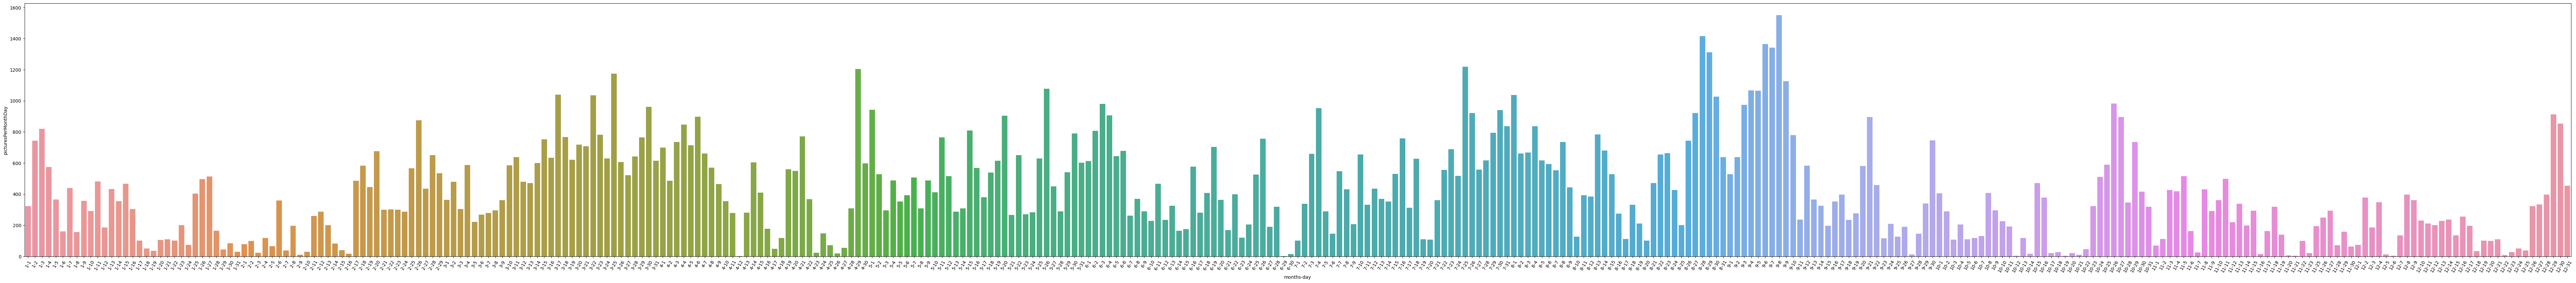

In [230]:
fig,ax = plt.subplots(1,1,figsize=(100,10))
ax = sns.barplot(data=df_day_month,x=df_day_month["months-day"],y=df_day_month["picturesPerMonthDay"])
plt.xticks(rotation=60)

363
102 1
113 5
270 0
287 0
292 7
324 6
325 3
326 7
328 0
340 9
356 4
366 1


<AxesSubplot: xlabel='dayofyear'>

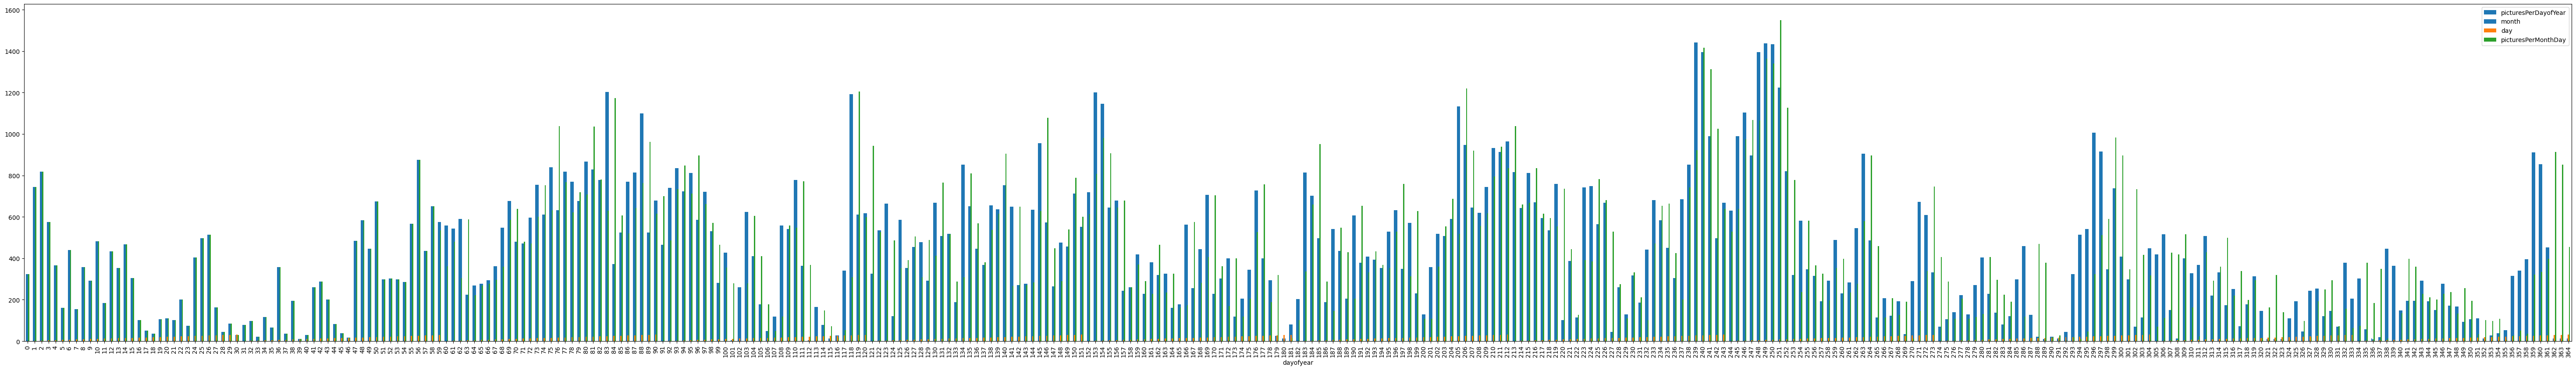

In [231]:
fig,ax = plt.subplots(1,1,figsize=(75,10))

combine_all_data['dayofyear']=combine_all_data['Date'].dt.dayofyear
print(combine_all_data['dayofyear'].nunique())
for d in range(1,367):
    if(len(combine_all_data[combine_all_data['dayofyear']==d])<10):
        print(d,len(combine_all_data[combine_all_data['dayofyear']==d]))
combine_all_data.groupby(['dayofyear']).agg(picturesPerDayofYear=('SourceFile','count')).plot(kind="bar",ax=ax)

df_day_month.sort_values(by=["month",'day']).plot(kind="bar",ax=ax)

In [232]:
df_day_month.sort_values(by='picturesPerMonthDay',ascending=False).head(30).reset_index()

,index,month,day,picturesPerMonthDay,months-str,day-str,months-day
0,251,9,8,1550,9,8,9-8
1,240,8,28,1416,8,28,8-28
2,249,9,6,1364,9,6,9-6
3,250,9,7,1341,9,7,9-7
4,241,8,29,1313,8,29,8-29
5,206,7,25,1219,7,25,7-25
6,119,4,29,1205,4,29,4-29
7,84,3,25,1174,3,25,3-25
8,252,9,9,1126,9,9,9-9
9,146,5,26,1078,5,26,5-26


In [233]:
df_day_month.sort_values(by='picturesPerMonthDay').head(30).reset_index()

,index,month,day,picturesPerMonthDay,months-str,day-str,months-day
0,102,4,12,1,4,12,4-12
1,180,6,29,2,6,29,6-29
2,292,10,19,3,10,19,10-19
3,285,10,12,3,10,12,10-12
4,325,11,21,3,11,21,11-21
5,339,12,6,3,12,6,12-6
6,324,11,20,6,11,20,11-20
7,355,12,22,7,12,22,12-22
8,294,10,21,10,10,21,10-21
9,39,2,9,11,2,9,2-9


In [234]:
df_day_month[df_day_month["month"]==11]

,month,day,picturesPerMonthDay,months-str,day-str,months-day
305,11,1,69,11,1,11-1
306,11,2,112,11,2,11-2
307,11,3,427,11,3,11-3
308,11,4,419,11,4,11-4
309,11,5,515,11,5,11-5
310,11,6,163,11,6,11-6
311,11,7,24,11,7,11-7
312,11,8,430,11,8,11-8
313,11,9,292,11,9,11-9
314,11,10,360,11,10,11-10


<AxesSubplot: xlabel='Date'>

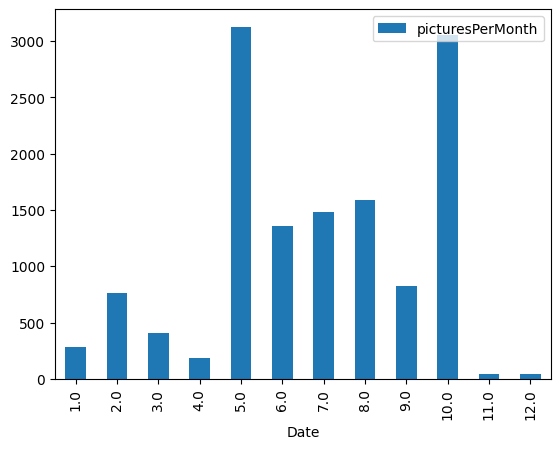

In [235]:
combine_all_data.loc[(combine_all_data['Date'].dt.year==2021)].groupby(combine_all_data['Date'].dt.month).agg(picturesPerMonth=('SourceFile','count')).plot(kind="bar")

<AxesSubplot: xlabel='Date'>

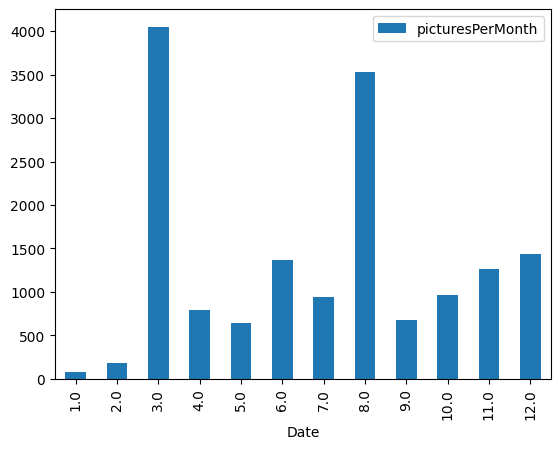

In [236]:
combine_all_data.loc[(combine_all_data['Date'].dt.year==2022)].groupby(combine_all_data['Date'].dt.month).agg(picturesPerMonth=('SourceFile','count')).plot(kind="bar")

<AxesSubplot: xlabel='Date'>

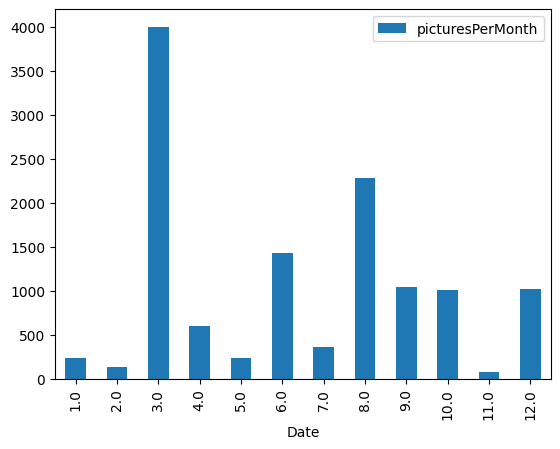

In [237]:
combine_all_data.loc[(combine_all_data['Date'].dt.year==2023)].groupby(combine_all_data['Date'].dt.month).agg(picturesPerMonth=('SourceFile','count')).plot(kind="bar")

<AxesSubplot: xlabel='Date'>

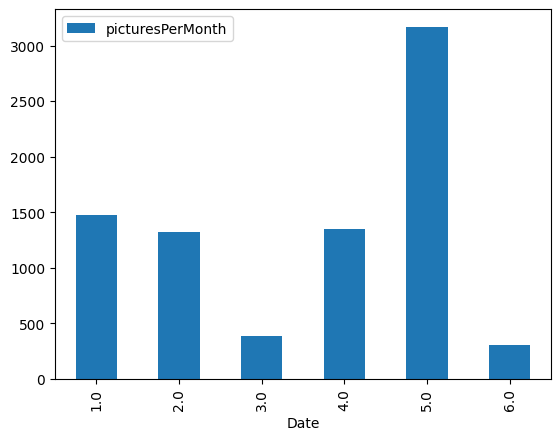

In [238]:
combine_all_data.loc[(combine_all_data['Date'].dt.year==2024)].groupby(combine_all_data['Date'].dt.month).agg(picturesPerMonth=('SourceFile','count')).plot(kind="bar")

<AxesSubplot: xlabel='Date'>

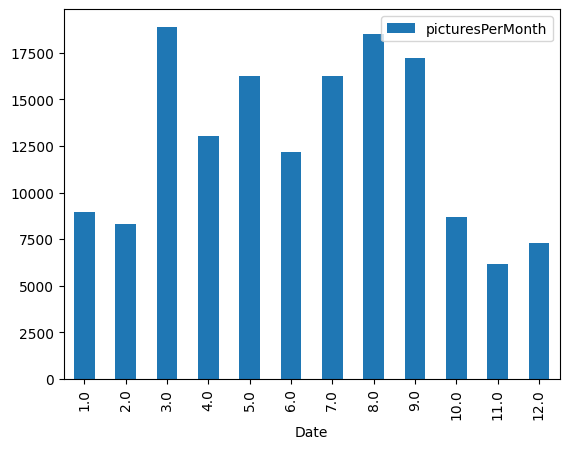

In [239]:
combine_all_data.groupby(combine_all_data['Date'].dt.month).agg(picturesPerMonth=('SourceFile','count')).plot(kind="bar")

In [240]:
(combine_all_data['Date'].dt.month.astype(str)+"-"
 +combine_all_data['Date'].dt.day.astype(str)
    ).value_counts(sort=False).reset_index()

,index,Date
0,11.0-25.0,193
1,7.0-11.0,332
2,7.0-12.0,434
3,7.0-13.0,369
4,7.0-14.0,353
...,...,...
361,11.0-7.0,24
362,2.0-7.0,37
363,1.0-22.0,101
364,1.0-30.0,84


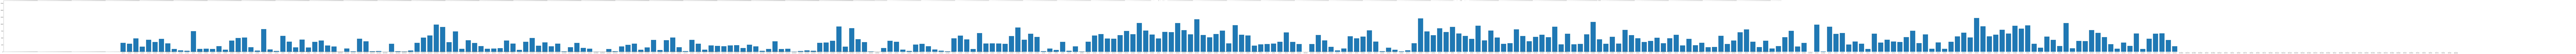

In [241]:

fig=plt.figure(figsize=(500,10))
plt.bar(x=(combine_all_data['Date'].dt.month.astype(str)+"-"
 +combine_all_data['Date'].dt.day.astype(str)
    ).value_counts(sort=False).reset_index().sort_values(by="index")["index"].values,
    height=(combine_all_data['Date'].dt.month.astype(str)+"-"
 +combine_all_data['Date'].dt.day.astype(str)
    ).value_counts(sort=False).reset_index().sort_values(by="index")["Date"].values)
plt.show()

In [242]:
(combine_all_data['Date'].dt.month.astype(str)+"-"
 +combine_all_data['Date'].dt.day.astype(str)
    ).value_counts(sort=False).reset_index().sort_values(by="index")["Date"].values

array([ 323,  291,  482,  185,  433,  354,  467,  304,  101,   51,   36,
        744,  105,  110,  101,  201,   74,  403,  497,  514,  164,   44,
        819,   84,   30,  575,  365,  160,  440,  155,  357,  406,  225,
        191,    3,  118,   17,  470,  378,   20,   27,    3,  288,   20,
         10,   47,  323,  511,  589,  982,  896,  347,  734,  107,  416,
        318,  205,  109,  117,  131,  407,  296,   69,  360,  498,  219,
        338,  198,  294,   14,  163,  319,  139,  112,    6,    3,   98,
         20,  193,  249,  294,   72,  157,  427,   63,  419,  515,  163,
         24,  430,  292,   74,  229,  211,  200,  228,  237,  134,  255,
        195,   34,  101,  378,   98,  109,    7,   27,   51,   37,  322,
        334,  397,  913,  185,  853,  454,  349,   13,    3,  135,  397,
        360,   78,   29,  260,  287,  200,   82,   39,   17,  485,  583,
        446,   98,  675,  299,  302,  299,  286,  566,  875,  435,  651,
        535,   22,  117,   65,  358,   37,  195,   

<AxesSubplot: >

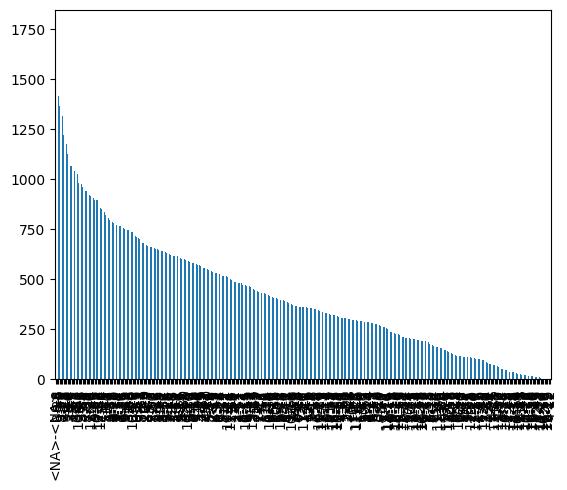

In [243]:
combine_all_data['Date'].dt.month.astype("Int64").astype(str)+"-"+combine_all_data['Date'].dt.day.astype('Int64').astype(str)

(combine_all_data['Date'].dt.month.astype("Int64").astype(str)+"-"
 +combine_all_data['Date'].dt.day.astype('Int64').astype(str)
).value_counts().plot(kind='bar')

In [244]:
combine_all_data['month-day']=combine_all_data['Date'].dt.month.astype("Int64").astype(str)+"-"+combine_all_data['Date'].dt.day.astype('Int64').astype(str)


In [245]:
#df_dayofyear=combine_all_data.groupby(['month-day']).agg(SumPhotoPerMonthDay=("Pictures"))

363
102 1
113 5
270 0
287 0
292 7
324 6
325 3
326 7
328 0
340 9
356 4
366 1


<AxesSubplot: xlabel='dayofyear'>

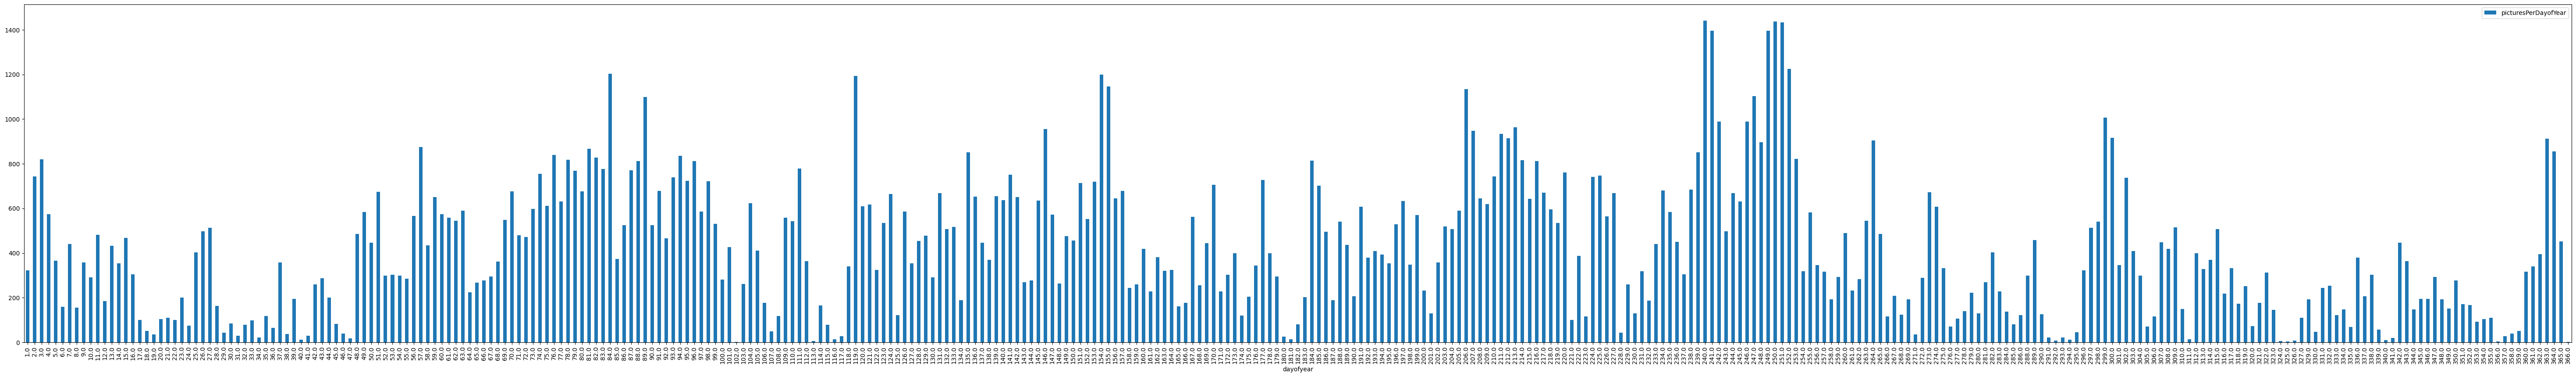

In [246]:
fig,ax = plt.subplots(1,1,figsize=(75,10))

combine_all_data['dayofyear']=combine_all_data['Date'].dt.dayofyear
print(combine_all_data['dayofyear'].nunique())
for d in range(1,367):
    if(len(combine_all_data[combine_all_data['dayofyear']==d])<10):
        print(d,len(combine_all_data[combine_all_data['dayofyear']==d]))
combine_all_data.groupby(['dayofyear']).agg(picturesPerDayofYear=('SourceFile','count')).plot(kind="bar",ax=ax)

In [247]:
combine_all_data['DayString']=combine_all_data.loc[combine_all_data["Day"].notna(),'Day'].apply(lambda x:x.strftime('%Y-%m-%d')).str[5:]

02-30 0
02-31 0
04-12 0
04-31 0
06-29 2
06-31 0
09-31 0
10-12 3
10-19 3
11-20 6
11-21 3
11-24 0
11-31 0
12-06 3
12-22 5


<AxesSubplot: xlabel='DayString'>

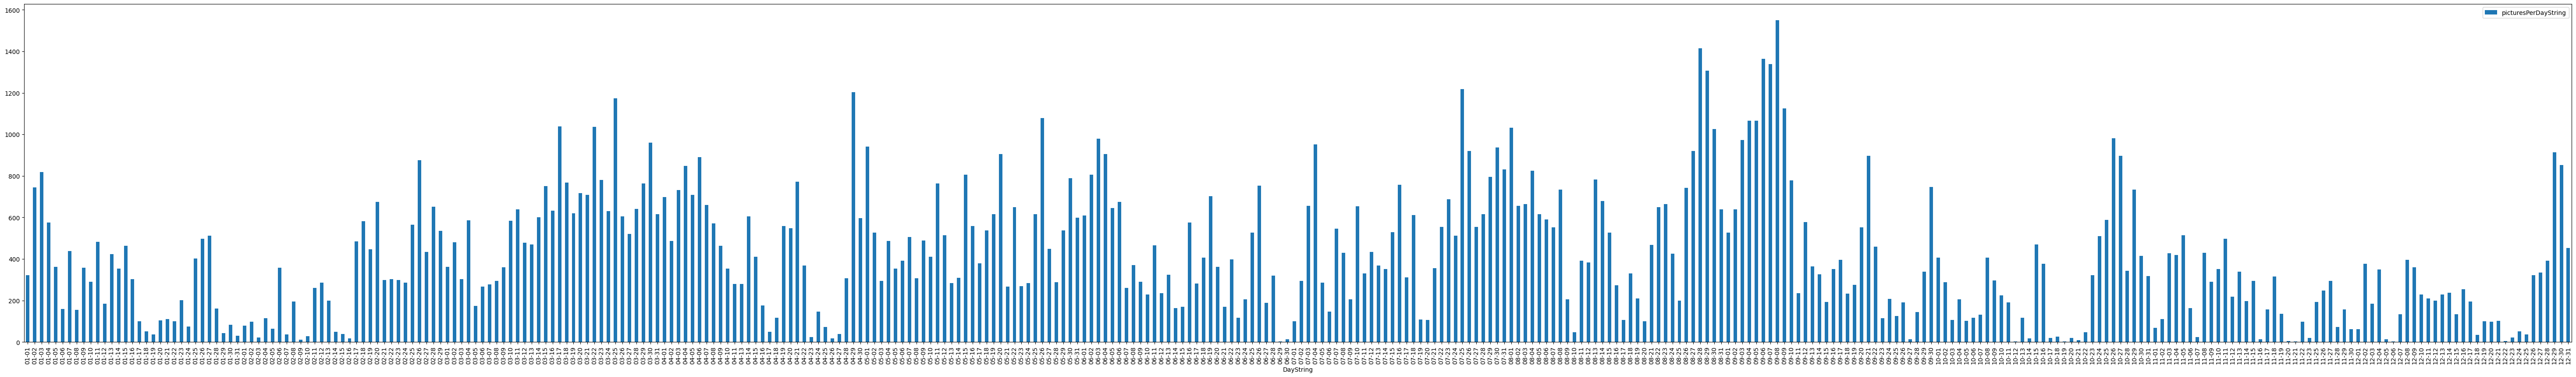

In [248]:
fig,ax = plt.subplots(1,1,figsize=(75,10))


for m in range(1,13):
    for d in range(1,32):
        str_m=str(m)
        str_d=str(d)
        if m<10:
            str_m="0"+str_m
        if d<10:
            str_d="0"+str_d
        test_string=str_m+'-'+str_d
        if(len(combine_all_data[combine_all_data['DayString']==test_string])<10):
            print(test_string,len(combine_all_data[combine_all_data['DayString']==test_string]))

combine_all_data.sort_values(by=['DayString']).groupby("DayString").agg(picturesPerDayString=('SourceFile','count')).plot(kind="bar",ax=ax)

<AxesSubplot: xlabel='months'>

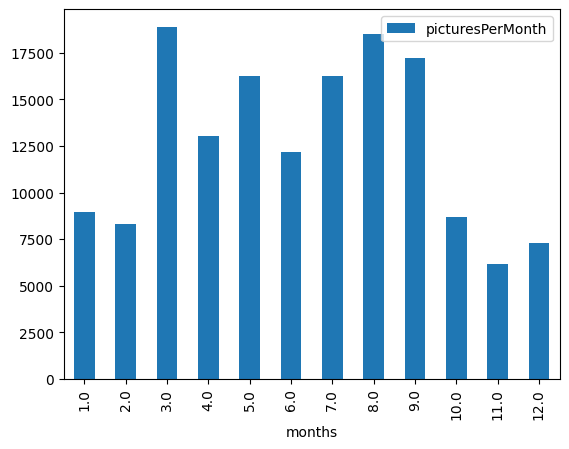

In [249]:
combine_all_data['months']=combine_all_data['Date'].dt.month
combine_all_data.groupby(['months']).agg(picturesPerMonth=('SourceFile','count')).plot(kind="bar")

<AxesSubplot: xlabel='dayofweek'>

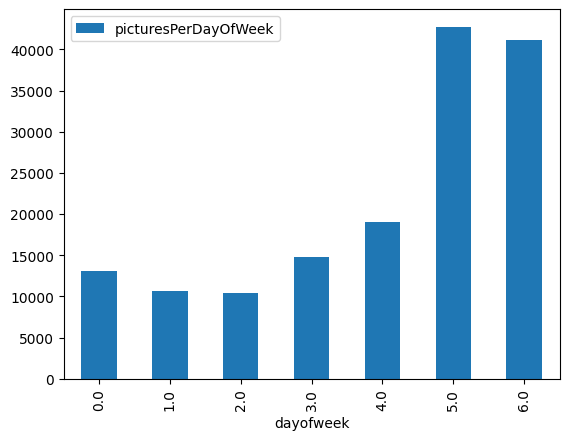

In [250]:
combine_all_data['dayofweek']=combine_all_data['Date'].dt.dayofweek
combine_all_data.groupby(['dayofweek']).agg(picturesPerDayOfWeek=('SourceFile','count')).plot(kind="bar")

In [251]:
df_no_home=combine_all_data[(combine_all_data['Place']!='Genf')& (combine_all_data['Place']!='Meyrin')
                            & (combine_all_data['Place']!='Lauchringen')
                            ].groupby(['year']).agg(DaysPerYear=('Day','nunique'),DaysInYear=('leapyear','median'))
df_no_home['DaysPerYearRatio']=df_no_home['DaysPerYear']/df_no_home['DaysInYear']
df_no_home.drop(columns=['DaysInYear'])

,DaysPerYear,DaysPerYearRatio
year,,
1996,0,0.000000
1997,0,0.000000
1998,0,0.000000
1999,0,0.000000
2000,0,0.000000
2001,0,0.000000
2002,0,0.000000
2003,0,0.000000
2004,0,0.000000


<AxesSubplot: title={'center': 'monthly count of  pictures'}, xlabel='Date', ylabel='picture count'>

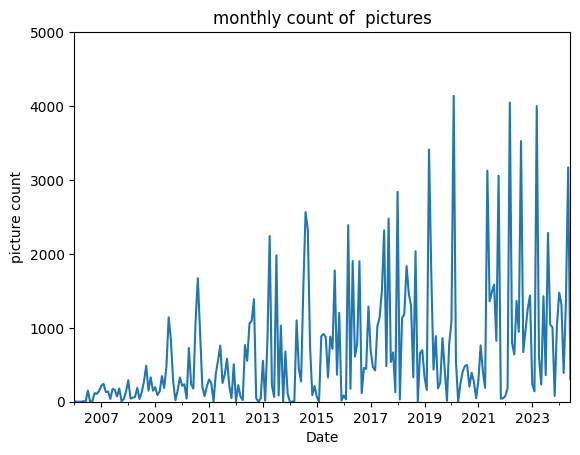

In [252]:
combine_all_data['Date']=pd.to_datetime(combine_all_data['Date'], utc=True)
#combine_all_data['Date'] = combine_all_data['Date'].dt.tz_localize(timezone.utc)
combine_all_data.groupby(pd.Grouper(key="Date", freq="M")).count()["SourceFile"].plot(title="monthly count of  pictures",ylabel="picture count",ylim=(0,5000))

<AxesSubplot: title={'center': 'monthly count of  pictures'}, xlabel='Date', ylabel='picture count'>

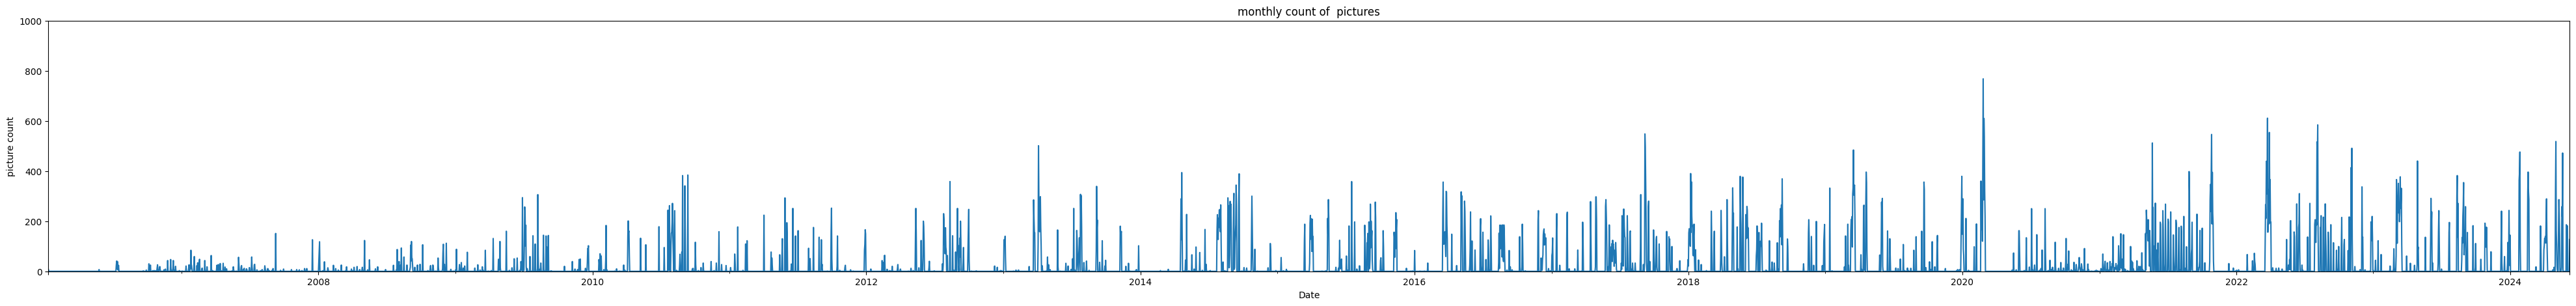

In [253]:
fig,ax=plt.subplots(1,1,figsize=(50,5))
combine_all_data['Date']=pd.to_datetime(combine_all_data['Date'], utc=True)
#combine_all_data['Date'] = combine_all_data['Date'].dt.tz_localize(timezone.utc)
combine_all_data.groupby(pd.Grouper(key="Date", freq="D")).count()["SourceFile"].plot(title="monthly count of  pictures",ylabel="picture count",ylim=(0,1000))

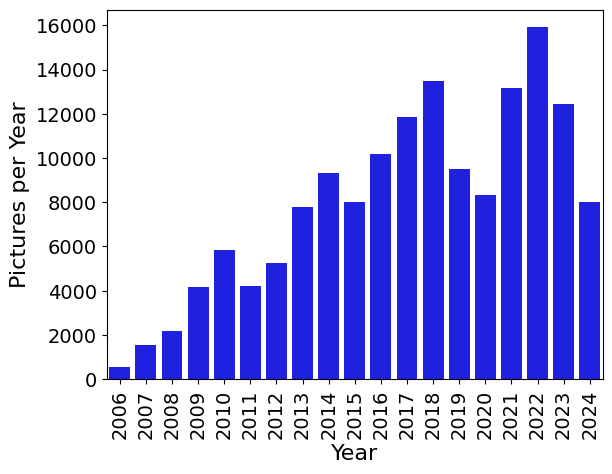

In [254]:
df_group=combine_all_data.groupby(pd.Grouper(key="Date", freq="Y")).count()["SourceFile"].reset_index()

ax = sns.barplot(x="Date", y="SourceFile", data=df_group,color = 'blue') 
x_dates = df_group['Date'].dt.strftime('%Y').sort_values().unique()
ax.set_xticklabels(labels=x_dates, rotation=90, ha='center')
ax.set_xlabel('Year',fontsize=16)
ax.set_ylabel('Pictures per Year',fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=14)

In [255]:
combine_all_data.groupby([combine_all_data["Date"].dt.hour]).count()

,SourceFile,Aperture,BitsPerSample,ColorSpace,Contrast,CreateDate,Date,ExposureTime,FileName,Flash,...,DateFirst,YearFirst,leapyear,month,day,dayofyear,month-day,DayString,months,dayofweek
Date,,,,,,,,,,,,,,,,,,,,,
0.0,362,350,362,362,348,362,362,354,362,354,...,362,362,362,362,362,362,362,354,362,362
1.0,511,501,511,511,482,511,511,502,511,502,...,511,511,511,511,511,511,511,511,511,511
2.0,599,592,599,599,584,599,599,592,599,592,...,599,599,599,599,599,599,599,599,599,599
3.0,601,591,601,601,590,601,601,592,601,592,...,601,601,601,601,601,601,601,600,601,601
4.0,433,428,433,433,428,433,433,428,433,428,...,433,433,433,433,433,433,433,430,433,433
5.0,464,458,464,464,455,464,464,458,464,458,...,464,464,464,464,464,464,464,464,464,464
6.0,1057,1044,1057,1057,992,1057,1057,1044,1057,1044,...,1057,1057,1057,1057,1057,1057,1057,1039,1057,1057
7.0,2430,2376,2430,2430,2099,2430,2430,2380,2430,2380,...,2430,2430,2430,2430,2430,2430,2430,2412,2430,2430
8.0,5993,5906,5993,5993,5250,5993,5993,5907,5993,5907,...,5992,5992,5993,5993,5993,5993,5993,5970,5993,5993


In [256]:
test_sth=combine_all_data.groupby(combine_all_data["Date"].dt.dayofyear)[['SourceFile','Aperture']].count().sort_values(by=['SourceFile'], ascending=False)
test_sth

,SourceFile,Aperture
Date,,
240.0,1442,1424
250.0,1437,1415
251.0,1434,1418
241.0,1396,1377
249.0,1396,1378
...,...,...
113.0,5,4
356.0,4,2
325.0,3,3


In [257]:
test_sth=combine_all_data.groupby(combine_all_data["Date"].dt.date).agg(photosPerDay=('SourceFile','count'),
                                                                        countries=('Country','unique'),
                                                                        places=('Place','unique'),
                                                                        weekday=('dayofweek','mean')
                                                                       ).sort_values(by=['photosPerDay'], ascending=False)
test_sth.head(20)

,photosPerDay,countries,places,weekday
Date,,,,
2020-02-26,768,[Italy],[Florenz],2.0
2022-03-25,611,[Spain],[Sevilla],4.0
2020-02-28,610,"[Italy, Vatican]",[Rom],4.0
2022-08-06,584,[Italy],[Venedig],5.0
2022-03-30,554,[Spain],[Toledo],2.0
2017-09-07,548,"[Italy, Vatican]",[Rom],3.0
2021-10-27,546,[France],"[Paris, Saint Denis]",2.0
2020-02-29,535,"[Italy, Vatican]",[Rom],5.0
2024-05-02,518,[United Kingdom],"[London, Canterbury]",3.0


In [258]:
combine_all_data[combine_all_data['Country']=='Switzerland'].groupby(
    by=['State']).count().sort_values(by=['SourceFile'],ascending=False).rename(
    columns={"SourceFile": "PicsPerState"}).reset_index()[['State','PicsPerState']]

,State,PicsPerState
0,Geneve,5172
1,Wallis,4153
2,Bern,2052
3,Vaud,1089
4,Zuerich,566
5,Neuchatel,443
6,Basel-Stadt,336
7,Switzerland,336
8,Appenzell Innerrhoden,292
9,Graubuenden,261


In [259]:
combine_all_data[combine_all_data['Country']=='Austria'].groupby(
    by=['State']).count().sort_values(by=['SourceFile'],ascending=False).rename(
    columns={"SourceFile": "PicsPerState"}).reset_index()[['State','PicsPerState']]

,State,PicsPerState
0,Wien,6095
1,Niederoesterreich,2666
2,Oberoesterreich,1187
3,Salzburg,1167
4,Steiermark,969
5,Tirol,842
6,Burgenland,270
7,Kaernten,149
8,Austria,35
9,Vorarlberg,9


In [260]:
combine_all_data[combine_all_data['Country']=='Germany'].groupby(
    by=['State']).count().sort_values(by=['SourceFile'],ascending=False).rename(
    columns={"SourceFile": "PicsPerState"}).reset_index()[['State','PicsPerState']]

,State,PicsPerState
0,Baden-Wuerttemberg,5710
1,Bayern,5610
2,Nordrhein-Westfalen,1783
3,Berlin,1352
4,Sachsen,1246
5,Brandenburg,1165
6,Hessen,1085
7,Rheinland-Pfalz,937
8,Niedersachsen,670
9,Thueringen,609


In [261]:
combine_all_data[combine_all_data['Country']=='Italy'].groupby(
    by=['State']).count().sort_values(by=['SourceFile'],ascending=False).rename(
    columns={"SourceFile": "PicsPerState"}).reset_index()[['State','PicsPerState']]

,State,PicsPerState
0,Lazio,4765
1,Veneto,4136
2,Campania,3853
3,Toscana,3544
4,Lombardia,2250
5,Emilia-Romagna,1735
6,Sicilia,1435
7,Piemonte,921
8,Puglia,675
9,Umbria,630


In [262]:
combine_all_data[combine_all_data['Country']=='France'].groupby(
    by=['State']).count().sort_values(by=['SourceFile'],ascending=False).rename(
    columns={"SourceFile": "PicsPerState"}).reset_index()[['State','PicsPerState']]

,State,PicsPerState
0,Ile-de-France,6761
1,Auvergne-Rhone-Alpes,3482
2,Centre-Val de Loire,1059
3,Provence-Alpes-Cote d'Azur,781
4,Grand Est,665
5,Occitanie,616
6,Bourgogne-Franche-Comte,475
7,Nouvelle-Aquitaine,420
8,Hauts-de-France,357
9,Normandie,354


In [263]:
combine_all_data[combine_all_data['Country']=='Spain'].groupby(
    by=['State']).count().sort_values(by=['SourceFile'],ascending=False).rename(
    columns={"SourceFile": "PicsPerState"}).reset_index()[['State','PicsPerState']]

,State,PicsPerState
0,Andalucia,3099
1,Madrid,1685
2,Castilla y Leon,1604
3,Catalonia,1475
4,Castile-La Mancha,966
5,Galicia,375
6,Extremadura,358
7,Valencia,286
8,Cantabria,186
9,Aragon,183


In [264]:
combine_all_data[combine_all_data['Country']=='Italy'].groupby(
    by=['Province']).count().sort_values(by=['SourceFile'],ascending=False).rename(
    columns={"SourceFile": "PicsPerProvince"}).reset_index()[['Province','PicsPerProvince']]

,Province,PicsPerProvince
0,Roma,4636
1,Napoli,2542
2,Venezia,2239
3,Florenz,2181
4,Milano,1180
5,Siena,907
6,Torino,852
7,Padova,675
8,Vicenza,644
9,Palermo,621


In [265]:
combine_all_data[combine_all_data['Country']=='France'].groupby(
    by=['Province']).count().sort_values(by=['SourceFile'],ascending=False).rename(
    columns={"SourceFile": "PicsPerProvince"}).reset_index()[['Province','PicsPerProvince']]

,Province,PicsPerProvince
0,Paris,4608
1,Haute-Savoie,2152
2,Yvelines,1097
3,Seine-et-Marne,678
4,Ain,628
5,Lyon,584
6,Cher,397
7,Bouches-du-Rhone,353
8,Champagne,323
9,Bas-Rhin,310


In [266]:
combine_all_data[combine_all_data['Country']=='Spain'].groupby(
    by=['Province']).count().sort_values(by=['SourceFile'],ascending=False).rename(
    columns={"SourceFile": "PicsPerProvince"}).reset_index()[['Province','PicsPerProvince']]

,Province,PicsPerProvince
0,Madrid,1685
1,Barcelona,1212
2,Sevilla,937
3,Granada,815
4,Toledo,774
5,Cordoba,641
6,Segovia,571
7,Leon,418
8,Malaga,387
9,La Coruna,375


In [267]:
combine_all_data[combine_all_data['Country']=='Austria'].groupby(
    by=['State']).count().sort_values(by=['SourceFile'],ascending=False).rename(
    columns={"SourceFile": "PicsPerState"}).reset_index()[['State','PicsPerState']]

,State,PicsPerState
0,Wien,6095
1,Niederoesterreich,2666
2,Oberoesterreich,1187
3,Salzburg,1167
4,Steiermark,969
5,Tirol,842
6,Burgenland,270
7,Kaernten,149
8,Austria,35
9,Vorarlberg,9


In [268]:
combine_all_data[combine_all_data['Country']=='Austria'].groupby(
    by=['Province']).count().sort_values(by=['SourceFile'],ascending=False).rename(
    columns={"SourceFile": "PicsPerBezirk"}).reset_index()[['Province','PicsPerBezirk']]

,Province,PicsPerBezirk
0,Wien,6095
1,Salzburg,665
2,Innsbruck,569
3,Gmunden,547
4,Graz,380
5,Moedling,311
6,Gaenserndorf,276
7,Tulln,268
8,Lilienfeld,255
9,Krems-Land,246


In [269]:
combine_all_data[combine_all_data['Country']=='Czech Republic'].groupby(
    by=['State']).count().sort_values(by=['SourceFile'],ascending=False).rename(
    columns={"SourceFile": "PicsPerState"}).reset_index()[['State','PicsPerState']]

,State,PicsPerState
0,Prague,1552
1,South Moravian Region,832
2,Vysocina Region,344
3,Central Bohemian Region,208
4,Pardubice Region,149
5,Olomouc Region,140
6,South Bohemian Region,137
7,Zlin Region,131


In [270]:
combine_all_data['Day'].nunique()

1468

In [271]:
combine_all_data.columns

Index(['SourceFile', 'Aperture', 'BitsPerSample', 'ColorSpace', 'Contrast',
       'CreateDate', 'Date', 'ExposureTime', 'FileName', 'Flash', 'FNumber',
       'FocalLength in mm', 'FocalLength35efl', 'ImageSize', 'ImageWidth',
       'ISO', 'LightValue', 'Model', 'Orientation', 'Quality', 'ShutterSpeed',
       'WhiteBalance', 'Place', 'year', 'dayperiod', 'CompositePhoto', 'Movie',
       'ApertureValue', 'BlueBalance', 'ColorTempAsShot', 'FlashActivity',
       'ShutterSpeedValue', 'WB_RGGBLevelsAsShot', 'Country', 'Province',
       'State', 'Day', 'DateFirst', 'YearFirst', 'leapyear', 'month', 'day',
       'dayofyear', 'month-day', 'DayString', 'months', 'dayofweek'],
      dtype='object')

In [272]:
combine_all_data.loc[(combine_all_data['months']==10),'Place'].unique()

array(['Meyrin', 'Genf', 'Goerwihl', 'Tiengen', 'Lauchringen', 'Zuerich',
       'Lauterbrunnen', 'Grindelwald', 'Fieschertal', 'Schweiz',
       'Chamonix', 'Pommersfelden', 'Wuerzburg', 'Montenvers', 'Carouge',
       'Chambessy', 'Warschau', 'Istanbul', 'Serbien', 'Kroatien',
       'Italien', 'Frankreich', 'Frankreich & Italien', 'Montalchez',
       'Muenchen', 'Melk', 'Wildbad Kreuth', 'Tegernsee', 'Goettweig',
       'Passau', 'Salzburg', 'Santiago de Compostela', 'Koeln',
       'Duesseldorf', 'Friedrichssegen', 'Limburg', 'Bruehl', 'Bonn',
       'Deutschland', 'Graz', 'Feldkirchen', 'Oesterreich', 'Kloten',
       'Helsinki', 'Tallinn', 'Estland', 'Finnland', 'Schwechat', 'Wien',
       'Randa', 'Taesch', 'Zermatt', 'Gruyeres', 'Broc', 'Corseaux',
       'Rivaz', 'St-Saphorin', 'St-Genis-Pouilly', 'Lovagny',
       'Bellegarde-sur-Valserine', 'Grimentz', 'Montreux', 'Boudry',
       'Neuchatel', 'Salem', 'Ueberlingen', 'Bermatingen', 'Baden',
       'Baar', 'Zug', 'Waldshut',

In [273]:
combine_all_data.columns

Index(['SourceFile', 'Aperture', 'BitsPerSample', 'ColorSpace', 'Contrast',
       'CreateDate', 'Date', 'ExposureTime', 'FileName', 'Flash', 'FNumber',
       'FocalLength in mm', 'FocalLength35efl', 'ImageSize', 'ImageWidth',
       'ISO', 'LightValue', 'Model', 'Orientation', 'Quality', 'ShutterSpeed',
       'WhiteBalance', 'Place', 'year', 'dayperiod', 'CompositePhoto', 'Movie',
       'ApertureValue', 'BlueBalance', 'ColorTempAsShot', 'FlashActivity',
       'ShutterSpeedValue', 'WB_RGGBLevelsAsShot', 'Country', 'Province',
       'State', 'Day', 'DateFirst', 'YearFirst', 'leapyear', 'month', 'day',
       'dayofyear', 'month-day', 'DayString', 'months', 'dayofweek'],
      dtype='object')

In [274]:
m_day=28
m_month=10
m_year=2006
print(combine_all_data.loc[(combine_all_data['Date'].dt.month==m_month) & (combine_all_data['Date'].dt.day==m_day),
                'Date'].dt.date.unique(),
      combine_all_data.loc[(combine_all_data['Date'].dt.month==m_month) & (combine_all_data['Date'].dt.day==m_day),
                'Place'].unique())
print((combine_all_data.loc[(combine_all_data['Date'].dt.month==m_month) & (combine_all_data['Date'].dt.day==m_day),
                'Date'].dt.date.astype(str)+" "+combine_all_data.loc[(combine_all_data['Date'].dt.month==m_month) & (combine_all_data['Date'].dt.day==m_day),
                'Place']).unique())

[datetime.date(2006, 10, 28) datetime.date(2014, 10, 28)
 datetime.date(2020, 10, 28) datetime.date(2021, 10, 28)
 datetime.date(2023, 10, 28)] ['Genf' 'Istanbul' 'Lauchringen' 'Arras' 'Oignies' 'Lille' 'Tournai'
 'Paris' 'Stockholm' 'Solna']
['2006-10-28 Genf' '2014-10-28 Istanbul' '2020-10-28 Lauchringen'
 '2021-10-28 Arras' '2021-10-28 Oignies' '2021-10-28 Lille'
 '2021-10-28 Tournai' '2021-10-28 Paris' '2023-10-28 Stockholm'
 '2023-10-28 Solna']


In [275]:
print((combine_all_data.loc[
    (combine_all_data['Date'].dt.year==m_year) & (combine_all_data['Date'].dt.month==m_month)
    & (combine_all_data['Date'].dt.day==m_day)
                ,'FileName']).unique())

['PA270001 - Genf, See mit St. Gervais & Ile de Rousseau.JPG'
 "PA270002 - Genf, Jet d'Eau mit Wassertaxi.JPG"
 "PA270004 - Genf, Jet d'Eau.JPG"
 'PA270005 - Genf, Blumenuhr im Jardin Anglais.JPG'
 'PA270006 - Genf, St. Madelaine.JPG'
 'PA270007 - Genf, Kathedrale, Turm & Chor.JPG'
 'PA270010 - Genf, Kathedrale, Rosette.JPG'
 'PA270011 - Genf, Kathedrale, im Langhaus.JPG'
 'PA270014 - Genf, Kathedrale, Chorgestuehl.JPG'
 'PA270016 - Genf, Kathedrale, Chorraum.JPG'
 'PA270017 - Genf, Kathedrale, Chorraum.JPG'
 'PA270018 - Genf, Kathedrale, Makkabaeerkapelle.JPG'
 'PA270020 - Genf, Kathedrale, Fassade.JPG'
 'PA270021 - Genf, Place Neuve mit Oper & Musee Rath.JPG'
 'PA270022 - Genf, Fusterie.JPG']


In [276]:
combine_all_data.columns

Index(['SourceFile', 'Aperture', 'BitsPerSample', 'ColorSpace', 'Contrast',
       'CreateDate', 'Date', 'ExposureTime', 'FileName', 'Flash', 'FNumber',
       'FocalLength in mm', 'FocalLength35efl', 'ImageSize', 'ImageWidth',
       'ISO', 'LightValue', 'Model', 'Orientation', 'Quality', 'ShutterSpeed',
       'WhiteBalance', 'Place', 'year', 'dayperiod', 'CompositePhoto', 'Movie',
       'ApertureValue', 'BlueBalance', 'ColorTempAsShot', 'FlashActivity',
       'ShutterSpeedValue', 'WB_RGGBLevelsAsShot', 'Country', 'Province',
       'State', 'Day', 'DateFirst', 'YearFirst', 'leapyear', 'month', 'day',
       'dayofyear', 'month-day', 'DayString', 'months', 'dayofweek'],
      dtype='object')

In [277]:
string_town="Stockholm"
print(string_town,combine_all_data.loc[(combine_all_data['Place']==string_town)
                                       & (combine_all_data['Place'].notna()),'Date'].min(),
      combine_all_data.loc[(combine_all_data['Place']==string_town)
                                       & (combine_all_data['Place'].notna()),'Date'].max(),
      combine_all_data.loc[(combine_all_data['Place']==string_town)
                                       & (combine_all_data['Place'].notna()),'Date'].dt.date.nunique()
     )

Stockholm 2013-07-15 07:21:42+00:00 2023-10-29 15:29:57+00:00 13
